# <font size=5, color = 'black'> Notes </font>

Author: Huan Q. Bui

Affiliation: BEC1 experiment at Zlabs, MIT
             
PI: Professor Martin Zwierlein

First updated: Feb 07, 2023

Last updated: April 06, 2023

To do:
- Compressibility!
- Implement bootstrapping
- Intelligent Box Exp cutting
- Try thermometry on Box Exp shots
- Rapid ramp analysis (condensate fraction fit)
- Na BEC fitting (condensate fraction fit)
- Li MT LF thermometry. This is a good starting point for hybrid trap thermometry.
- Simulate compressible fluid in a box with a perturbing side wall?
- Breit Rabi calculator

# <font size=5, color='black'> Setting up </font>

##  <font size=3, color=#399FD5>Collapsible Headings and Initialization Cells</font>

Run the following commands in anaconda prompt to install a graphical interface for configuring collapsible headings and other extentions/plugins from within the notebooks:

pip install jupyter_contrib_nbextensions
jupyter contrib nbextension install --user
jupyter nbextensions_configurator enable --user

Once done, go to Jupyter notebook --> Nbextensions --> check the "Collapsible Headings" box

Can also turn on "Initialization cell" in Jupyter Notebook extension settings. 
Then go to View/Cell Toolbar/Initialization Cell and check cells that will be run on startup

## <font size=3, color=#399FD5>Imports and Parallel Computing Setup</font>

In [ ]:
from tkinter import Tk
from tkinter import filedialog # for prompting user to set analysis folder
import glob
import json
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import os
import scipy
from scipy.optimize import fsolve
from scipy.fft import fft, fftfreq
from scipy.integrate import trapezoid
from scipy.signal import savgol_filter
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
import math
import numba
import shutil
import time
import datetime

In [ ]:
# for parallel processing
import contextlib
import joblib

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

## <font size=3, color=#399FD5>Suppress Warnings</font>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## <font size = 3, color=#399FD5>Constants</font>

In [ ]:
ABSORPTION_LIMIT = 5.0
SPECIAL_CHARACTERS = "!@#$%^&*()-+?_=,<>/"

# physics constants
hbar = 1.05457182*10**(-34) # Js

# Lithium constants
mLi6 = 9.9883414*10**(-27) # kg
Li6D2Gamma = 5.8724 # MHz. Note that this is NOT angular freq
Li6D2lambda0 = 670.977338*10**(-9) # meters
Li6D2sigma0 = 3*(Li6D2lambda0)**2/(2*np.pi)

# Sodium constants
mNa23 = 0.381754035*10**(-25) # kg 

# <font size=5, color='black'>Utility functions </font>

## <font size=3, color=#399FD5>Mathematical functions</font>

In [ ]:
def _absorption_coefficient(omega, amp, omega0, gamma_prime, offset):
    return amp * gamma_prime**2/ ( 4*(omega-omega0)**2 + gamma_prime**2) + offset

In [ ]:
def _P2_Rabi(omega_and_tau, omegaR, omega0, offset):
    omega = omega_and_tau[0]
    tau = omega_and_tau[1]    
    OmegaR = np.sqrt( omegaR**2 + (omega - omega0)**2 )
    return ( omegaR**2 / OmegaR**2) * np.sin( 2*np.pi*OmegaR * tau * 10**(6-3)/ 2)**2 + offset

In [ ]:
def _cosine(t, amp, omega0, phi, offset):
    return amp * np.cos(2*np.pi*(t*omega0 + phi)) + offset

In [ ]:
def _parabola(x, curvature, gradient, bias):
    return curvature*x**2 + gradient*x + bias

In [ ]:
def _gaussian(x, center, amp, sigma, offset):
    return amp * np.exp(-(x-center)**2/(2*sigma**2)) + offset

In [ ]:
def _lorentzian(omega, amp, omega0, gamma_prime, offset):
    return amp * gamma_prime**2/ ( 4*(omega-omega0)**2 + gamma_prime**2) + offset

In [ ]:
def _lorentzian_no_offset(omega, amp, omega0, gamma_prime):
    return amp * gamma_prime**2/ ( 4*(omega-omega0)**2 + gamma_prime**2)

In [ ]:
def _sigmoid(z, amplitude, center, sharpness, width, offset):
    return (-1/(1 + np.exp((-(z - center) + width/2)/sharpness)) + 1/(1 + np.exp((-(z - center) - width/2)/sharpness)) )*amplitude + offset

## <font size=3, color=#399FD5>Get run parameters</font>

In [ ]:
def get_run_param_from_filename(folder_path, current_file_fullpath, metadata_dict = dict(), param = ''):
    '''
    get a single parameter value from a file, if metadata)dict exists:
    '''
    param_for_filename = 0
    name = str(current_file_fullpath.split(folder_path)[1]).replace('\\',"")
    run_id = name.split('_')[0]
    run_id = "".join(ch for ch in run_id if ch.isalnum() ) # extract run_id out of folder name
    # get params for this run_id
    if bool(metadata_dict):
        params_for_run_id = metadata_dict[run_id]
        param_for_filename = params_for_run_id[param]
    return param_for_filename

In [ ]:
def get_run_params_for_data_frame(folder_path, metadata_dict = dict(), params = []):
    '''
    params: list of param names [p1,p2,...]
    returns a dictionary of the form {p1: [], p2: [],...}
    '''
    params_for_folder = dict() # this is a dict() of lists
    # initial params_for_folder:
    if params != []:
        for p in params:
            params_for_folder[p] = []
    if bool(metadata_dict): 
        for f in sorted(glob.glob(folder_path + '/*.fits')): # for every fits file in folder
            name = str(f.split(folder_path)[1]).replace('\\',"")
            run_id = name.split('_')[0] 
            run_id = "".join(ch for ch in run_id if ch.isalnum() )

            if run_id in metadata_dict.keys():
                # get params for this run_id
                params_for_run_id = metadata_dict[run_id]
                for k in params_for_folder.keys():
                    params_for_folder[k].append(params_for_run_id[k])
                
    return params_for_folder

### EXAMPLE CODE: ####
# params = get_run_params(folder_path, params = ['LFImgFreq', 'SideGreenEvap', 'IREvap'])

## <font size=3, color=#399FD5>Initialize data frame</font>

In [ ]:
def init_dataframe_metadata_and_exp_params(optional_parameter_list = []):

    folder_path = filedialog.askdirectory()
    metadata_dict = dict()
    experiment_parameters_dict = dict()
    
    # load metadata if avalable:
    metadata_fullpath_load_status = False
    metadata_fullpath = folder_path + "/run_params_dump.json"
    if os.path.isfile(metadata_fullpath):
        metadata_fullpath_load_status = True
        with open(metadata_fullpath, 'r') as json_file:
            metadata_dict = json.load(json_file)  

    # load experiment_parameters if avaiable:
    experiment_parameters_fullpath_load_status = False
    experiment_parameters_fullpath = folder_path + "/experiment_parameters.json"
    if os.path.isfile(experiment_parameters_fullpath):
        experiment_parameters_fullpath_load_status = True
        with open(experiment_parameters_fullpath, 'r') as json_file:
            experiment_parameters_dict = json.load(json_file)  
            
    # construct data frame with full paths:
    image_list = sorted(glob.glob(folder_path + '/*.fits'))
    data_frame = pd.DataFrame()
    
    # get file names for readability and attach to data frame:
    # also get image type: TopA, TopB, Side
    run_ids = []
    image_type = []
    ImagFreq1 = []
    ImagFreq2 = []
    LFImgFreq = []
    image_list_df = []
    for f in image_list:
        
        # add run_id
        name = str(f.split(folder_path)[1]).replace('\\',"")
        run_id = name.split('_')[0] 
        run_id = "".join(ch for ch in run_id if ch.isalnum() )
        
        if run_id in metadata_dict.keys():
            run_ids.append(run_id)
            # add path to image_list_df:
            image_list_df.append(f)
            # add image type
            if 'TopA' in name:
                image_type.append('TopA')
            elif 'TopB' in name:
                image_type.append('TopB')
            elif 'Side' in name:
                image_type.append('Side')

            # add ImagFreq, only if metadata_dict is available:
            if bool(metadata_dict):
                ImagFreq1.append(get_run_param_from_filename(folder_path, f, metadata_dict, 'ImagFreq1'))
                ImagFreq2.append(get_run_param_from_filename(folder_path, f, metadata_dict, 'ImagFreq2'))
                LFImgFreq.append(get_run_param_from_filename(folder_path, f, metadata_dict, 'LFImgFreq'))
                    
    data_frame['fullpaths'] = image_list_df
    data_frame['good_shot'] = [True for i in range(len(image_list_df))]
    data_frame['run_id'] = run_ids
    data_frame['image_type'] = image_type
    if bool(metadata_dict):
        data_frame['ImagFreq1'] = ImagFreq1
        data_frame['ImagFreq2'] = ImagFreq2
        data_frame['LFImgFreq'] = LFImgFreq
    
    # add relevant parameters to dataframe... can always add more later:
    run_params = get_run_params_for_data_frame(folder_path, metadata_dict, optional_parameter_list)
    # add data to dataframe:
    if bool(run_params):
        for param in run_params.keys():
            data_frame[param] = run_params[param]
    
    ##################################################
    ############## PRINT OUT STATUS ##################
    ##################################################

    print('Current folder: ' + folder_path)
    if metadata_fullpath_load_status:
        print('Metadata loaded')
    else:
        print('No metadata to load') 
    if experiment_parameters_fullpath_load_status:
        print('Experiment parameters loaded')
    else:
        print('No experiment parameters to load')
    print('Data frame initialized!')

    return (data_frame, metadata_dict, experiment_parameters_dict)

## <font size=3, color=#399FD5>Display image</font>

In [ ]:
# function for safely handling subtractions...
# Credit: Eric A. Wolf, BEC1@MIT, 2022. 

def safe_subtract(x, y, minimum_cast = np.byte):
    newtype = np.result_type(x, y, minimum_cast)
    return x.astype(newtype) - y.astype(newtype)

In [ ]:
# display an image given folder_path, run_id, ROI, and frame_type:
def display_image(current_file_fullpath, ROI, norm_box, 
                  frame_type = 'FakeOD', min_scale=0, max_scale=1.3, brightness=12):
    # set up figure
    fig, ax = plt.subplots()
    
    # read image
    fits_image = fits.open(current_file_fullpath)
    # fits_image.info() # display fits image info
    img = fits_image[0].data
    fits_image.close()

    # get dims of image
    dims = img[0,:,:].shape 
    x_limit = dims[1]
    y_limit = dims[0]

    # then show image:
    if frame_type == 'OD':
        frame = (-np.log(safe_subtract(img[0,:,:], img[2,:,:])/safe_subtract(img[1,:,:], img[2,:,:])))
        # clean image: using nan_to_num
        frame = np.nan_to_num(frame, nan=ABSORPTION_LIMIT)
        # fix clipping
        frame = np.clip(frame, 0, ABSORPTION_LIMIT)
        ax.imshow(frame, cmap='gray', vmin=0, vmax=2**15).set_clim(min_scale, max_scale)
        ax.invert_yaxis()

    else:
        if frame_type == 'FakeOD':
            frame = (safe_subtract(img[0,:,:], img[2,:,:])/safe_subtract(img[1,:,:], img[2,:,:]))
            # clean image: using nan_to_num
            frame = np.nan_to_num(frame)
            # fix clipping
            frame = np.clip(frame, 0, ABSORPTION_LIMIT)
            ax.imshow(frame, cmap='gray', vmin=0, vmax=2**15).set_clim(min_scale, max_scale)
            ax.invert_yaxis()
        else:
            if frame_type == 'With atoms':
                frame = img[0,:,:]
                # clean image: using nan_to_num
                frame = np.nan_to_num(frame)
                ax.imshow(frame, cmap='gray', vmin=0, vmax=2**brightness)  # need to adjust gray scale/colormap here with BRIGHTNESS variable
                ax.invert_yaxis()
            elif frame_type == 'Without atoms':
                frame = img[1,:,:]
                # clean image: using nan_to_num
                frame = np.nan_to_num(frame)
                ax.imshow(frame, cmap='gray', vmin=0, vmax=2**brightness)  # need to adjust gray scale/colormap here with BRIGHTNESS variable
                ax.invert_yaxis()
            elif frame_type == 'Dark':
                frame = img[2,:,:]
                # clean image: using nan_to_num
                frame = np.nan_to_num(frame)
                ax.imshow(frame, cmap='gray', vmin=0, vmax=2**brightness)  # need to adjust gray scale/colormap here with BRIGHTNESS variable
                ax.invert_yaxis()
            else:
                frame = (-np.log(safe_subtract(img[0,:,:], img[2,:,:])/safe_subtract(img[1,:,:], img[2,:,:])))
                # clean image: using nan_to_num
                frame = np.nan_to_num(frame)
                ax.imshow(frame, cmap='gray', vmin=0, vmax=2**15).set_clim(min_scale, max_scale)
                ax.invert_yaxis()
                
    # Create a roi patch
    width = abs(int(ROI[1]) - int(ROI[0]))
    height = abs(int(ROI[3]) - int(ROI[2]))
    xmin = min(int(ROI[0]), int(ROI[1]))
    ymin = min(int(ROI[2]), int(ROI[3]))
    roi = patches.Rectangle((xmin, ymin), 
                             width, 
                             height, 
                             linewidth=1, 
                             edgecolor='r', 
                             facecolor='none')
    # Add the ROI to the Axes
    ax.add_patch(roi)
    
    # Create a norm_box patch
    width_norm = abs(int(norm_box[1]) - int(norm_box[0]))
    height_norm = abs(int(norm_box[3]) - int(norm_box[2]))
    xmin_norm = min(int(norm_box[0]), int(norm_box[1]))
    ymin_norm = min(int(norm_box[2]), int(norm_box[3]))
    
    norm_roi = patches.Rectangle((xmin_norm, ymin_norm), 
                             width_norm, 
                             height_norm, 
                             linewidth=1, 
                             edgecolor='g', 
                             facecolor='none')
    # Add the ROI to the Axes
    ax.add_patch(roi)
    ax.add_patch(norm_roi)   
    
    # add center of ROI box to image:
    ROI_center = [(ROI[2] + ROI[3])//2, (ROI[0] + ROI[1])//2]
    ax.scatter([ROI_center[1]],[ROI_center[0]], marker='.', color = 'red', s=1)
    
    # show everything
    plt.show()
                
    return (fig, ax)

## <font size=3, color=#399FD5>Add normalized FakeOD to dataframe</font>

In [ ]:
def get_fakeOD_cropped(current_file_fullpath, ROI, norm_box):
    
    # memmapping:
    with fits.open(current_file_fullpath, memmap = True, do_not_scale_image_data = True) as fits_image:
        img = fits_image[0].data
    
    # get fakeOD image and crop it
    wa_roi   = img[0, ROI[2]:ROI[3], ROI[0]:ROI[1]]
    woa_roi  = img[1, ROI[2]:ROI[3], ROI[0]:ROI[1]]
    dark_roi = img[2, ROI[2]:ROI[3], ROI[0]:ROI[1]]
    wa_roi   = wa_roi.astype(float)
    woa_roi  = woa_roi.astype(float)
    dark_roi = dark_roi.astype(float)
    
    wa_nb   = img[0, norm_box[2]:norm_box[3], norm_box[0]:norm_box[1]]
    woa_nb  = img[1, norm_box[2]:norm_box[3], norm_box[0]:norm_box[1]]
    dark_nb = img[2, norm_box[2]:norm_box[3], norm_box[0]:norm_box[1]]
    wa_nb   = wa_nb.astype(float)
    woa_nb  = woa_nb.astype(float)
    dark_nb = dark_nb.astype(float)
    
    wa_over_woa_factor = sum(sum(wa_nb))/sum(sum(woa_nb))
    adjusted_woa_roi = woa_roi*wa_over_woa_factor
        
    fakeOD = safe_subtract(wa_roi, dark_roi)/safe_subtract(adjusted_woa_roi,dark_roi)
    
    return fakeOD

In [ ]:
def add_background_subtracted_ROI_to_dataframe_fast(df, ROI, norm_box): 

    # now add fakeOD with background subtraction to dataframe:
    fake_od_background_subtracted_roi = []        
    with tqdm_joblib(tqdm(desc="Loading ROIs", total = len(df['fullpaths']))) as progress_bar:
        fake_od_background_subtracted_roi = Parallel(n_jobs=-2)(delayed(get_fakeOD_cropped)(df['fullpaths'][i],
                                                                                            ROI, 
                                                                                            norm_box) 
                                                 for i in range(len(df['fullpaths'])))    
    # update dataframe:
    df['fakeOD_roi'] = fake_od_background_subtracted_roi
    
    return df

## <font size=3, color=#399FD5>Pixel summing</font>

In [ ]:
def add_pixel_sums_to_data_frame_from_FakeOD_ROI(df):
    if 'fakeOD_roi' in df.columns:
        pixel_sums = []
        for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
            # first compute od from cleaned fakeOD:
            od = -np.log(row['fakeOD_roi'])
            # now clean od:
            od = np.nan_to_num(od)
            # fix clipping
            od = np.clip(od, 0, ABSORPTION_LIMIT)
            od = od.astype(np.float)

            pixel_sums.append(sum(sum(od)))

        # update dataframe:
        df['pixel_sum'] = pixel_sums
    return df

## <font size=3, color=#399FD5>Get atom densities from absorption images</font>

Some theory for atom counting. The 2D atom density, including the effect of saturation, is given by 

$n_{2d}(x,y) = \int n_{3d}(x,y,z)\,dz = -\frac{1+I/I_\text{sat}(\omega)}{\sigma(\omega)} \ln \frac{I_f}{I_0} = \frac{1+s\sigma(\omega)/\sigma_0}{\sigma(\omega)} \times \text{OD}, $ 

where $\kappa(\omega, I) = \frac{n_{2d} \sigma(\omega)}{1 + I / I_\text{sat}(\omega)}$ is the absorption coefficient, 
$\sigma(\omega) = \sigma_0 \frac{\Gamma^2/4}{(\omega-\omega_0)^2 + \Gamma^2/4}$, and $\sigma_0 = \frac{3\lambda_0^2}{2\pi}$.

So, after the fit has been done, we know $\omega_0$ and $s$. Since $\sigma_0$ is known, we can calculate $(1+s \sigma(\omega)/\sigma_0)/\sigma(\omega)$ for every shot. From here, we can obtain $n_{2d}$ from knowing the OD (which comes from the image). Finally, to obtain the atom number, we just multiply the atom density $n_{2d}$ by the pixel size and integrate over the entire image to get $N$. 

Notice that we have not considered the fact that for (nearly) blacked out clouds the saturation parameter changes as a function of the line of integration. How might we take this into account? Consider the Beer-Lambert law, which says 

$ \frac{dI}{I} = -\kappa(I, \omega) \,dz = -n\sigma_0 \frac{\Gamma^2/4}{\delta^2 + (1+s)\Gamma^2/4} \,dz \implies \int_{s_0}^{s_f} \frac{1}{s} \frac{\Gamma^2/4}{\delta^2 + (1+s)\Gamma^2/4} \,ds =  -n_{2d}\sigma_0 $.

where we have made the substitution $I \to s I_\text{sat},  I_0 \to s_0 I_\text{sat}, I_f \to s_f I_\text{sat}$ and integrated both sides, simplifying the integrand, we find that

$-n_{2d} \sigma_0 =  \int_{s_0}^{s_f} 1 + \frac{1 + 4\delta^2/\Gamma^2}{s}\,ds = (s_f - s_0) + \left( 1 + \frac{4\delta^2}{\Gamma^2} \right)\ln \frac{s_f}{s_0}.$

From here, the atom density is readily found:

$\boxed{n_{2d} = -\frac{1}{\sigma_0} \left[ \left( 1 + \frac{4\delta^2}{\Gamma^2} \right) \ln \frac{I_f}{I_0} +  \frac{I_f - I_0}{I_\text{sat}}\right] =  \frac{1}{\sigma_0} \left( 1 + \frac{4\delta^2}{\Gamma^2} \right) \times od  -\frac{1}{\sigma_0} \frac{I_f - I_0}{I_\text{sat}} = \frac{od}{\sigma(\omega)}  -\frac{1}{\sigma_0} \frac{I_f - I_0}{I_\text{sat}} } $

One final thing: how do we obtain $I_\text{sat}$? There are several ways to do this, but one way is to obtain the saturation parameter $s$ from the imaging resonance curve fit, and then take the without atom shot and divide it by $s$ to get an approximation for $I_\text{sat}$. 

Since the second term is typically much smaller than the first, in the interest of simplifying and making the analysis code faster we will drop it. 

In [ ]:
def add_atom_densities_abs_to_data_frame_Side_LF_fast(df, 
                                                      sigma0 = Li6D2sigma0,
                                                      Gamma = Li6D2Gamma, 
                                                      s = 0, 
                                                      omega0 = 0,
                                                      AOM_factor = -2):
    # for now handle saturation parameter separately from data frame
    '''
    s: saturation parameters, default to 0
    Assumes that df already has 'LFImgFreq'
    '''
    n2d = []
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        sigma = sigma0 * (Gamma**2/4) / ( (AOM_factor*(omega0 - row['LFImgFreq']))**2 + Gamma**2/4 )
        # first compute od from cleaned fakeOD:
        od = -np.log(row['fakeOD_roi'])
        # now clean od:
        od = np.nan_to_num(od)
        # fix clipping
        od = np.clip(od, 0, ABSORPTION_LIMIT)
        od = od.astype(np.float)
        # n2d = od/sigma(omega)
        n2d.append(od/sigma)
        
    df['column_density'] = n2d
    
    return df

In [ ]:
def add_atom_densities_abs_to_data_frame_TopAB_fast(df, 
                                                    sigma0 = Li6D2sigma0,
                                                    Gamma = Li6D2Gamma, 
                                                    s_A = 0, s_B = 0,
                                                    omega0_A = 0, omega0_B = 0,
                                                    AOM_factor = -2):
    
    # for now handle saturation parameter separately from data frame
    '''
    s_A, s_B: saturation parameters, default to 0
    For now, the saturation parameters are not used
    Assumes that df already has 'ImagFreq1' and 'ImagFreq2'
    '''
    # since imaging from top is not along quantization axis, cross section is reduced by 2
    top_imaging_factor = 0.5
    sigma0 = sigma0 * top_imaging_factor
    
    n2d = []
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        if row['image_type'] == 'TopA':
            sigma = sigma0 * (Gamma**2/4) / ((AOM_factor*(omega0_A - row['ImagFreq1']))**2 + Gamma**2/4 )        
        elif row['image_type'] == 'TopB':
            sigma = sigma0 * (Gamma**2/4) / ((AOM_factor*(omega0_B - row['ImagFreq2']))**2 + Gamma**2/4 )
        else:
            print('NOT YET SUPPORTED!')
        # first compute od from cleaned fakeOD:
        od = -np.log(row['fakeOD_roi'])
        # now clean od:
        od = np.nan_to_num(od)
        # fix clipping
        od = np.clip(od, 0, ABSORPTION_LIMIT)
        od = od.astype(np.float)
        
        # n2d = od/sigma(omega)
        n2d.append(od/sigma)

    # update dataframe
    df['column_density'] = n2d   

    return df

## <font size=3, color=#399FD5>Polarization Rotation Imaging Functions</font>

In [ ]:
@numba.jit(nopython=True, cache=True)
def polrot_equations(actual_ods, *params):
        
    od0_1, od0_2 = actual_ods
    
    observed_fakeOD_A, observed_fakeOD_B, detuning_A_1, detuning_A_2, detuning_B_1, detuning_B_2, phase_sign, Li6D2Gamma = params
    
    odA_1 = od0_1 / (1 + pow(2*detuning_A_1/Li6D2Gamma,2))
    odA_2 = od0_2 / (1 + pow(2*detuning_A_2/Li6D2Gamma,2))
    odB_1 = od0_1 / (1 + pow(2*detuning_B_1/Li6D2Gamma,2))
    odB_2 = od0_2 / (1 + pow(2*detuning_B_2/Li6D2Gamma,2))
    
    aA = math.exp( -(odA_1 + odA_2)/2.0)
    aB = math.exp( -(odB_1 + odB_2)/2.0)
    phiA = phase_sign*(-detuning_A_1*odA_1 - detuning_A_2*odA_2)/Li6D2Gamma
    phiB = phase_sign*(-detuning_B_1*odB_1 - detuning_B_2*odB_2)/Li6D2Gamma
    
    return ( (1/2 + aA**2/2) - aA*math.sin(phiA) - observed_fakeOD_A, 
             (1/2 + aB**2/2) - aB*math.sin(phiB) - observed_fakeOD_B )

In [ ]:
def polrot_solve(fake_OD_roi_A, fake_OD_roi_B, detuning_A_1, detuning_A_2, detuning_B_1, detuning_B_2, polrot_phase_sign, height, width):   
    
    # prepare od0_1 and od0_2:
    od0_1 = np.empty([height, width])
    od0_2 = np.empty([height, width])
    
    # now process:
    for h in range(height):
        for w in range(width):
            od0_1[h][w], od0_2[h][w] =  fsolve(polrot_equations, 
                                               (0,0), # this is a fakeOD guess 
                                               args = (fake_OD_roi_A[h][w], 
                                                       fake_OD_roi_B[h][w], 
                                                       detuning_A_1, 
                                                       detuning_A_2, 
                                                       detuning_B_1, 
                                                       detuning_B_2,
                                                       polrot_phase_sign,
                                                       Li6D2Gamma),
                                               xtol=1e-10, 
                                               maxfev=2000)
    return od0_1, od0_2

In [ ]:
def add_polrot_column_densities_to_dataframe(df_PR, exp_params_dict_PR, ROI_PR):

    # get imaging parameters:
    state_1_unitarity_res_freq_MHz = exp_params_dict_PR["Values"]['state_1_unitarity_res_freq_MHz']
    state_3_unitarity_res_freq_MHz = exp_params_dict_PR["Values"]['state_3_unitarity_res_freq_MHz']
    li_hf_freq_multiplier = exp_params_dict_PR["Values"]["li_hf_freq_multiplier"]
    polrot_phase_sign = exp_params_dict_PR["Values"]["polrot_phase_sign"]
    
    # these variables are added recently:
    hf_lock_setpoint = 0
    hf_lock_unitarity_resonance_value = 0
    if "hf_lock_setpoint" in exp_params_dict_PR["Values"] and "hf_lock_unitarity_resonance_value" in exp_params_dict_PR["Values"]:
        hf_lock_setpoint = exp_params_dict_PR["Values"]["hf_lock_setpoint"]
        hf_lock_unitarity_resonance_value = exp_params_dict_PR["Values"]["hf_lock_unitarity_resonance_value"]

    # calculate imaging parameters to 
    omega0_1 = state_1_unitarity_res_freq_MHz # resonance freq for state 1
    omega0_2 = state_3_unitarity_res_freq_MHz # resonance freq for state 3
    omega_A  = df_PR['ImagFreq1'][0] - (hf_lock_setpoint-hf_lock_unitarity_resonance_value)/li_hf_freq_multiplier 
    omega_B  = df_PR['ImagFreq2'][0] - (hf_lock_setpoint-hf_lock_unitarity_resonance_value)/li_hf_freq_multiplier 

    detuning_A_1 = (-omega0_1 + omega_A)*li_hf_freq_multiplier
    detuning_A_2 = (-omega0_2 + omega_A)*li_hf_freq_multiplier
    detuning_B_1 = (-omega0_1 + omega_B)*li_hf_freq_multiplier
    detuning_B_2 = (-omega0_2 + omega_B)*li_hf_freq_multiplier

    # get size of ROI:
    height = ROI_PR[3] - ROI_PR[2]
    width  = ROI_PR[1] - ROI_PR[0] 

    # shouldn't pass the entire data frame to processes... since there's a lot of extra info that we won't need:
    # instead make list of images:
    fake_OD_roi_A = []
    fake_OD_roi_B = []
    
    # implement clever...
    for i in range(0, len(df_PR), 2):
        if df_PR['image_type'][i] == 'TopA' and df_PR['image_type'][i+1] == 'TopB':
            fake_OD_roi_A.append(df_PR['fakeOD_roi'][i])
            fake_OD_roi_B.append(df_PR['fakeOD_roi'][i+1])
        elif df_PR['image_type'][i] == 'TopB' and df_PR['image_type'][i+1] == 'TopA':
            fake_OD_roi_A.append(df_PR['fakeOD_roi'][i+1])
            fake_OD_roi_B.append(df_PR['fakeOD_roi'][i])
                    
    with tqdm_joblib(tqdm(desc="Solving images", total= len(df_PR)//2)) as progress_bar:
        results = Parallel(n_jobs=-2)(delayed(polrot_solve)(fake_OD_roi_A = fake_OD_roi_A[i], 
                                                            fake_OD_roi_B = fake_OD_roi_B[i],
                                                            detuning_A_1 = detuning_A_1, 
                                                            detuning_A_2 = detuning_A_2, 
                                                            detuning_B_1 = detuning_B_1, 
                                                            detuning_B_2 = detuning_B_2, 
                                                            polrot_phase_sign = polrot_phase_sign,
                                                            height = height, 
                                                            width = width) 
                                      for i in range(len(df_PR)//2))
    # remember that factor of 2 reduction in the cross section when imaging from Top:
    PR_densities = []
    for r in results:
        PR_densities.append(r[0]/(Li6D2sigma0/2))
        PR_densities.append(r[1]/(Li6D2sigma0/2))
    df_PR['column_density'] = PR_densities
    
    return df_PR

In [ ]:
def add_counts_from_PR_column_densities_to_dataframe(df_PR, exp_params_dict):
    um_per_pixel = exp_params_dict['Values']['top_um_per_pixel'] # in um
    counts = []
    for idx, row in df_PR.iterrows():
        counts.append( sum(sum(row['column_density']))* (um_per_pixel**2) * 10**(-12) )
    df_PR['atom_count'] = counts
    return df_PR

## <font size=3, color=#399FD5>Get atom counts from densities</font>

In [ ]:
def add_atom_counts_from_densities_to_data_frame(df, um_per_pixel):
    '''
    um_per_pixel is, obviously, in um
    we have to convert this to m, since sigma0 is in m^2
    '''
    counts = []
    for index, row in df.iterrows():
        counts.append(sum(sum(row['column_density'])) * (um_per_pixel**2) * 10**(-12))
    df['atom_count'] = counts
    return df

## <font size=3, color=#399FD5>Hybrid Top analysis functions</font>

In [ ]:
def add_justified_column_density_to_dataframe(df, exp_params_dict):
    tilt_angle = exp_params_dict["Values"]["axicon_tilt_deg"]
    df['justified_column_density'] = [None]*df.shape[0]
    print('Tilt angle: ' + str(tilt_angle) + ' degrees')
    if 'column_density' in df.columns:
        for idx, row in df.iterrows():
            if tilt_angle != 0:
                df.at[idx, 'justified_column_density'] = scipy.ndimage.rotate(input = row['column_density'],
                                                                              angle = tilt_angle, 
                                                                              reshape = False)
            else:
                df.at[idx, 'justified_column_density'] = row['column_density']
    print('Column density justified')
    return df

In [ ]:
def add_n3d_along_harmonic_axis_to_dataframe(df, exp_params_dict):
    # box dimensions:
    axicon_diameter_pix = exp_params_dict["Values"]["axicon_diameter_pix"]
    um_per_pixel = exp_params_dict["Values"]["top_um_per_pixel"]

    hybrid_trap_radius_um = um_per_pixel * axicon_diameter_pix / 2.0
    hybrid_trap_cross_sectional_area_um2 = np.pi * hybrid_trap_radius_um**2

    # get radial_integrated_density:
    hybrid_3D_densities_along_harmonic_axis = []
    for hybrid_column_density in df['justified_column_density']:
        # computes sum n(x,z).dx --> n(z) with units = per length. Then divide this by cross section to get n_3D(z)
        # column densities are in 1/m^2... so need to multiply by 1e-12 to get 1/um^2
        n3d = um_per_pixel*np.sum(hybrid_column_density, axis = 1)*(1e-12)/hybrid_trap_cross_sectional_area_um2
        hybrid_3D_densities_along_harmonic_axis.append(n3d)
    # add hybrid_3D_densities_along_harmonic_axis to dataframe:
    df['n3D_along_harmonic_ax'] = hybrid_3D_densities_along_harmonic_axis
    
    print('n3D along harmonic axis added.')
    return df

In [ ]:
def add_hybrid_harmonic_trap_centers_to_dataframe(df):
    centers = []
    if 'n3D_along_harmonic_ax' in df.columns:
        for idx, row in df.iterrows():
            # fit n3D_along_harmonic_ax with parabola:
            n = row['n3D_along_harmonic_ax']
            positions = np.linspace(1, n.shape[0], n.shape[0])

            # guesses for the fit
            center_guess =  np.argmax(n)
            amp_guess = max(n) - min(n)
            sigma_guess = len(positions)//5
            offset_guess = min(n)

            # fit now
            params_gauss, covariance_gauss = scipy.optimize.curve_fit(_gaussian, positions, n, 
                                                      p0=[center_guess, amp_guess, 
                                                          sigma_guess, offset_guess], 
                                                                      maxfev = 10000)

            # get center and append
            # if center_fit is something weird, then just use the guess
            if (params_gauss[0] >= len(n)) or (params_gauss[0] <= 0): 
                center = center_guess
            else:
                center = int(params_gauss[0])
            centers.append(center)   
    df['hybrid_harmonic_trap_center'] = centers
    print('Harmonic trap centers added.')
    return df

In [ ]:
def add_energy_from_hybrid_expansion_to_dataframe(df, exp_params_dict):
    axial_trap_frequency_hz = exp_params_dict["Values"]['axial_trap_frequency_hz']
    axial_trap_frequency = 2.0 * np.pi * axial_trap_frequency_hz
    top_um_per_pixel = exp_params_dict["Values"]['top_um_per_pixel']
    
    axicon_diameter_pix = exp_params_dict["Values"]["axicon_diameter_pix"]
    hybrid_trap_radius_um = top_um_per_pixel * axicon_diameter_pix / 2.0
    Acyl = (np.pi * hybrid_trap_radius_um**2) # in um^2
    
    energy_hz_from_ax_trap = []
    boundary = []
    if ('n3D_along_harmonic_ax' in df.columns) and ('hybrid_harmonic_trap_center' in df.columns):
        for idx, row in df.iterrows():
            n3d_along_harmonic_axis = row['n3D_along_harmonic_ax']
            smooth_n3d = savgol_filter(n3d_along_harmonic_axis, len(n3d_along_harmonic_axis)//5,3)
            hyb_trap_center = int(row['hybrid_harmonic_trap_center'])
            max_n3d = max(smooth_n3d)

            upper_z = len(n3d_along_harmonic_axis)-1
            for i in range(hyb_trap_center, len(smooth_n3d)):
                if smooth_n3d[i] <= 0.05*(max_n3d):
                    upper_z = i
                    break
            lower_z = 0
            for i in np.arange(hyb_trap_center, 0,-1, dtype='int'):
                if smooth_n3d[i] <= 0.05*(max_n3d):
                    lower_z = i
                    break
                    
            z = np.linspace(lower_z, upper_z, upper_z - lower_z)  
            z = z - hyb_trap_center # this is the displacement
            z_um = z*top_um_per_pixel
            z_m = z*top_um_per_pixel*1e-6 

            U_hz_z = (0.5 * mLi6 * axial_trap_frequency**2 * z_m**2) / (2*np.pi*hbar)  
            
            # from Zhenjie's Boiling UFG paper
            energy_hz = 4*Acyl*trapezoid(n3d_along_harmonic_axis[lower_z:upper_z]*U_hz_z, x=z_um)
            # now find energy per particle:
            energy_hz_per_particle = energy_hz / row['atom_count']
            
            energy_hz_from_ax_trap.append(energy_hz_per_particle)
            boundary.append([lower_z, upper_z])
            
    # energy in Hz per particle
    df['E_hz_pp_from_ax_trap'] = energy_hz_from_ax_trap 
    df['ax_trap_boundary'] = boundary
    
    print('Energy added.')
    return df

In [ ]:
def get_counts_energies_and_vars_from_hybrid_top_PR(df, exp_params_dict, extra_var = ''):
    # get counts
    df = add_counts_from_PR_column_densities_to_dataframe(df, exp_params_dict)
    # tilt, add n3d along harmonic axis, find trap center and add boundary of cloud to get Energy
    df = add_justified_column_density_to_dataframe(df, exp_params_dict) 
    df = add_n3d_along_harmonic_axis_to_dataframe(df, exp_params_dict)
    df = add_hybrid_harmonic_trap_centers_to_dataframe(df)

    # add energies (from expansion into harmonic axial trap)
    df = add_energy_from_hybrid_expansion_to_dataframe(df, exp_params_dict)
    
    # get counts:
    counts_A = np.array(df[(df['image_type'] == 'TopA')]['atom_count'])
    counts_B = np.array(df[(df['image_type'] == 'TopB')]['atom_count'])
    
    # get energies:
    energies_A = np.array(df[(df['image_type'] == 'TopA')]['E_hz_pp_from_ax_trap'])
    energies_B = np.array(df[(df['image_type'] == 'TopB')]['E_hz_pp_from_ax_trap'])
    
    # get run_ids:
    run_ids = df[(df['image_type'] == 'TopA')]['run_id']
    
    # get RF12 Time:
    RF12_Times = df[(df['image_type'] == 'TopA')]['RF12_Time']
    
    # get extra var:
    if extra_var == '':
        extra_variable = 0
        x_data = run_ids
        x_data_name = 'Run Id'
    else:
        extra_variable = df[(df['image_type'] == 'TopA')][extra_var]
        x_data = extra_variable
        x_data_name = extra_var
    
    # now get ready for plotting:
    fig = plt.figure(figsize=(7,3))
    ax_counts = fig.add_subplot(121)
    
    # plot counts vs whatever
    pr1 = ax_counts.scatter(x_data, counts_A, color = 'red' , s = 10)
    pr2 = ax_counts.scatter(x_data, counts_B, color = 'blue', s = 10)
    ax_counts.legend([pr1, pr2],['State 1', 'State 3'])
    fig.autofmt_xdate()
    ax_counts.set_xticks([])
    ax_counts.set_ylim(ymin=0)
    plt.xlabel(x_data_name)
    plt.ylabel('Counts')
    
    # plot energies vs whatever
    ax_energies = fig.add_subplot(122)
    e1 = ax_energies.scatter(x_data, energies_A, color = 'red', s = 10)
    e2 = ax_energies.scatter(x_data, energies_B, color = 'blue', s = 10)
    ax_energies.legend([e1, e2],['State 1', 'State 3'])
    fig.autofmt_xdate()
    ax_energies.set_xticks([])
    ax_energies.set_ylim(ymin=0)
    plt.xlabel(x_data_name)
    plt.ylabel('Energies per particle (Hz)')
    
    # add title to figure:
    folder_name = os.path.basename(os.path.dirname(df['fullpaths'][0]))
    fig.suptitle(folder_name)
    fig.tight_layout()
    plt.show()

    # calculate imbalance
    imbalance = (counts_B - counts_A)/(counts_A + counts_B)
    
    # calculate (weighted) average energy per particle:
    weighted_avg_energy = (energies_A*counts_A + energies_B*counts_B)/(counts_A + counts_B)
    
    #### statistics report ####
    print('--- Counts and Energies per particle ---')
    print('Mean State 1 count:        ' + str("{:.2f}".format(np.mean(counts_A))))
    print('Stdev state 1 count:       ' + str("{:.2f}".format(np.std(counts_A))))
    print('Mean State 3 count:        ' + str("{:.2f}".format(np.mean(counts_B))))
    print('Stdev state 3 count:       ' + str("{:.2f}".format(np.std(counts_B))))
    print('Mean State 1 energy (Hz):  ' + str("{:.2f}".format(np.mean(energies_A))))
    print('Stdev state 1 energy (Hz): ' + str("{:.2f}".format(np.std(energies_A))))
    print('Mean State 3 energy (Hz):  ' + str("{:.2f}".format(np.mean(energies_B))))
    print('Stdev state 3 energy (Hz): ' + str("{:.2f}".format(np.std(energies_B))))
    print('Mean weighted energy (Hz): ' + str("{:.2f}".format(np.mean(weighted_avg_energy))))
    print('Std weighted energy (Hz):  ' + str("{:.2f}".format(np.std(weighted_avg_energy))))
    print('Average imbalance:         ' + str("{:.2f}".format(np.mean(imbalance))))
    print('Stdev imbalance:           ' + str("{:.2f}".format(np.std(imbalance))))

    result_dict = {'df':df,
                   'counts_A': counts_A, 
                   'counts_B': counts_B, 
                   'energies_A': energies_A, 
                   'energies_B': energies_B, 
                   'run_ids': run_ids, 
                   'RF12_Times': RF12_Times,
                   extra_var: extra_variable, 
                   'figure': fig, 
                   'imbalance': imbalance,
                   'weighted_average_energy': weighted_avg_energy}

    return result_dict

## <font size=3, color=#399FD5>Box Top analysis functions</font>

In [ ]:
def add_delta_n3d_with_no_shake_subtracted_to_dataframe(df, exp_params_dict):
    # box dimensions:
    axicon_diameter_pix = exp_params_dict["Values"]["axicon_diameter_pix"]
    axicon_length_pix = exp_params_dict["Values"]["hybrid_trap_typical_length_pix"]
    um_per_pixel = exp_params_dict["Values"]["top_um_per_pixel"]

    hybrid_trap_radius_um = um_per_pixel * axicon_diameter_pix / 2.0
    hybrid_trap_cross_sectional_area_um2 = np.pi * hybrid_trap_radius_um**2

    # get delta_n3d along z:
    delta_3D_densities_along_harmonic_axis = []
    for hybrid_column_density in df['no_shake_subtracted']:
        # computes sum n(x,z).dx --> n(z) with units = per length. Then divide this by cross section to get n_3D(z)
        # column densities are in 1/m^2... so need to multiply by 1e-12 to get 1/um^2
        n3d = um_per_pixel*np.sum(hybrid_column_density, axis = 1)*(1e-12)/hybrid_trap_cross_sectional_area_um2
        delta_3D_densities_along_harmonic_axis.append(n3d)
    
    # # get n3d along z:
    # n3D_densities_along_harmonic_axis = []
    # for justified_column_density in df['justified_column_density']:
    #     # computes sum n(x,z).dx --> n(z) with units = per length. Then divide this by cross section to get n_3D(z)
    #     # column densities are in 1/m^2... so need to multiply by 1e-12 to get 1/um^2
    #     n3d = um_per_pixel*np.sum(justified_column_density, axis = 1)*(1e-12)/hybrid_trap_cross_sectional_area_um2
    #     n3D_densities_along_harmonic_axis.append(n3d)
    
    # add hybrid_3D_densities_along_harmonic_axis to dataframe:
    # df['n3D_along_harmonic_ax'] = n3D_densities_along_harmonic_axis
    df['no_shake_subtracted_integrated'] = delta_3D_densities_along_harmonic_axis
    
    return df

In [ ]:
def plot_box_counts_and_imbalance(df, filter = False, title_extra=''):
    
    # get folder name:
    folder_name = os.path.basename(os.path.dirname(df['fullpaths'].iloc[0]))

    # setup axes for plotting
    fig_Sound_Scan_counts_and_imbalance = plt.figure(figsize=(8,3))
    ax_Sound_Scan_PR_counts = fig_Sound_Scan_counts_and_imbalance.add_subplot(121)

    # get counts and run_ids
    if filter:
        counts_A_Sound_Scan_PR = np.array(df[(df['image_type']=='TopA') & (df['good_shot']==True)]['atom_count'])
        counts_B_Sound_Scan_PR = np.array(df[(df['image_type']=='TopB') & (df['good_shot']==True)]['atom_count'])
        run_ids_Sound_Scan_PR  = df[(df['image_type']=='TopA') & (df['good_shot']==True)]['run_id']
        plot_title = 'Filtered data'
    else:
        counts_A_Sound_Scan_PR = np.array(df[df['image_type']=='TopA']['atom_count'])
        counts_B_Sound_Scan_PR = np.array(df[df['image_type']=='TopB']['atom_count'])
        run_ids_Sound_Scan_PR  = df[df['image_type']=='TopA']['run_id']
        plot_title = 'Unfiltered data'

    # get statistics for counts:
    mean_counts_A = np.mean(counts_A_Sound_Scan_PR)
    std_counts_A = np.std(counts_A_Sound_Scan_PR)
    mean_counts_B = np.mean(counts_B_Sound_Scan_PR)
    std_counts_B = np.std(counts_B_Sound_Scan_PR)

    # plot counts, mean, and stds vs Run Id
    pr1_Sound_Scan = ax_Sound_Scan_PR_counts.scatter(run_ids_Sound_Scan_PR, 
                                                       counts_A_Sound_Scan_PR, 
                                                       color = 'red' , 
                                                       s = 10)
    ax_Sound_Scan_PR_counts.axhline(y = mean_counts_A, color='r', linestyle='-')
    ax_Sound_Scan_PR_counts.axhline(y = mean_counts_A+std_counts_A, color='r', linestyle='--')
    ax_Sound_Scan_PR_counts.axhline(y = mean_counts_A-std_counts_A, color='r', linestyle='--')

    pr2_Sound_Scan = ax_Sound_Scan_PR_counts.scatter(run_ids_Sound_Scan_PR, 
                                                       counts_B_Sound_Scan_PR, 
                                                       color = 'blue', 
                                                       s = 10)
    ax_Sound_Scan_PR_counts.axhline(y = mean_counts_B, color='blue', linestyle='-')
    ax_Sound_Scan_PR_counts.axhline(y = mean_counts_B+std_counts_B, color='blue', linestyle='--')
    ax_Sound_Scan_PR_counts.axhline(y = mean_counts_B-std_counts_B, color='blue', linestyle='--')

    plt.title(plot_title)
    plt.xlabel('Run Id')
    plt.ylabel('Counts')
    ax_Sound_Scan_PR_counts.legend([pr1_Sound_Scan, pr2_Sound_Scan],['State 1', 'State 3'])
    ax_Sound_Scan_PR_counts.set_xticks([])
    ax_Sound_Scan_PR_counts.set_ylim(ymin=0)
    fig_Sound_Scan_counts_and_imbalance.autofmt_xdate()

    # plot imbalance versus run id:
    imbalance_Sound_Scan = (counts_B_Sound_Scan_PR - counts_A_Sound_Scan_PR)/(counts_B_Sound_Scan_PR + counts_A_Sound_Scan_PR)
    ax_Sound_Scan_PR_imbalance = fig_Sound_Scan_counts_and_imbalance.add_subplot(122)
    imb_Sound_Scan_plot = ax_Sound_Scan_PR_imbalance.scatter(run_ids_Sound_Scan_PR,
                                                            imbalance_Sound_Scan,
                                                            color = 'black',
                                                            s=10)
    plt.title(plot_title)
    plt.xlabel('Run Id')
    plt.ylabel('$(N_A-N_B)/(N_A+N_B)$')
    ax_Sound_Scan_PR_imbalance.set_xticks([])
    ax_Sound_Scan_PR_imbalance.set_ylim(ymin=-1, ymax=1)

    fig_Sound_Scan_counts_and_imbalance.suptitle(folder_name + ', ' + title_extra)
    fig_Sound_Scan_counts_and_imbalance.tight_layout()
    plt.show()

    print('Average imbalance: ' + str("{:.2f}".format(np.mean(imbalance_Sound_Scan))))
    print('Standard deviation in imbalance: ' + str("{:.2f}".format(np.std(imbalance_Sound_Scan))))
    print('')
    
    return fig_Sound_Scan_counts_and_imbalance

In [ ]:
def add_delta_n3d_over_n3d_along_z_to_dataframe(df, exp_params_dict, avg_no_shake_A, avg_no_shake_B):
       
    # box dimensions:
    axicon_diameter_pix = exp_params_dict["Values"]["axicon_diameter_pix"]
    axicon_length_pix = exp_params_dict["Values"]["hybrid_trap_typical_length_pix"]
    um_per_pixel = exp_params_dict["Values"]["top_um_per_pixel"]
    
    hybrid_trap_radius_um = um_per_pixel * axicon_diameter_pix / 2.0
    hybrid_trap_cross_sectional_area_um2 = np.pi * hybrid_trap_radius_um**2
    
    # column densities are in 1/m^2... so need to multiply by 1e-12 to get 1/um^2
    no_shake_A_int = um_per_pixel*np.sum(avg_no_shake_A, axis = 1)*(1e-12)/hybrid_trap_cross_sectional_area_um2
    no_shake_B_int = um_per_pixel*np.sum(avg_no_shake_B, axis = 1)*(1e-12)/hybrid_trap_cross_sectional_area_um2
    
    delta_n3dz_over_n3dz = []
    for idx, row in df.iterrows():
        if row['image_type'] == 'TopA':
            delta_n3dz_over_n3dz.append(row['no_shake_subtracted_integrated']/no_shake_A_int)
            #delta_n3dz_over_n3dz.append(row['no_shake_subtracted_integrated']/row['n3D_along_harmonic_ax'])
        if row['image_type'] == 'TopB':
            delta_n3dz_over_n3dz.append(row['no_shake_subtracted_integrated']/no_shake_B_int)
            #delta_n3dz_over_n3dz.append(row['no_shake_subtracted_integrated']/row['n3D_along_harmonic_ax'])
    
    df['delta_n3dz_over_n3dz'] = delta_n3dz_over_n3dz
    return df

In [ ]:
def add_box_boundary_along_z_to_dataframe(df, cut_depth):
    # average over all no shake shots
    n3d = np.mean(df[df['ShakingCycles']==0]['n3D_along_harmonic_ax'], axis = 0) 
    smoothened_n3d = savgol_filter(n3d, len(n3d)//5, 3)    
    max_n3d_smoothened = max(smoothened_n3d)

    upper_z = len(smoothened_n3d)-1
    lower_z = 0
    center = (upper_z + lower_z)//2
        
    if (cut_depth <= 1) and (cut_depth >= 0):
        for i in range(center, len(smoothened_n3d)):
            if smoothened_n3d[i] <= cut_depth*(max_n3d_smoothened):
                upper_z = i
                break
        for i in np.arange(center, 0,-1, dtype='int'):
            if smoothened_n3d[i] <= cut_depth*(max_n3d_smoothened):
                lower_z = i
                break   

        plt.figure(figsize=(4.5,1))
        plt.plot(smoothened_n3d)
        plt.axhline(max_n3d_smoothened*cut_depth, color='black')
        plt.axvline(upper_z, color = 'red')
        plt.axvline(lower_z, color = 'red')
        plt.title('Box cut along z, depth = ' + str(cut_depth))
        plt.show()
        
    df['box_boundary_along_z'] = [[lower_z, upper_z]]*len(df)
        
    return df

In [ ]:
def add_box_boundary_with_sigmoid_along_z_to_dataframe(df, cut_depth):
    n3d = np.mean(df[df['ShakingCycles']==0]['n3D_along_harmonic_ax'], axis=0)
    smoothened_n3d = savgol_filter(n3d, len(n3d)//5, 3)   

    z = np.arange(len(n3d))
    amp_guess = max(smoothened_n3d) - min(smoothened_n3d)
    center_guess = z[len(z)//2]
    sharpness_guess = 3
    width_guess = len(z)*0.8 # just a guess
    offset_guess = min(smoothened_n3d)
    
    params_sig, covariance_sig = scipy.optimize.curve_fit(_sigmoid, z, n3d, 
                                                              p0=[amp_guess, center_guess, sharpness_guess, width_guess, offset_guess],
                                                              bounds = ([0, 0, 0, 0, -np.inf], [np.inf, len(z), len(z), len(z), max(smoothened_n3d)]))
    errors_sig = np.sqrt(np.diag(covariance_sig))
    
    # get fit parameters:
    amplitude = params_sig[0]
    center    = params_sig[1]
    sharpness = params_sig[2]
    width     = params_sig[3]
    offset    = params_sig[4]

    # get fit parameter errors
    amplitude_error = errors_sig[0]
    center_error    = errors_sig[1]
    sharpness_error = errors_sig[2]
    width_error     = errors_sig[3]
    offset_error    = errors_sig[4]

    # make fitted curve
    n3d_fit_plot = _sigmoid(z, amplitude, center, sharpness, width, offset)

    # get boundaries now:
    upper_z = len(smoothened_n3d)-1
    lower_z = 0
    center = (upper_z + lower_z)//2
        
    for i in range(center, len(smoothened_n3d)):
            if smoothened_n3d[i] <= amplitude*cut_depth + offset:
                upper_z = i
                break
    for i in np.arange(center, 0,-1, dtype='int'):
        if smoothened_n3d[i] <= amplitude*cut_depth + offset:
            lower_z = i
            break  

    # plotting 
    plt.figure(figsize=(4.5,1))
    plt.plot(z, n3d)
    plt.plot(z, n3d_fit_plot, color='red', linewidth=1)
    plt.xlabel('z')
    plt.ylabel('n3d(z)')
    plt.title('Box sigmoid fit')
    plt.axhline(amplitude*cut_depth + offset, color='green')
    plt.axvline(lower_z, color='black')
    plt.axvline(upper_z, color='black')
    plt.show()

    # print box stats:
    print('Box width along z (px):      ' + "{:.2f}".format(width))
    print('Box sharpness along z (px):  ' + "{:.2f}".format(sharpness))
    print('')

    df['box_boundary_along_z'] = [[lower_z, upper_z]]*len(df)
    return df

In [ ]:
def add_box_Fermi_energy_to_dataframe(df, print_result = True, filter = False):
    # first part looks like finding box_boundary, except that the cut_depth is 0.8
    # to only get the top/center of the box
    n3d = df[df['ShakingCycles']==0]['n3D_along_harmonic_ax'].iloc[0]
    smoothened_n3d = savgol_filter(n3d, len(n3d)//5, 3)    
    max_n3d_smoothened = max(smoothened_n3d)

    upper_z = len(smoothened_n3d)-1
    lower_z = 0
    center = (upper_z + lower_z)//2
    cut_depth = 0.85
        
    if (cut_depth <= 1) and (cut_depth >= 0):
        for i in range(center, len(smoothened_n3d)):
            if smoothened_n3d[i] <= cut_depth*(max_n3d_smoothened):
                upper_z = i
                break
        for i in np.arange(center, 0,-1, dtype='int'):
            if smoothened_n3d[i] <= cut_depth*(max_n3d_smoothened):
                lower_z = i
                break   

    # second part is finding <n3D(z)> over this range:
    Fermi_energy = []
    for idx, row in df.iterrows():
        avg_n3Dz = np.mean(row['n3D_along_harmonic_ax'][lower_z : upper_z]) * 1e18 # convert to 1/m^3
        EF_hz = ((hbar**2)/(2*mLi6)) * (6 * np.pi**2 * avg_n3Dz)**(2.0/3.0) / (2*np.pi*hbar) # in Hz
        Fermi_energy.append(EF_hz)
    df['Fermi_energy'] = Fermi_energy

    avg_EF_A = np.mean(np.array( df[(df['good_shot'] == filter) & (df['image_type']=='TopA')]['Fermi_energy'] ))
    avg_EF_B = np.mean(np.array( df[(df['good_shot'] == filter) & (df['image_type']=='TopB')]['Fermi_energy'] ))

    if print_result:
        print('Average Fermi energy (A) in Hz:   ' + str("{:.2f}".format(avg_EF_A)))
        print('Average Fermi energy (B) in Hz:   ' + str("{:.2f}".format(avg_EF_B)))

    return df, avg_EF_A, avg_EF_B

## <font size=3, color=#399FD5>Fit functions</font>

### <font size=2, color='6C828D'>Li resonance imaging curve fit</font>

In [ ]:
def Li_resonance_imaging_curve_fit(freqs, 
                                   pixel_sums, 
                                   AOM_factor,
                                   center_guess, 
                                   plot_xlabel = 'ImagFreq1 x AOM_Factor',
                                   plot_title = 'Resonance Curve'):
    
    # get guesses from experiment_parameters_dict and known constants
    center_guess = center_guess*AOM_factor 
    gamma_prime_guess = Li6D2Gamma # from table of constants
    amplitude_guess = max(pixel_sums)
    offset_guess = min(pixel_sums)/10

    # fit
    freqs_fit = freqs*AOM_factor
    params_lorzt, covariance_lorzt = scipy.optimize.curve_fit(_absorption_coefficient, freqs_fit, pixel_sums, 
                                                              p0=[amplitude_guess, center_guess, 
                                                                  gamma_prime_guess, offset_guess],
                                                              bounds = ([0, -np.inf, 0, 0],
                                                                       [np.inf, np.inf, np.inf, np.inf]))
    errors_lorzt = np.sqrt(np.diag(covariance_lorzt))

    # get fit parameters
    amplitude = params_lorzt[0]
    center = params_lorzt[1]
    gamma_prime = params_lorzt[2]
    offset = params_lorzt[3]

    # get fit parameter errors
    amplitude_error = errors_lorzt[0]
    center_error = errors_lorzt[1]
    gamma_prime_error = errors_lorzt[2]
    offset_error = errors_lorzt[3]

    # make fitted curve
    freqs_fit_plot = np.linspace(min(freqs)*AOM_factor, max(freqs)*AOM_factor, len(freqs)*10)
    pixel_sums_fit = amplitude*gamma_prime**2/ ( 4*(freqs_fit_plot-center)**2 + gamma_prime**2) + offset

    # print out fit results
    print('----------Fit result----------------')
    print('Amplitude: ' + str('{:.2f}'.format(amplitude)) + ' +/- ' + str('{:.2f}'.format(amplitude_error)))
    print('Center: ' + str('{:.2f}'.format(center)) + ' +/- ' + str('{:.2f}'.format(center_error)))
    print('Gamma prime: ' + str('{:.2f}'.format(gamma_prime)) + ' +/- ' + str('{:.2f}'.format(gamma_prime_error)))
    print('Offset: ' + str('{:.2f}'.format(offset)) + ' +/- ' + str('{:.2f}'.format(offset_error)))
    print('Calculated saturation parameter: ' + str('{:.2f}'.format((gamma_prime/Li6D2Gamma)**2 - 1)))

    # print resonance value in Cicero space:
    print('------------------------------------')
    print('Set value in Cicero to: ' + str('{:.2f}'.format(-center/2)))

    # plotting 
    plt.scatter(freqs_fit, pixel_sums, color = 'black', s=10)
    plt.plot(freqs_fit_plot, pixel_sums_fit, color='red', linewidth=1)
    plt.xlabel(plot_xlabel)
    plt.ylabel('Pixel sum')
    plt.title(plot_title)
    plt.show()
    
    # return results
    fit_result = dict()
    fit_result['amplitude'] = amplitude
    fit_result['center'] = center
    fit_result['gamma prime'] = gamma_prime
    fit_result['offset'] = offset
    fit_result['calculated saturation parameter'] = (gamma_prime/Li6D2Gamma)**2 - 1
    
    return fit_result

### <font size=2, color='6C828D'>RF resonance curve fit</font>

How do we find the best guess for the resonant RF frequency from the RF transfer curve? While there are certainly more sophisticated solutions, here we implement a rather simple one. 

We can quite safely assuem that in most cases, our RF transfer curve will either be unimodal or bimodal. So first we have to be able to classify various any curve into one of these types. To do this, we will use the scipy peak-finding method to extract peaks. If the data is unimodal, then the guess for $\omega_0$ is simply the RF frequency at which the RF transfer maximizes. If the data is bimodal, then we take the two peaks, and the guess for $\omega_0$ is simply the average of the RF frequencies associated with those two peaks. 

Before we proceed, remember that because data is often taken in randomized order, we will have to sort the RF transfer values by the RF frequency value (low-to-high). 

In [ ]:
def RF_spec_generate_guesses(RF_freqs_and_taus, RF_transfers, peaks_ratio_threshold = 0.8):
    '''
    peaks_ratio_threshold should be in range [0,1]
    '''
    offset_guess = min(RF_transfers)
    omegaR_guess = 0.001 # these are typically on the order of 0.001 MHz 
    
    # the guess for omega0_guess is the best symmetry point...
    peaks = scipy.signal.find_peaks(RF_transfers)
    
    # sort first so that things work nicely
    sorted_RF_transfers = np.array([x for _,x in sorted(zip(RF_freqs_and_taus[0], RF_transfers))])
    sorted_RF_freqs = np.array(sorted(RF_freqs_and_taus[0]))
    RF_transfers_no_dup = np.array([sorted_RF_transfers[0]])
    RF_freqs_no_dup = np.array([sorted_RF_freqs[0]])
        
    # now take average to remove duplicates in X:
    x_old = -np.inf
    x_count = 0
    for i in range(len(sorted_RF_transfers)):
        if sorted_RF_freqs[i] == x_old:
            # if RF freq already exists, then update previous one in RF transfers
            x_count += 1
            RF_transfers_no_dup[-1] = ((RF_transfers_no_dup[-1]*x_count)+sorted_RF_transfers[i])/(x_count+1)
        else:
            # if RF freq is new, then just append
            RF_transfers_no_dup = np.append(RF_transfers_no_dup, sorted_RF_transfers[i])
            RF_freqs_no_dup = np.append(RF_freqs_no_dup, sorted_RF_freqs[i])
            x_count = 0
            x_old = sorted_RF_freqs[i]

    # now find peaks on this modified dataset:
    peak_indices = scipy.signal.find_peaks(RF_transfers_no_dup)[0]
    plt.scatter(RF_freqs_no_dup[peak_indices], RF_transfers_no_dup[peak_indices], color = 'blue', marker='o')
    sorted_RF_transfers_peaks = sorted(RF_transfers_no_dup[peak_indices])
    sorted_RF_freqs_peaks = np.array([x for _,x in sorted(zip(RF_transfers_no_dup[peak_indices], RF_freqs_no_dup[peak_indices]))])
        
    # compare the two tallest peaks in the data:
    if len(sorted_RF_transfers_peaks) == 1:
        # in this case, omega0_guess is just the RF_freq associated with this peak!
        omega0_guess = sorted_RF_freqs_peaks[-1]
    else:
        if sorted_RF_transfers_peaks[-2]/sorted_RF_transfers_peaks[-1] < peaks_ratio_threshold:
            # in this case, omega0_guess is just the RF_freq associated with this peak!
            omega0_guess = sorted_RF_freqs_peaks[-1]
        else:
            # in this case, take the average 
            omega0_guess = (sorted_RF_freqs_peaks[-1] + sorted_RF_freqs_peaks[-2])/2      
    plt.scatter([sorted_RF_freqs_peaks[-1]], [sorted_RF_transfers_peaks[-1]], color='red', marker='x')
    
    return omegaR_guess, omega0_guess, offset_guess

In [ ]:
# fitting function:
def Li_P2_Rabi_RF_curve_fit(RF_freqs_and_taus, 
                            RF_transfers, 
                            omega0_guess = 75,
                            omegaR_guess = 1, 
                            offset_guess = 0,
                            smart_guesses = False,
                            peaks_ratio_threshold = 0.8,
                            plot_xlabel = 'RF frequency',
                            plot_title = 'RF Resonance Curve'):
    
    if smart_guesses:
        omegaR_guess, omega0_guess, offset_guess = RF_spec_generate_guesses(RF_freqs_and_taus, 
                                                                            RF_transfers,
                                                                           peaks_ratio_threshold = peaks_ratio_threshold)
        
    # fit
    params_Rabi, covariance_Rabi = scipy.optimize.curve_fit(_P2_Rabi, 
                                                              xdata = RF_freqs_and_taus, 
                                                              ydata = RF_transfers, 
                                                              p0 = [omegaR_guess, omega0_guess, offset_guess])
    errors_Rabi = np.sqrt(np.diag(covariance_Rabi))
    
    # get fit parameters
    omegaR = params_Rabi[0]
    omega0 = params_Rabi[1]
    offset = params_Rabi[2]
    
    # get fit parameter errors
    omegaR_error = errors_Rabi[0]
    omega0_error = errors_Rabi[1]
    offset_error = errors_Rabi[2]
    
    # make fitted curve
    RF_freqs_fit_plot = np.linspace(min(RF_freqs_and_taus[0]), max(RF_freqs_and_taus[0]), len(RF_freqs_and_taus[0])*10)
    taus_fit_plot = np.linspace(min(RF_freqs_and_taus[1]), max(RF_freqs_and_taus[1]), len(RF_freqs_and_taus[1])*10)
    OmegaR = np.sqrt(omegaR**2 + (RF_freqs_fit_plot - omega0)**2)
    RF_transfer_fit = (omegaR**2 / OmegaR**2) * np.sin(2*np.pi*OmegaR * taus_fit_plot * 10**(6-3) / 2)**2 + offset
        
    # plotting 
    plt.scatter(RF_freqs_and_taus[0], RF_transfers, color = 'black', s=10)
    plt.plot(RF_freqs_fit_plot, RF_transfer_fit, color='red', linewidth=1)
    plt.xlabel(plot_xlabel)
    plt.ylabel('RF Transfer B/(A+B)')
    plt.title(plot_title)
    plt.show()
    
    fit_result = dict()
    fit_result['omegaR'] = omegaR
    fit_result['center'] = omega0
    fit_result['offset'] = offset
    
    ######## PRINT OUT RESULTS ############
    print('----------Fit result----------------')
    print('Rabi frequency: ' + str('{:.6f}'.format(omegaR)) + ' +/- ' + str('{:.6f}'.format(omegaR_error)))
    print('Center: ' + str('{:.5f}'.format(omega0)) + ' +/- ' + str('{:.5f}'.format(omega0_error)))
    print('Offset: ' + str('{:.5f}'.format(offset)) + ' +/- ' + str('{:.5f}'.format(offset_error)))
    
    return fit_result

### <font size=2, color='6C828D'>Hybrid sloshing fit</font>

In [ ]:
def hybrid_sloshing_fit(times, positions, 
                        plot_xlabel = 'Times', 
                        plot_ylabel = 'Positions',
                        plot_title = 'Fit to cos'):
    amp_guess = (max(positions) - min(positions))/2.0
    omega0_guess = 23
    phi_guess = 0.5
    offset_guess = (max(positions) + min(positions))/2.0
       
    times = np.array(times)/1000.0 # convert ms to s
    
    params_cos, covariance_cos = scipy.optimize.curve_fit(_cosine, times, positions, 
                                                              p0=[amp_guess, omega0_guess, 
                                                                  phi_guess, offset_guess],
                                                              bounds = ([0, 0, 0, 0],
                                                                       [np.inf, np.inf, 2*np.pi, np.inf]))
    errors_cos = np.sqrt(np.diag(covariance_cos))
    
    # get fit parameters
    amp = params_cos[0]
    omega0 = params_cos[1]
    phi = params_cos[2]
    offset = params_cos[3]
    
    # get fit parameter errors
    amp_error = errors_cos[0]
    omega0_error = errors_cos[1]
    phi_error = errors_cos[2]
    offset_error = errors_cos[3]
    
    # make fitted curve
    times_fit_plot = np.linspace(min(times), max(times), len(times)*10)
    positions_fit_plot = amp*np.cos(2*np.pi*(times_fit_plot*omega0 + phi)) + offset

    # print out fit results
    print('----------Fit result----------------')
    print('Amplitude: ' + str('{:.2f}'.format(amp)) + ' +/- ' + str('{:.2f}'.format(amp_error)))
    print('Center: ' + str('{:.2f}'.format(omega0)) + ' +/- ' + str('{:.2f}'.format(omega0_error)))
    print('Phase: ' + str('{:.2f}'.format(phi)) + ' +/- ' + str('{:.2f}'.format(phi_error)))
    print('Offset: ' + str('{:.2f}'.format(offset)) + ' +/- ' + str('{:.2f}'.format(offset_error)))

    # plotting 
    plt.scatter(times, positions, color = 'black', s=10)
    plt.plot(times_fit_plot, positions_fit_plot, color='red', linewidth=1)
    plt.xlabel(plot_xlabel)
    plt.ylabel(plot_ylabel)
    plt.title(plot_title)
    plt.show()
    
    # return results
    fit_result = dict()
    fit_result['amplitude'] = amp
    fit_result['center'] = omega0
    fit_result['phase'] = phi
    fit_result['offset'] = offset
    
    return fit_result

### <font size=2, color='6C828D'>First sound resonance curve fit</font>

In [ ]:
def first_sound_resonance_curve_fit(df, 
                                    symmetric_mode = 1, 
                                    fit = False, 
                                    real = False, 
                                    normalize = False,
                                    with_offset = False):
    # loop through no_shake_subtracted_density and get amplitude for 1st symmetric mode:
    fourier_amplitudes_AB = []
    for idx, row in df.iterrows():
        # to be implemented: 
        # for every shot, obtain box boundaries to get nice Fourier amplitudes
        
        lower_z = row['box_boundary_along_z'][0]
        upper_z = row['box_boundary_along_z'][1]
        
        if normalize:
            # divide by the average no shake integrated density
            density_FT = fft(row['delta_n3dz_over_n3dz'][lower_z:upper_z])
        else:
            density_FT = fft(row['no_shake_subtracted_integrated'][lower_z:upper_z])
        
        if real:
            density_FT = np.real(density_FT)
            
        fourier_amplitudes = np.abs(density_FT)
        if row['image_type'] == 'TopA':
            fourier_amplitudes_AB.append(fourier_amplitudes[symmetric_mode])
        if row['image_type'] == 'TopB':
            fourier_amplitudes_AB.append(fourier_amplitudes[symmetric_mode])
            
    df['fourier_amplitudes'] = fourier_amplitudes_AB

    # get fourier amplitudes for each image type:
    fourier_amplitudes_A = np.array(df[(df['image_type']=='TopA') &
                                                    (df['good_shot'] == True) & 
                                                    (df['ShakingCycles'] != 0)]['fourier_amplitudes'])
    fourier_amplitudes_B = np.array(df[(df['image_type']=='TopB') &
                                                    (df['good_shot'] == True) & 
                                                    (df['ShakingCycles'] != 0)]['fourier_amplitudes'])
    BoxShakeFreqs = np.array(df[(df['image_type']=='TopA') &
                                             (df['good_shot'] == True) & 
                                             (df['ShakingCycles'] != 0)]['BoxShakeFreq'])   
          
    # now plot fourier amplitudes against BoxShakeFreqs
    fig = plt.figure()
    ax = fig.add_subplot(111)
    fA = ax.scatter(BoxShakeFreqs, fourier_amplitudes_A, color='red', s=10)
    fB = ax.scatter(BoxShakeFreqs, fourier_amplitudes_B, color='blue', s=10)
    
    # now fit:
    if fit:
        # first make frequencies to plot model:
        BoxShakeFreqs_for_fit = np.linspace(min(BoxShakeFreqs), max(BoxShakeFreqs), len(BoxShakeFreqs)*10)

        ##################################
        # Sound resonance curve fit for A:
        center_guess = BoxShakeFreqs[np.argmax(fourier_amplitudes_A)]
        gamma_prime_guess = (max(BoxShakeFreqs) - min(BoxShakeFreqs))/3.0 # typically, width is roughly a third of the scanning range
        amplitude_guess = max(fourier_amplitudes_A)

        if with_offset:
            offset_guess = min(fourier_amplitudes_A)       
            params_lorzt, covariance_lorzt = scipy.optimize.curve_fit(_lorentzian, BoxShakeFreqs, fourier_amplitudes_A, 
                                                                p0=[amplitude_guess, center_guess, 
                                                                    gamma_prime_guess, offset_guess],
                                                                bounds = ([0, -np.inf, 0, 0],
                                                                        [np.inf, np.inf, np.inf, np.inf]))
            errors_lorzt = np.sqrt(np.diag(covariance_lorzt))

            # get fit parameters:
            amplitude_A = params_lorzt[0]
            center_A = params_lorzt[1]
            gamma_prime_A = params_lorzt[2]
            offset_A = params_lorzt[3]

            # get fit parameter errors
            center_A_error = errors_lorzt[1]
            gamma_A_prime_error = errors_lorzt[2]
            
            # make fitted curve:
            fitted_fourier_amplitudes_A = _lorentzian(BoxShakeFreqs_for_fit, amplitude_A, center_A, gamma_prime_A, offset_A)

        else:
            params_lorzt, covariance_lorzt = scipy.optimize.curve_fit(_lorentzian_no_offset, BoxShakeFreqs, fourier_amplitudes_A, 
                                                                p0=[amplitude_guess, center_guess, 
                                                                    gamma_prime_guess],
                                                                bounds = ([0, -np.inf, 0],
                                                                        [np.inf, np.inf, np.inf]))
            errors_lorzt = np.sqrt(np.diag(covariance_lorzt))

            # get fit parameters:
            amplitude_A = params_lorzt[0]
            center_A = params_lorzt[1]
            gamma_prime_A = params_lorzt[2]

            # get fit parameter errors
            center_A_error = errors_lorzt[1]
            gamma_A_prime_error = errors_lorzt[2]
            
            # make fitted curve:
            fitted_fourier_amplitudes_A = _lorentzian_no_offset(BoxShakeFreqs_for_fit, amplitude_A, center_A, gamma_prime_A)
        
        # print out fit results
        print('-------- Fit result State 1 ---------')
        #print('Amplitude: ' + str('{:.2f}'.format(amplitude_A)) + ' +/- ' + str('{:.2f}'.format(amplitude_A_error)))
        print('Center (Hz): ' + str('{:.2f}'.format(center_A)) + ' +/- ' + str('{:.2f}'.format(center_A_error)))
        print('Gamma (Hz): ' + str('{:.2f}'.format(gamma_prime_A)) + ' +/- ' + str('{:.2f}'.format(gamma_A_prime_error)))
        #print('Offset: ' + str('{:.2f}'.format(offset_A)) + ' +/- ' + str('{:.2f}'.format(offset_A_error)))
    
        ##################################
        print('')
        # Sound resonance curve fit for B:
        center_guess = BoxShakeFreqs[np.argmax(fourier_amplitudes_B)]
        gamma_prime_guess = (max(BoxShakeFreqs) - min(BoxShakeFreqs))/3.0 # typically, width is roughly a third of the scanning range
        amplitude_guess = max(fourier_amplitudes_B)

        if with_offset:
            offset_guess = min(fourier_amplitudes_B)
            
            params_lorzt, covariance_lorzt = scipy.optimize.curve_fit(_lorentzian, BoxShakeFreqs, fourier_amplitudes_B, 
                                                                p0=[amplitude_guess, center_guess, 
                                                                    gamma_prime_guess, offset_guess],
                                                                bounds = ([0, -np.inf, 0, 0],
                                                                        [np.inf, np.inf, np.inf, np.inf]))
            errors_lorzt = np.sqrt(np.diag(covariance_lorzt))
            
            # get fit parameters:
            amplitude_B = params_lorzt[0]
            center_B = params_lorzt[1]
            gamma_prime_B = params_lorzt[2]
            offset_B = params_lorzt[3]

            # get fit parameter errors
            center_B_error = errors_lorzt[1]
            gamma_B_prime_error = errors_lorzt[2]
            
            # make fitted curve:
            fitted_fourier_amplitudes_B = _lorentzian(BoxShakeFreqs_for_fit, amplitude_B, center_B, gamma_prime_B, offset_B)
        else:
            params_lorzt, covariance_lorzt = scipy.optimize.curve_fit(_lorentzian_no_offset, BoxShakeFreqs, fourier_amplitudes_B, 
                                                                p0=[amplitude_guess, center_guess, 
                                                                    gamma_prime_guess],
                                                                bounds = ([0, -np.inf, 0],
                                                                        [np.inf, np.inf, np.inf]))
            errors_lorzt = np.sqrt(np.diag(covariance_lorzt))
            
            # get fit parameters:
            amplitude_B = params_lorzt[0]
            center_B = params_lorzt[1]
            gamma_prime_B = params_lorzt[2]

            # get fit parameter errors
            center_B_error = errors_lorzt[1]
            gamma_B_prime_error = errors_lorzt[2]
            
            # make fitted curve:
            fitted_fourier_amplitudes_B = _lorentzian_no_offset(BoxShakeFreqs_for_fit, amplitude_B, center_B, gamma_prime_B)

        
        # print out fit results
        print('-------- Fit result State 3 ---------')
        #print('Amplitude: ' + str('{:.2f}'.format(amplitude_B)) + ' +/- ' + str('{:.2f}'.format(amplitude_B_error)))
        print('Center (Hz): ' + str('{:.2f}'.format(center_B)) + ' +/- ' + str('{:.2f}'.format(center_B_error)))
        print('Gamma (Hz): ' + str('{:.2f}'.format(gamma_prime_B)) + ' +/- ' + str('{:.2f}'.format(gamma_B_prime_error)))
        #print('Offset: ' + str('{:.2f}'.format(offset_B)) + ' +/- ' + str('{:.2f}'.format(offset_B_error)))
        
        ##################################
        # now plot fit:
        fA_fit = ax.plot(BoxShakeFreqs_for_fit, fitted_fourier_amplitudes_A, color='red')
        fB_fit = ax.plot(BoxShakeFreqs_for_fit, fitted_fourier_amplitudes_B, color='blue')
        ax.legend([fA, fB, fA_fit, fB_fit],['State 1', 'State 3', 'State 1 fit', 'State 3 fit'])

    else:
        center_A = 0
        gamma_prime_A = 0
        center_B = 0 
        gamma_prime_B = 0  
        center_A_error = 0
        gamma_A_prime_error = 0
        center_B_error = 0
        gamma_B_prime_error = 0
        ax.legend([fA, fB],['State 1', 'State 3'])
    
    plt.ylabel('Fourier amplitude (arb. units)')
    plt.xlabel('Box Shake Frequency (Hz)')    
    
    folder_name = os.path.basename(os.path.dirname(df['fullpaths'].iloc[0]))
    if normalize:
        plt.title('Sound resonance curve, $\delta n/n$' + "\n" + folder_name)
    else:
        plt.title('Sound resonance curve, $\delta n$' + "\n" + folder_name)
    
    fig.autofmt_xdate()
    plt.show()

    results_dict = dict()
    results_dict['figure'] = fig
    results_dict['center_A'] = center_A 
    results_dict['center_B'] = center_B
    results_dict['gamma_A'] = gamma_prime_A
    results_dict['gamma_B'] = gamma_prime_B
    results_dict['center_A_error'] = center_A_error
    results_dict['center_B_error'] = center_B_error
    results_dict['gamma_A_error'] = gamma_A_prime_error
    results_dict['gamma_B_error'] = gamma_B_prime_error
        
    return results_dict

## <font size=3, color=#399FD5>Data filter</font>

In [ ]:
def reset_data_filter(df):
    good_shot = [True]*(df.shape[0])
    df['good_shot'] = good_shot
    return df

In [ ]:
def data_filter(df, variable_to_filter, tolerance, condition_var_and_value = ['','']):    
    # condition_var_and_value = [var_name, value] 
    if condition_var_and_value[0] != '' and condition_var_and_value[1] != '':
        mean_var = np.mean(np.array(df[df[condition_var_and_value[0]]==condition_var_and_value[1]][variable_to_filter]))
        std_var  = np.std(np.array(df[df[condition_var_and_value[0]]==condition_var_and_value[1]][variable_to_filter]))
    else:
        mean_var = df[variable_to_filter].mean()
        std_var  = df[variable_to_filter].std() 
            
    # next change good_shot to False if row[variable_to_filter_by] is outside of acceptance region
    for index, row in df.iterrows():
        if condition_var_and_value[0] != '' and condition_var_and_value[1] != '':
            if row[condition_var_and_value[0]] == condition_var_and_value[1]:
                if row[variable_to_filter] > mean_var + tolerance*std_var or row[variable_to_filter] < mean_var - tolerance*std_var:
                    # classify all images with same run id as bad:
                    for idx, r in df.iterrows():
                        if r['run_id'] == row['run_id']:
                            df.at[idx, 'good_shot'] = False
                else:
                    # classify all images with same run id as good:
                    for idx, r in df.iterrows():
                        if r['run_id'] == row['run_id']:
                            df.at[idx, 'good_shot'] = True
                    
        else:
            if row[variable_to_filter] > mean_var + tolerance*std_var or row[variable_to_filter] < mean_var - tolerance*std_var:
                # classify all images with same run id as bad:
                for idx, r in df.iterrows():
                    if r['run_id'] == row['run_id']:
                        df.at[idx, 'good_shot'] = False
            else:
                # classify all images with same run id as good:
                for idx, r in df.iterrows():
                    if r['run_id'] == row['run_id']:
                        df.at[idx, 'good_shot'] = True
                        
    return df

# <font size=5, color='black'> Atomic Physics Tools </font>

##  <font size=3, color=#399FD5>Breit-Rabi Diagram</font>

##  <font size=3, color=#399FD5>Numerical Zeeman Effect Calculator</font>

##  <font size=3, color=#399FD5>Simulations</font>

##  <font size=3, color=#399FD5>BEC Counts Calculator</font>

In [ ]:
def BEC_counts_calculator(BEC_diameter, TOF, ax_freq, rad_freq, umpx):
    r = BEC_diameter/2.0
    tof = TOF/1000.0 # units in seconds
    a = 85*(0.529e-10) # scattering length
    omega = (2*np.pi*rad_freq*2*np.pi*rad_freq*2*np.pi*ax_freq)**(1/3)
    m = mNa23
    
    BEC_counts = ((m/2*(2*np.pi*rad_freq)**2/(1 + (2*np.pi*rad_freq*tof)**2))*(umpx*10**(-6)*r)**2)**(5/2)/(15*hbar**2*m**(1/2)*omega**3*a/2**(5/2))
    
    return BEC_counts

# <font size=5, color='blue'> Initialize notebook</font>

In [ ]:
# Run all code cells above this to activate the notebook

# <font size=5, color='black'> Na Catch </font>

# <font size=5, color='black' >Na BEC </font>

## <font size=3, color=#399FD5>Data preview and preparation</font>

In [ ]:
# initializes data frame and load metadata & exp params:
data_frame_BEC, metadata_dict_BEC, experiment_parameters_dict_BEC = init_dataframe_metadata_and_exp_params()

# ROI Box and norm_box for BEC
ROI_BEC = [260, # x min
           480, # x max
           5,   # y min
           220] # y max

# BEC Norm Box:
norm_box_BEC = [290, # x min
                450, # x max 
                300, # y min
                400] # y max

# display BEC image:
frame_type_BEC = 'FakeOD'
current_file_fullpath_BEC = data_frame_BEC['fullpaths'][0]
fig, ax = display_image(current_file_fullpath_BEC, ROI_BEC, norm_box_BEC, frame_type_BEC)

#################################################
print('Displaying image: ')
print(current_file_fullpath_BEC)
print('')
print('Frame type: ' + frame_type_BEC)  

## <font size=3, color=#399FD5>BEC counts from radius</font>

In [ ]:
BEC_diameter = 70 # px
BEC_TOF = 18 # ms
BEC_ax_freq = 12 # Hz
BEC_rad_freq = 95 # Hz
BEC_um_per_px = 5

BEC_counts = BEC_counts_calculator(BEC_diameter, BEC_TOF, BEC_ax_freq, BEC_rad_freq, BEC_um_per_px)
print('BEC counts from radius: ' + str(BEC_counts))

# <font size=5, color='black'>Li ODT LF Resonance Curve (Abs)</font>

## <font size=3, color=#399FD5>Data preview and preparation</font>

In [ ]:
# initializes data frame and load metadata & exp params:
data_frame_ODT_LF, metadata_dict_ODT_LF, experiment_parameters_dict_ODT_LF = init_dataframe_metadata_and_exp_params()

# ROI Box and norm_box for ODT LF
ROI_ODT_LF = [250, 509, 120, 460] # y max

# Li LF Norm Box (ODT):
norm_box_ODT_LF = [250, 509, 50, 100] # y max

# add background-subtracted FakeOD ROI to dataframe:
data_frame_ODT_LF = add_background_subtracted_ROI_to_dataframe_fast(data_frame_ODT_LF, ROI_ODT_LF, norm_box_ODT_LF)


# display Li LF image:
frame_type_ODT_LF = 'FakeOD'
current_file_fullpath_ODT_LF = data_frame_ODT_LF['fullpaths'][0]
fig, ax = display_image(current_file_fullpath_ODT_LF, ROI_ODT_LF, norm_box_ODT_LF, frame_type_ODT_LF)

#################################################
print('Displaying image: ')
print(current_file_fullpath_ODT_LF)
print('')
print('Frame type: ' + frame_type_ODT_LF)

## <font size=3, color=#399FD5>Li ODT LF pixel sums and resonance curve fitting</font>

In [ ]:
# compute, for each shot, a pixel sum
data_frame_ODT_LF = add_pixel_sums_to_data_frame_from_FakeOD_ROI(data_frame_ODT_LF)

# get pixel sums and RF freqs from dataframe:
pixel_sums_ODT_LF = data_frame_ODT_LF['pixel_sum']
img_freqs_ODT_LF = data_frame_ODT_LF['LFImgFreq']

# ODT LF: 
center_guess_ODT_LF = experiment_parameters_dict_ODT_LF["Values"]['li_lf_res_freq']
AOM_factor_ODT_LF = experiment_parameters_dict_ODT_LF["Values"]['li_lf_freq_multiplier']

fit_result_ODT_LF = Li_resonance_imaging_curve_fit(img_freqs_ODT_LF, 
                               pixel_sums_ODT_LF, 
                               AOM_factor_ODT_LF,
                               center_guess_ODT_LF,
                               plot_xlabel = 'LFImgFreq x AOM_Factor',
                               plot_title = 'Li ODT LF res curve')

print(fit_result_ODT_LF)

## <font size=3, color=#399FD5>Li ODT LF atom counting</font>

### <font size=2, color=#6C828D>Get densities and atom counts</font>

In [ ]:
# get imaging parameters here:
AOM_factor_ODT_LF = experiment_parameters_dict_ODT_LF["Values"]['li_lf_freq_multiplier']
omega0_ODT_LF = fit_result_ODT_LF['center']/AOM_factor_ODT_LF
saturation_parameter_ODT_LF = fit_result_ODT_LF['calculated saturation parameter']
um_per_pixel_ODT_LF = experiment_parameters_dict_ODT_LF['Values']['side_low_mag_um_per_pixel'] # in um

# get densities:
data_frame_ODT_LF = add_atom_densities_abs_to_data_frame_Side_LF_fast(data_frame_ODT_LF, 
                                                                      sigma0 = Li6D2sigma0,
                                                                      Gamma = Li6D2Gamma, 
                                                                      s = saturation_parameter_ODT_LF, 
                                                                      omega0 = omega0_ODT_LF,
                                                                      AOM_factor = AOM_factor_ODT_LF)

# now get counts from this:
data_frame_ODT_LF = add_atom_counts_from_densities_to_data_frame(data_frame_ODT_LF, 
                                                                 um_per_pixel_ODT_LF)

### <font size=2, color=#6C828D>Plot counts</font>

In [ ]:
atom_counts_ODT_LF = data_frame_ODT_LF['atom_count']
        
plt.scatter(img_freqs_ODT_LF, atom_counts_ODT_LF, color = 'black', s=10)
plt.ylim([0, max(atom_counts_ODT_LF)])
plt.xlabel('LFImgFreq')
plt.ylabel('Counts ODT LF')
plt.show()

# <font size=5, color='black'>Li ODT Top HF Resonance Curve (Abs)</font>

## <font size=3, color=#399FD5>Data preview and preparation</font>

In [ ]:
# initializes data frame and load metadata & exp params:
data_frame_ODT_HF, metadata_dict_ODT_HF, experiment_parameters_dict_ODT_HF = init_dataframe_metadata_and_exp_params()

# ROI Box and norm_box for ODT HF
ROI_ODT_HF = [650, 1450, 1100, 1500] # y max

# Li HF Norm Box (ODT):
norm_box_ODT_HF = [900, 1500, 900, 1000] # y max

# add background-subtracted FakeOD ROI to dataframe:
data_frame_ODT_HF = add_background_subtracted_ROI_to_dataframe_fast(data_frame_ODT_HF, ROI_ODT_HF, norm_box_ODT_HF)

# display Li LF image:
frame_type_ODT_HF = 'FakeOD'
current_file_fullpath_ODT_HF = data_frame_ODT_HF['fullpaths'][0]
fig, ax = display_image(current_file_fullpath_ODT_HF, ROI_ODT_HF, norm_box_ODT_HF, frame_type_ODT_HF)

#################################################
print('Displaying image: ')
print(current_file_fullpath_ODT_HF)
print('')
print('Frame type: ' + frame_type_ODT_HF)

## <font size=3, color=#399FD5>Li ODT HF pixel sums and resonance curve fitting</font>

In [ ]:
# HF pixel sums and resonance curve fitting 
# compute, for each shot, a pixel sum
data_frame_ODT_HF = add_pixel_sums_to_data_frame_from_FakeOD_ROI(data_frame_ODT_HF)

# get pixel sums and RF freqs from dataframe:
pixel_sums_A_ODT_HF = data_frame_ODT_HF[data_frame_ODT_HF['image_type']=='TopA']['pixel_sum']
img_freqs_A_ODT_HF = data_frame_ODT_HF[data_frame_ODT_HF['image_type']=='TopA']['ImagFreq1']
pixel_sums_B_ODT_HF = data_frame_ODT_HF[data_frame_ODT_HF['image_type']=='TopB']['pixel_sum']
img_freqs_B_ODT_HF = data_frame_ODT_HF[data_frame_ODT_HF['image_type']=='TopB']['ImagFreq2']

# ODT Top: 
center_guess_A = experiment_parameters_dict_ODT_HF['Values']['state_1_unitarity_res_freq_MHz']
center_guess_B = experiment_parameters_dict_ODT_HF['Values']['state_3_unitarity_res_freq_MHz']
AOM_factor = experiment_parameters_dict_ODT_HF['Values']['li_hf_freq_multiplier']

# Top A
fit_result_TopA = Li_resonance_imaging_curve_fit(img_freqs_A_ODT_HF, 
                               pixel_sums_A_ODT_HF, 
                               AOM_factor,
                               center_guess_A,       
                               plot_xlabel = 'ImagFreq1 x AOM_Factor',
                               plot_title = 'Li ODT Top A res curve')

# Top B
fit_result_TopB = Li_resonance_imaging_curve_fit(img_freqs_B_ODT_HF, 
                               pixel_sums_B_ODT_HF, 
                               AOM_factor,
                               center_guess_B,
                               plot_xlabel = 'ImagFreq2 x AOM_Factor',
                               plot_title = 'Li ODT Top B res curve')

## <font size=3, color=#399FD5>Li ODT HF atom counting</font>

In [ ]:
# get densities from counts
# get imaging parameters here:
AOM_factor_ODT_HF = experiment_parameters_dict_ODT_HF["Values"]['li_hf_freq_multiplier']
omega0_ODT_HF_A = fit_result_TopA['center']/AOM_factor_ODT_HF # from fit
omega0_ODT_HF_B = fit_result_TopB['center']/AOM_factor_ODT_HF # from fit
saturation_parameter_ODT_HF_A = fit_result_TopA['calculated saturation parameter'] # from fit
saturation_parameter_ODT_HF_B = fit_result_TopB['calculated saturation parameter'] # from fit
um_per_pixel_ODT_HF = experiment_parameters_dict_ODT_HF['Values']['top_um_per_pixel'] # in um

# get densities:
data_frame_ODT_HF = add_atom_densities_abs_to_data_frame_TopAB_fast(data_frame_ODT_HF, 
                                                                    sigma0 = Li6D2sigma0,
                                                                    Gamma = Li6D2Gamma, 
                                                                    s_A = saturation_parameter_ODT_HF_A, 
                                                                    s_B = saturation_parameter_ODT_HF_B,
                                                                    omega0_A = omega0_ODT_HF_A,
                                                                    omega0_B = omega0_ODT_HF_B,
                                                                    AOM_factor = AOM_factor_ODT_HF)

# now get counts from this:
data_frame_ODT_HF = add_atom_counts_from_densities_to_data_frame(data_frame_ODT_HF, 
                                                                 um_per_pixel_ODT_HF)

In [ ]:
# plot counts
atom_counts_ODT_HF_A = data_frame_ODT_HF[data_frame_ODT_HF['image_type']=='TopA']['atom_count']
atom_counts_ODT_HF_B = data_frame_ODT_HF[data_frame_ODT_HF['image_type']=='TopB']['atom_count']

# plot results now        
plt.scatter(img_freqs_A_ODT_HF, atom_counts_ODT_HF_A, color = 'black',s=10)
plt.ylim([0, max(atom_counts_ODT_HF_A)*1.1])
plt.xlabel('ImagFreq1')
plt.ylabel('Counts Top A')
plt.show()

plt.scatter(img_freqs_B_ODT_HF, atom_counts_ODT_HF_B, color = 'black',s=10)
plt.ylim([0, max(atom_counts_ODT_HF_B)*1.1])
plt.xlabel('ImagFreq2')
plt.ylabel('Counts Top B')
plt.show()

# <font size=5, color='black'>Li Hybrid Top: Box Exp - with imbalance curve (PR)</font>

## <font size=3, color=#399FD5>Load existing dataframe</font>

In [ ]:
# load existing df
df_file_name = filedialog.askopenfilename()
data_frame_Box_Exp_Imb_PR = pd.read_pickle(df_file_name)

folder_path = os.path.dirname(df_file_name)
metadata_fullpath = folder_path + "/run_params_dump.json"
experiment_parameters_fullpath = folder_path + "/experiment_parameters.json"

with open(metadata_fullpath, 'r') as json_file:
    metadata_dict_Box_Exp_Imb_PR = json.load(json_file)  
with open(experiment_parameters_fullpath, 'r') as json_file:
    experiment_parameters_dict_Box_Exp_Imb_PR = json.load(json_file)  

## <font size=3, color=#399FD5>Data preview and preparation</font>

In [ ]:
# initializes data frame and load metadata & exp params:
data_frame_Box_Exp_Imb_PR, metadata_dict_Box_Exp_Imb_PR, experiment_parameters_dict_Box_Exp_Imb_PR = init_dataframe_metadata_and_exp_params(['RF12_Time'])

ROI_Box_Exp_Imb_PR = [1150, 1350, 800, 1900] # xmin, xmax, ymin, ymax
norm_box_Box_Exp_Imb_PR = [1150, 1350, 600, 700] # xmin, xmax, ymin, ymax

# display image:
frame_type_Box_Exp_Imb_PR = 'FakeOD'
current_file_fullpath_Box_Exp_Imb_PR = data_frame_Box_Exp_Imb_PR['fullpaths'][1]
fig, ax = display_image(current_file_fullpath_Box_Exp_Imb_PR, 
                        ROI_Box_Exp_Imb_PR, 
                        norm_box_Box_Exp_Imb_PR, 
                        frame_type_Box_Exp_Imb_PR)
#################################################
print('Displaying image: ')
print(current_file_fullpath_Box_Exp_Imb_PR)
print('')
print('Frame type: ' + frame_type_Box_Exp_Imb_PR)

## <font size=3, color=#399FD5>Get column densities, counts, and energies</font>

In [ ]:
# add od_roi and od_norm_box to dataframe, then column densities
data_frame_Box_Exp_Imb_PR = add_background_subtracted_ROI_to_dataframe_fast(data_frame_Box_Exp_Imb_PR, 
                                                                           ROI_Box_Exp_Imb_PR, 
                                                                           norm_box_Box_Exp_Imb_PR)
# get column densities
data_frame_Box_Exp_Imb_PR = add_polrot_column_densities_to_dataframe(data_frame_Box_Exp_Imb_PR, 
                                                                     experiment_parameters_dict_Box_Exp_Imb_PR, 
                                                                     ROI_Box_Exp_Imb_PR)

In [ ]:
# get counts, energies, etc.
Box_Exp_Imb_PR_result_dict = get_counts_energies_and_vars_from_hybrid_top_PR(data_frame_Box_Exp_Imb_PR, 
                                                                             experiment_parameters_dict_Box_Exp_Imb_PR, 
                                                                             extra_var = '')

data_frame_Box_Exp_Imb_PR = Box_Exp_Imb_PR_result_dict['df']
counts_A_Box_Exp_Imb_PR   = Box_Exp_Imb_PR_result_dict['counts_A']
counts_B_Box_Exp_Imb_PR   = Box_Exp_Imb_PR_result_dict['counts_B']
energies_A_Box_Exp_Imb_PR = Box_Exp_Imb_PR_result_dict['energies_A']
energies_B_Box_Exp_Imb_PR = Box_Exp_Imb_PR_result_dict['energies_B']
RF12_Times_Box_Exp_Imb    = Box_Exp_Imb_PR_result_dict['RF12_Times']
run_ids_Box_Exp_Imb_PR    = Box_Exp_Imb_PR_result_dict['run_ids']
fig_Box_Exp_Imb_PR        = Box_Exp_Imb_PR_result_dict['figure']
imbalance_PR              = Box_Exp_Imb_PR_result_dict['imbalance']
weighted_avg_energy_PR    = Box_Exp_Imb_PR_result_dict['weighted_average_energy']

## <font size=3, color=#399FD5>Get imbalance from counts</font>

In [ ]:
# plot imbalance vs RF12_Time and run_id
fig_PR_imbalance_vs_RF12_Time = plt.figure(figsize=(7,4))
ax_PR_imbalance_vs_RF12_Time = fig_PR_imbalance_vs_RF12_Time.add_subplot(121)
ax_PR_imbalance_vs_RF12_Time.scatter(RF12_Times_Box_Exp_Imb, imbalance_PR, color = 'black', s = 10)
fig_PR_imbalance_vs_RF12_Time.autofmt_xdate()
plt.xlabel('RF12_Time (ms)')
plt.ylabel('$(N_B-N_A)/(N_A+N_B)$')

ax_PR_imbalance_vs_run_id = fig_PR_imbalance_vs_RF12_Time.add_subplot(122)
ax_PR_imbalance_vs_run_id.scatter(run_ids_Box_Exp_Imb_PR, imbalance_PR, color = 'black', s=10)
ax_PR_imbalance_vs_run_id.set_ylim(ymin=-1, ymax=1)
ax_PR_imbalance_vs_run_id.set_xticks([])
fig_PR_imbalance_vs_RF12_Time.autofmt_xdate()
plt.xlabel('Run id')
plt.ylabel('$(N_B-N_A)/(N_A+N_B)$')

# add title to figure:
folder_name = os.path.basename(os.path.dirname(data_frame_Box_Exp_Imb_PR['fullpaths'][0]))
fig_PR_imbalance_vs_RF12_Time.suptitle(folder_name)
fig_PR_imbalance_vs_RF12_Time.tight_layout()

plt.show()

# print average imbalance:
print('Average imbalance: ' + str("{:.2f}".format(np.mean(imbalance_PR))))

## <font size=3, color=#399FD5>Save dataframe and results associated with data folder</font>

In [ ]:
# save df and results
folder_name = os.path.basename(os.path.dirname(data_frame_Box_Exp_Imb_PR['fullpaths'][0]))
today = str(datetime.date.today())
path = "/Users/huanbui/Desktop/BEC1_dataframes/"
# make directory if it's not there yet
path_name = path+today+'/'+folder_name+'/'
if os.path.isdir(path+today) == False:
    os.mkdir(path+today)
if os.path.isdir(path_name) == False:
    os.mkdir(path_name)
file_name = path_name + folder_name + ".pkl"
metadata_name = path_name + 'run_params_dump.json'
run_params_name = path_name + 'experiment_parameters.json'
 
# save dataframe as file_name:
data_frame_Box_Exp_Imb_PR.to_pickle(file_name)

# also save metadata and exp params:
with open(metadata_name, 'w') as fp:
    json.dump(metadata_dict_Box_Exp_Imb_PR, fp)
with open(run_params_name, 'w') as fp:
    json.dump(experiment_parameters_dict_Box_Exp_Imb_PR, fp)
    
# save images:
fig_Box_Exp_Imb_PR.savefig(path_name+'Counts_and_Energies.png')
#fig_PR_imbalance_vs_RF12_Time.savefig(path_name+'Imbalance_vs_RF12_and_Run_Id.png')

# save numerical results as txt file:
with open(path_name+folder_name+ '_results.txt', 'w') as f:
    f.write('--- Counts and Energies per particle ---' + "\n")
    f.write('Mean State 1 count:        ' + str("{:.2f}".format(np.mean(counts_A_Box_Exp_Imb_PR))) + "\n")
    f.write('Stdev state 1 count:       ' + str("{:.2f}".format(np.std(counts_A_Box_Exp_Imb_PR))) + "\n")
    f.write('Mean State 3 count:        ' + str("{:.2f}".format(np.mean(counts_B_Box_Exp_Imb_PR))) + "\n")
    f.write('Stdev state 3 count:       ' + str("{:.2f}".format(np.std(counts_B_Box_Exp_Imb_PR)))+ "\n")
    f.write('Mean State 1 energy (Hz):  ' + str("{:.2f}".format(np.mean(energies_A_Box_Exp_Imb_PR)))+ "\n")
    f.write('Stdev state 1 energy (Hz): ' + str("{:.2f}".format(np.std(energies_A_Box_Exp_Imb_PR)))+ "\n")
    f.write('Mean State 3 energy (Hz):  ' + str("{:.2f}".format(np.mean(energies_B_Box_Exp_Imb_PR)))+ "\n")
    f.write('Stdev state 3 energy (Hz): ' + str("{:.2f}".format(np.std(energies_B_Box_Exp_Imb_PR)))+ "\n")
    f.write('Mean weighted energy (Hz): ' + str("{:.2f}".format(np.mean(weighted_avg_energy_PR)))+ "\n")
    f.write('Std weighted energy (Hz):  ' + str("{:.2f}".format(np.std(weighted_avg_energy_PR)))+ "\n")
    f.write('Average imbalance:         ' + str("{:.2f}".format(np.mean(imbalance_PR)))+ "\n")
    f.write('Stdev imbalance:           ' + str("{:.2f}".format(np.std(imbalance_PR)))+ "\n")

print('Results and images saved!')

# <font size=5, color='black'>Li Hybrid Top: Box Exp - scanning Axicon Heating (PR)</font>

## <font size=3, color=#399FD5>Data preview and preparation</font>

In [ ]:
# initializes data frame and load metadata & exp params:
data_frame_Box_Exp_AxHeat, metadata_dict_Box_Exp_AxHeat, experiment_parameters_dict_Box_Exp_AxHeat = init_dataframe_metadata_and_exp_params(['RF12_Time','HeatCycles'])

# ROI Box
ROI_Box_Exp_AxHeat = [1150,  # x min
          1350, # x max
          800, # y min
          1900] # y max
# Norm box
norm_box_Box_Exp_AxHeat = [1150,  # x min
               1350, # x max
               700,  # y min
               800] # y max
# display image:
frame_type_Box_Exp_AxHeat = 'FakeOD'
current_file_fullpath_Box_Exp_AxHeat = data_frame_Box_Exp_AxHeat['fullpaths'][1]
fig, ax = display_image(current_file_fullpath_Box_Exp_AxHeat, 
                        ROI_Box_Exp_AxHeat, 
                        norm_box_Box_Exp_AxHeat, 
                        frame_type_Box_Exp_AxHeat)
#################################################
print('Displaying image: ')
print(current_file_fullpath_Box_Exp_AxHeat)
print('')
print('Frame type: ' + frame_type_Box_Exp_AxHeat)

## <font size=3, color=#399FD5>Get counts and energies (per particle) vs HeatCycles</font>

In [ ]:
# add od_roi and od_norm_box to dataframe, then get column densities
data_frame_Box_Exp_AxHeat = add_background_subtracted_ROI_to_dataframe_fast(data_frame_Box_Exp_AxHeat, 
                                                                           ROI_Box_Exp_AxHeat, 
                                                                           norm_box_Box_Exp_AxHeat)
# get column densities
data_frame_Box_Exp_AxHeat = add_polrot_column_densities_to_dataframe(data_frame_Box_Exp_AxHeat, 
                                                                     experiment_parameters_dict_Box_Exp_AxHeat, 
                                                                     ROI_Box_Exp_AxHeat)

In [ ]:
# get counts and energies, etc.
Box_Exp_AxHeat_result_dict = get_counts_energies_and_vars_from_hybrid_top_PR(data_frame_Box_Exp_AxHeat, 
                                                                             experiment_parameters_dict_Box_Exp_AxHeat, 
                                                                             extra_var = 'HeatCycles')
data_frame_Box_Exp_AxHeat = Box_Exp_AxHeat_result_dict['df']
counts_A_Box_Exp_AxHeat = Box_Exp_AxHeat_result_dict['counts_A']
counts_B_Box_Exp_AxHeat = Box_Exp_AxHeat_result_dict['counts_B']
energies_A_Box_Exp_AxHeat = Box_Exp_AxHeat_result_dict['energies_A']
energies_B_Box_Exp_AxHeat = Box_Exp_AxHeat_result_dict['energies_B']
RF12_Times_Box_Exp_AxHeat = Box_Exp_AxHeat_result_dict['RF12_Times']
run_ids_Box_Exp_AxHeat = Box_Exp_AxHeat_result_dict['run_ids']
HeatCycles_Box_Exp_AxHeat = Box_Exp_AxHeat_result_dict['HeatCycles']
fig_Box_Exp_AxHeat = Box_Exp_AxHeat_result_dict['figure']
imbalance_AxHeat = Box_Exp_AxHeat_result_dict['imbalance'] 
weighted_avg_energy_AxHeat = Box_Exp_AxHeat_result_dict['weighted_average_energy']

## <font size=3, color=#399FD5>Save dataframe and results associated with data folder</font>

In [ ]:
# save df and results
folder_name = os.path.basename(os.path.dirname(data_frame_Box_Exp_AxHeat['fullpaths'][0]))
today = str(datetime.date.today())
path = "/Users/huanbui/Desktop/BEC1_dataframes/"
# make directory if it's not there yet
path_name = path+today+'/'+folder_name+'/'
if os.path.isdir(path+today) == False:
    os.mkdir(path+today)
if os.path.isdir(path_name) == False:
    os.mkdir(path_name)
file_name = path_name + folder_name + ".pkl"
metadata_name = path_name + 'run_params_dump.json'
run_params_name = path_name + 'experiment_parameters.json'
 
# save dataframe as file_name:
data_frame_Box_Exp_AxHeat.to_pickle(file_name)

# also save metadata and exp params:
with open(metadata_name, 'w') as fp:
    json.dump(metadata_dict_Box_Exp_AxHeat, fp)
with open(run_params_name, 'w') as fp:
    json.dump(experiment_parameters_dict_Box_Exp_AxHeat, fp)
    
# save images:
fig_Box_Exp_AxHeat.savefig(path_name+'Counts_and_Energies_vs_HeatCycles.png')
#fig_PR_imbalance_vs_RF12_Time.savefig(path_name+'Imbalance_vs_RF12_and_Run_Id.png')

# save numerical results as txt file:
with open(path_name+folder_name+ '_results.txt', 'w') as f:
    f.write('--- Counts and Energies per particle ---' + "\n")
    f.write('Mean State 1 count:        ' + str("{:.2f}".format(np.mean(counts_A_Box_Exp_AxHeat))) + "\n")
    f.write('Stdev state 1 count:       ' + str("{:.2f}".format(np.std(counts_A_Box_Exp_AxHeat))) + "\n")
    f.write('Mean State 3 count:        ' + str("{:.2f}".format(np.mean(counts_B_Box_Exp_AxHeat))) + "\n")
    f.write('Stdev state 3 count:       ' + str("{:.2f}".format(np.std(counts_B_Box_Exp_AxHeat)))+ "\n")
    f.write('Mean State 1 energy (Hz):  ' + str("{:.2f}".format(np.mean(energies_A_Box_Exp_AxHeat)))+ "\n")
    f.write('Stdev state 1 energy (Hz): ' + str("{:.2f}".format(np.std(energies_A_Box_Exp_AxHeat)))+ "\n")
    f.write('Mean State 3 energy (Hz):  ' + str("{:.2f}".format(np.mean(energies_B_Box_Exp_AxHeat)))+ "\n")
    f.write('Stdev state 3 energy (Hz): ' + str("{:.2f}".format(np.std(energies_B_Box_Exp_AxHeat)))+ "\n")
    f.write('Mean weighted energy (Hz): ' + str("{:.2f}".format(np.mean(weighted_avg_energy_AxHeat)))+ "\n")
    f.write('Std weighted energy (Hz):  ' + str("{:.2f}".format(np.std(weighted_avg_energy_AxHeat)))+ "\n")
    f.write('Average imbalance:         ' + str("{:.2f}".format(np.mean(imbalance_AxHeat)))+ "\n")
    f.write('Std imbalance:             ' + str("{:.2f}".format(np.std(imbalance_AxHeat)))+ "\n")

print('Results and images saved!')

# <font size=5, color='black'>Li Hybrid Top: Box Exp - Mixed Heating (PR)</font>

## <font size=3, color=#399FD5>Load existing dataframe</font>

In [ ]:
# load existing df
df_file_name = filedialog.askopenfilename()
data_frame_Box_Exp_mixedheat = pd.read_pickle(df_file_name)

folder_path = os.path.dirname(df_file_name)
metadata_fullpath = folder_path + "/run_params_dump.json"
experiment_parameters_fullpath = folder_path + "/experiment_parameters.json"

with open(metadata_fullpath, 'r') as json_file:
    metadata_dict_Box_Exp_mixedheat = json.load(json_file)  
with open(experiment_parameters_fullpath, 'r') as json_file:
    experiment_parameters_dict_Box_Exp_mixedheat = json.load(json_file) 

## <font size=3, color=#399FD5>Data preview and preparation</font>

In [ ]:
# initializes data frame and load metadata & exp params:
data_frame_Box_Exp_mixedheat, metadata_dict_Box_Exp_mixedheat, experiment_parameters_dict_Box_Exp_mixedheat = init_dataframe_metadata_and_exp_params(['RF12_Time', 'HeatCycles'])

# ROI Box
ROI_Box_Exp_mixedheat = [1150, 1350, 900, 1800] # y max
# Norm box
norm_box_Box_Exp_mixedheat = [1150, 1350, 700, 800] # y max
# display image:
frame_type_Box_Exp_mixedheat = 'FakeOD'
current_file_fullpath_Box_Exp_mixedheat = data_frame_Box_Exp_mixedheat['fullpaths'][1]
fig, ax = display_image(current_file_fullpath_Box_Exp_mixedheat, 
                        ROI_Box_Exp_mixedheat, 
                        norm_box_Box_Exp_mixedheat, 
                        frame_type_Box_Exp_mixedheat)
#################################################
print('Displaying image: ')
print(current_file_fullpath_Box_Exp_mixedheat)
print('')
print('Frame type: ' + frame_type_Box_Exp_mixedheat)

## <font size=3, color=#399FD5>Get column densities, counts, and energies</font>

In [ ]:
# add od_roi and od_norm_box to dataframe, then get column densities
data_frame_Box_Exp_mixedheat = add_background_subtracted_ROI_to_dataframe_fast(data_frame_Box_Exp_mixedheat, 
                                                                           ROI_Box_Exp_mixedheat, 
                                                                           norm_box_Box_Exp_mixedheat)
# get column densities
data_frame_Box_Exp_mixedheat = add_polrot_column_densities_to_dataframe(data_frame_Box_Exp_mixedheat, 
                                                                     experiment_parameters_dict_Box_Exp_mixedheat, 
                                                                     ROI_Box_Exp_mixedheat)

In [ ]:
# get counts, tilt, and energies, etc.
data_frame_Box_Exp_mixedheat = add_counts_from_PR_column_densities_to_dataframe(data_frame_Box_Exp_mixedheat, 
                                                                             experiment_parameters_dict_Box_Exp_mixedheat)
# tilt, add n3d along harmonic axis, find trap center and add boundary of cloud to get Energy
data_frame_Box_Exp_mixedheat = add_justified_column_density_to_dataframe(data_frame_Box_Exp_mixedheat, 
                                                                         experiment_parameters_dict_Box_Exp_mixedheat)
data_frame_Box_Exp_mixedheat = add_n3d_along_harmonic_axis_to_dataframe(data_frame_Box_Exp_mixedheat, 
                                                                     experiment_parameters_dict_Box_Exp_mixedheat)
data_frame_Box_Exp_mixedheat = add_hybrid_harmonic_trap_centers_to_dataframe(data_frame_Box_Exp_mixedheat)
# add energies (from expansion into harmonic axial trap)
data_frame_Box_Exp_mixedheat = add_energy_from_hybrid_expansion_to_dataframe(data_frame_Box_Exp_mixedheat, 
                                                                          experiment_parameters_dict_Box_Exp_mixedheat)

## <font size=3, color=#399FD5>Report counts, energies, and imbalance (no heat)</font>

In [ ]:
# report results for unheated
# now get counts, energies versus run_id for HeatCycles = 0
counts_A_noheat = data_frame_Box_Exp_mixedheat[(data_frame_Box_Exp_mixedheat['image_type'] == 'TopA') & (data_frame_Box_Exp_mixedheat['HeatCycles'] == 0)]['atom_count']
counts_B_noheat = data_frame_Box_Exp_mixedheat[(data_frame_Box_Exp_mixedheat['image_type'] == 'TopB') & (data_frame_Box_Exp_mixedheat['HeatCycles'] == 0)]['atom_count']
energies_A_noheat = data_frame_Box_Exp_mixedheat[(data_frame_Box_Exp_mixedheat['image_type'] == 'TopA') & (data_frame_Box_Exp_mixedheat['HeatCycles'] == 0)]['E_hz_pp_from_ax_trap']
energies_B_noheat = data_frame_Box_Exp_mixedheat[(data_frame_Box_Exp_mixedheat['image_type'] == 'TopB') & (data_frame_Box_Exp_mixedheat['HeatCycles'] == 0)]['E_hz_pp_from_ax_trap']
run_ids_noheat = data_frame_Box_Exp_mixedheat[(data_frame_Box_Exp_mixedheat['image_type'] == 'TopA') & (data_frame_Box_Exp_mixedheat['HeatCycles'] == 0)]['run_id']

fig_Box_Exp_noheat = plt.figure(figsize=(7,3))
ax_Box_Exp_noheat_counts = fig_Box_Exp_noheat.add_subplot(121)

# plot counts vs Run Id
pr1_Box_Exp_noheat = ax_Box_Exp_noheat_counts.scatter(run_ids_noheat, counts_A_noheat, color = 'red' , s = 10)
pr2_Box_Exp_noheat = ax_Box_Exp_noheat_counts.scatter(run_ids_noheat, counts_B_noheat, color = 'blue', s = 10)

ax_Box_Exp_noheat_counts.legend([pr1_Box_Exp_noheat, pr2_Box_Exp_noheat],['State 1', 'State 3'])
fig_Box_Exp_noheat.autofmt_xdate()
ax_Box_Exp_noheat_counts.set_xticks([])
ax_Box_Exp_noheat_counts.set_ylim(ymin=0)
plt.xlabel('Run Id')
plt.ylabel('Counts')

# plot energies vs run id
ax_Box_Exp_noheat_energies = fig_Box_Exp_noheat.add_subplot(122)
e1_Box_Exp_noheat = ax_Box_Exp_noheat_energies.scatter(run_ids_noheat, energies_A_noheat, color = 'red', s = 10)
e2_Box_Exp_noheat = ax_Box_Exp_noheat_energies.scatter(run_ids_noheat, energies_B_noheat, color = 'blue', s = 10)
ax_Box_Exp_noheat_energies.legend([e1_Box_Exp_noheat, e2_Box_Exp_noheat],['State 1', 'State 3'])
fig_Box_Exp_noheat.autofmt_xdate()
ax_Box_Exp_noheat_energies.set_xticks([])
ax_Box_Exp_noheat_energies.set_ylim(ymin=0)
plt.xlabel('Run Id')
plt.ylabel('Energies per particle (Hz)')

# add title to figure:
folder_name = os.path.basename(os.path.dirname(data_frame_Box_Exp_mixedheat['fullpaths'][0]))
fig_Box_Exp_noheat.suptitle(folder_name + "\n" + 'no heat')
fig_Box_Exp_noheat.tight_layout()
plt.show()

# calculate imbalance vs Run Id
counts_A_noheat = np.array(counts_A_noheat)
counts_B_noheat = np.array(counts_B_noheat)
energies_A_noheat = np.array(energies_A_noheat)
energies_B_noheat = np.array(energies_B_noheat)
imbalance_noheat = (counts_B_noheat - counts_A_noheat)/(counts_B_noheat + counts_A_noheat)
weighted_avg_energy_noheat = (energies_A_noheat*counts_A_noheat + energies_B_noheat*counts_B_noheat)/(counts_A_noheat + counts_B_noheat)

#### statistics report ####
print('--- Counts and Energies per particle (NO HEAT) ---')
print('Mean State 1 count:        ' + str("{:.2f}".format(np.mean(counts_A_noheat))))
print('Stdev state 1 count:       ' + str("{:.2f}".format(np.std(counts_A_noheat))))
print('Mean State 3 count:        ' + str("{:.2f}".format(np.mean(counts_B_noheat))))
print('Stdev state 3 count:       ' + str("{:.2f}".format(np.std(counts_B_noheat))))
print('Mean State 1 energy (Hz):  ' + str("{:.2f}".format(np.mean(energies_A_noheat))))
print('Stdev state 1 energy (Hz): ' + str("{:.2f}".format(np.std(energies_A_noheat))))
print('Mean State 3 energy (Hz):  ' + str("{:.2f}".format(np.mean(energies_B_noheat))))
print('Stdev state 3 energy (Hz): ' + str("{:.2f}".format(np.std(energies_B_noheat))))
print('Mean weighted energy (Hz): ' + str("{:.2f}".format(np.mean(weighted_avg_energy_noheat))))
print('Std weighted energy (Hz):  ' + str("{:.2f}".format(np.std(weighted_avg_energy_noheat))))
# print average imbalance:
print('Average imbalance:         ' + str("{:.2f}".format(np.mean(imbalance_noheat))))
print('Std imbalance:             ' + str("{:.2f}".format(np.std(imbalance_noheat))))
# print RF12 Time:
RF12_Time_noheat = data_frame_Box_Exp_mixedheat[data_frame_Box_Exp_mixedheat['HeatCycles']==0]['RF12_Time'].iloc[0]
print('RF12 Time (ms):            ' + str("{:.2f}".format(RF12_Time_noheat)))

## <font size=3, color=#399FD5>Report counts, energies, and imbalance (with heat)</font>

In [ ]:
# report statistics for heated:
# now get counts, energies versus run_id for HeatCycles = 0
counts_A_heat = data_frame_Box_Exp_mixedheat[(data_frame_Box_Exp_mixedheat['image_type'] == 'TopA') & (data_frame_Box_Exp_mixedheat['HeatCycles'] != 0)]['atom_count']
counts_B_heat = data_frame_Box_Exp_mixedheat[(data_frame_Box_Exp_mixedheat['image_type'] == 'TopB') & (data_frame_Box_Exp_mixedheat['HeatCycles'] != 0)]['atom_count']
energies_A_heat = data_frame_Box_Exp_mixedheat[(data_frame_Box_Exp_mixedheat['image_type'] == 'TopA') & (data_frame_Box_Exp_mixedheat['HeatCycles'] != 0)]['E_hz_pp_from_ax_trap']
energies_B_heat = data_frame_Box_Exp_mixedheat[(data_frame_Box_Exp_mixedheat['image_type'] == 'TopB') & (data_frame_Box_Exp_mixedheat['HeatCycles'] != 0)]['E_hz_pp_from_ax_trap']
run_ids_heat = data_frame_Box_Exp_mixedheat[(data_frame_Box_Exp_mixedheat['image_type'] == 'TopA') & (data_frame_Box_Exp_mixedheat['HeatCycles'] != 0)]['run_id']

fig_Box_Exp_heat = plt.figure(figsize=(7,3))
ax_Box_Exp_heat_counts = fig_Box_Exp_heat.add_subplot(121)

# plot counts vs Run Id
pr1_Box_Exp_heat = ax_Box_Exp_heat_counts.scatter(run_ids_heat, counts_A_heat, color = 'red', s = 10)
pr2_Box_Exp_heat = ax_Box_Exp_heat_counts.scatter(run_ids_heat, counts_B_heat, color = 'blue', s = 10)

ax_Box_Exp_heat_counts.legend([pr1_Box_Exp_heat, pr2_Box_Exp_heat],['State 1', 'State 3'])
fig_Box_Exp_heat.autofmt_xdate()
ax_Box_Exp_heat_counts.set_xticks([])
ax_Box_Exp_heat_counts.set_ylim(ymin=0)
plt.xlabel('Run Id')
plt.ylabel('Counts')

# plot energies vs run id
ax_Box_Exp_heat_energies = fig_Box_Exp_heat.add_subplot(122)
e1_Box_Exp_heat = ax_Box_Exp_heat_energies.scatter(run_ids_heat, energies_A_heat, color = 'red', s = 10)
e2_Box_Exp_heat = ax_Box_Exp_heat_energies.scatter(run_ids_heat, energies_B_heat, color = 'blue', s = 10)

ax_Box_Exp_heat_energies.legend([e1_Box_Exp_heat, e2_Box_Exp_heat],['State 1', 'State 3'])
fig_Box_Exp_heat.autofmt_xdate()
ax_Box_Exp_heat_energies.set_xticks([])
ax_Box_Exp_heat_energies.set_ylim(ymin=0)
plt.xlabel('Run Id')
plt.ylabel('Energies per particle (Hz)')

# add title to figure:
folder_name = os.path.basename(os.path.dirname(data_frame_Box_Exp_mixedheat['fullpaths'][0]))
fig_Box_Exp_heat.suptitle(folder_name + "\n" + 'with heat')
fig_Box_Exp_heat.tight_layout()

plt.show()

# calculate imbalance vs Run Id
counts_A_heat = np.array(counts_A_heat)
counts_B_heat = np.array(counts_B_heat)
energies_A_heat = np.array(energies_A_heat)
energies_B_heat = np.array(energies_B_heat)
imbalance_heat = (counts_B_heat - counts_A_heat)/(counts_B_heat + counts_A_heat)
weighted_avg_energy_heat = (energies_A_heat*counts_A_heat + energies_B_heat*counts_B_heat)/(counts_A_heat + counts_B_heat)

#### statistics report ####
print('--- Counts and Energies per particle (WITH HEAT) ---')
print('Mean State 1 count:        ' + str("{:.2f}".format(np.mean(counts_A_heat))))
print('Stdev state 1 count:       ' + str("{:.2f}".format(np.std(counts_A_heat))))
print('Mean State 3 count:        ' + str("{:.2f}".format(np.mean(counts_B_heat))))
print('Stdev state 3 count:       ' + str("{:.2f}".format(np.std(counts_B_heat))))
print('Mean State 1 energy (Hz):  ' + str("{:.2f}".format(np.mean(energies_A_heat))))
print('Stdev state 1 energy (Hz): ' + str("{:.2f}".format(np.std(energies_A_heat))))
print('Mean State 3 energy (Hz):  ' + str("{:.2f}".format(np.mean(energies_B_heat))))
print('Stdev state 3 energy (Hz): ' + str("{:.2f}".format(np.std(energies_B_heat))))
print('Mean weighted energy (Hz): ' + str("{:.2f}".format(np.mean(weighted_avg_energy_heat))))
print('Std weighted energy (Hz):  ' + str("{:.2f}".format(np.std(weighted_avg_energy_heat))))
# print average imbalance:
print('Average imbalance:         ' + str("{:.2f}".format(np.mean(imbalance_heat))))
print('Std imbalance:             ' + str("{:.2f}".format(np.std(imbalance_heat))))
# print RF12 Time:
RF12_Time_heat = data_frame_Box_Exp_mixedheat[data_frame_Box_Exp_mixedheat['HeatCycles']!=0]['RF12_Time'].iloc[0]
print('RF12 Time (ms):            ' + str("{:.2f}".format(RF12_Time_heat)))

## <font size=3, color=#399FD5>Save dataframe, figures, and results</font>

In [ ]:
# save df and results
folder_name = os.path.basename(os.path.dirname(data_frame_Box_Exp_mixedheat['fullpaths'][0]))
today = str(datetime.date.today())
path = "/Users/huanbui/Desktop/BEC1_dataframes/"
# make directory if it's not there yet
path_name = path+today+'/'+folder_name+'/'

if os.path.isdir(path+today) == False:
    os.mkdir(path+today)
if os.path.isdir(path_name) == False:
    os.mkdir(path_name)
    
file_name = path_name + folder_name + ".pkl"
metadata_name = path_name + 'run_params_dump.json'
run_params_name = path_name + 'experiment_parameters.json'
 
# save dataframe as file_name:
data_frame_Box_Exp_mixedheat.to_pickle(file_name)

# also save metadata and exp params:
with open(metadata_name, 'w') as fp:
    json.dump(metadata_dict_Box_Exp_mixedheat, fp)
with open(run_params_name, 'w') as fp:
    json.dump(experiment_parameters_dict_Box_Exp_mixedheat, fp)
    
# save images:
fig_Box_Exp_noheat.savefig(path_name+'Counts_and_Energies_noheat.png')
fig_Box_Exp_heat.savefig(path_name+'Counts_and_Energies_heat.png')

# save numerical results as txt file:
with open(path_name+folder_name+ '_results.txt', 'w') as f:
    # no heat
    f.write('--- Counts and Energies per particle NO HEAT ---' + "\n")
    f.write('Mean State 1 count:        ' + str("{:.2f}".format(np.mean(counts_A_noheat))) + "\n")
    f.write('Stdev state 1 count:       ' + str("{:.2f}".format(np.std(counts_A_noheat))) + "\n")
    f.write('Mean State 3 count:        ' + str("{:.2f}".format(np.mean(counts_B_noheat))) + "\n")
    f.write('Stdev state 3 count:       ' + str("{:.2f}".format(np.std(counts_B_noheat)))+ "\n")
    f.write('Mean State 1 energy (Hz):  ' + str("{:.2f}".format(np.mean(energies_A_noheat)))+ "\n")
    f.write('Stdev state 1 energy (Hz): ' + str("{:.2f}".format(np.std(energies_A_noheat)))+ "\n")
    f.write('Mean State 3 energy (Hz):  ' + str("{:.2f}".format(np.mean(energies_B_noheat)))+ "\n")
    f.write('Stdev state 3 energy (Hz): ' + str("{:.2f}".format(np.std(energies_B_noheat)))+ "\n")
    f.write('Mean weighted energy (Hz): ' + str("{:.2f}".format(np.mean(weighted_avg_energy_noheat)))+ "\n")
    f.write('Std weighted energy (Hz):  ' + str("{:.2f}".format(np.std(weighted_avg_energy_noheat)))+ "\n")
    f.write('Average imbalance:         ' + str("{:.2f}".format(np.mean(imbalance_noheat)))+ "\n")
    f.write('Std imbalance:             ' + str("{:.2f}".format(np.std(imbalance_noheat)))+ "\n")
    f.write('RF12 Time (ms):            ' + str("{:.2f}".format(RF12_Time_noheat)) + "\n")
    # with heat
    f.write('--- Counts and Energies per particle WITH HEAT ---' + "\n")
    f.write('Mean State 1 count:        ' + str("{:.2f}".format(np.mean(counts_A_heat))) + "\n")
    f.write('Stdev state 1 count:       ' + str("{:.2f}".format(np.std(counts_A_heat))) + "\n")
    f.write('Mean State 3 count:        ' + str("{:.2f}".format(np.mean(counts_B_heat))) + "\n")
    f.write('Stdev state 3 count:       ' + str("{:.2f}".format(np.std(counts_B_heat)))+ "\n")
    f.write('Mean State 1 energy (Hz):  ' + str("{:.2f}".format(np.mean(energies_A_heat)))+ "\n")
    f.write('Stdev state 1 energy (Hz): ' + str("{:.2f}".format(np.std(energies_A_heat)))+ "\n")
    f.write('Mean State 3 energy (Hz):  ' + str("{:.2f}".format(np.mean(energies_B_heat)))+ "\n")
    f.write('Stdev state 3 energy (Hz): ' + str("{:.2f}".format(np.std(energies_B_heat)))+ "\n")
    f.write('Mean weighted energy (Hz): ' + str("{:.2f}".format(np.mean(weighted_avg_energy_heat)))+ "\n")
    f.write('Std weighted energy (Hz):  ' + str("{:.2f}".format(np.std(weighted_avg_energy_heat)))+ "\n")
    f.write('Average imbalance:         ' + str("{:.2f}".format(np.mean(imbalance_heat)))+ "\n")
    f.write('Std imbalance:             ' + str("{:.2f}".format(np.std(imbalance_heat)))+ "\n")
    f.write('RF12 Time (ms):            ' + str("{:.2f}".format(RF12_Time_heat)) + "\n")
    
print('Results and images saved!')

# <font size=5, color='black'>Li Hybrid Top: Compressibility (PR)</font>

2023-04-06 23:12:43.341 python[38822:1917086] +[CATransaction synchronize] called within transaction
2023-04-06 23:12:43.344 python[38822:1917086] +[CATransaction synchronize] called within transaction
2023-04-06 23:12:44.799 python[38822:1917086] +[CATransaction synchronize] called within transaction


Current folder: /Users/huanbui/Desktop/sample_data/box_exp_RF12_32ms_post
Metadata loaded
Experiment parameters loaded
Data frame initialized!


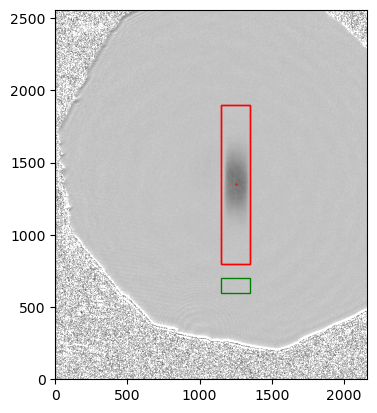

Displaying image: 
/Users/huanbui/Desktop/sample_data/box_exp_RF12_32ms_post/1272047_2023-03-16--14-04-13_TopB.fits

Frame type: FakeOD


In [69]:
# initializes data frame and load metadata & exp params:
df_compressibility, metadata_dict_compressibility, experiment_parameters_dict_compressibility = init_dataframe_metadata_and_exp_params(['RF12_Time'])

ROI_compressibility = [1150, 1350, 800, 1900] # xmin, xmax, ymin, ymax
norm_box_compressibility = [1150, 1350, 600, 700] # xmin, xmax, ymin, ymax

# display image:
frame_type_compressibility = 'FakeOD'
current_file_fullpath_compressibility = df_compressibility['fullpaths'][1]
fig, ax = display_image(current_file_fullpath_compressibility, 
                        ROI_compressibility, 
                        norm_box_compressibility, 
                        frame_type_compressibility)
#################################################
print('Displaying image: ')
print(current_file_fullpath_compressibility)
print('')
print('Frame type: ' + frame_type_compressibility)

In [70]:
# add od_roi and od_norm_box to dataframe, then column densities
df_compressibility = add_background_subtracted_ROI_to_dataframe_fast(df_compressibility, 
                                                                           ROI_compressibility, 
                                                                           norm_box_compressibility)
# get column densities
df_compressibility = add_polrot_column_densities_to_dataframe(df_compressibility, 
                                                                     experiment_parameters_dict_compressibility, 
                                                                     ROI_compressibility)

Solving images:   0%|          | 0/8 [00:00<?, ?it/s]/Users/huanbui/anaconda3/envs/BEC1_Calculator/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/huanbui/anaconda3/envs/BEC1_Calculator/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/huanbui/anaconda3/envs/BEC1_Calculator/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/huanbui/anaconda3/envs/BEC1_Calculator/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration i

Tilt angle: 0.0 degrees
Column density justified
n3D along harmonic axis added.
Harmonic trap centers added.
Energy added.


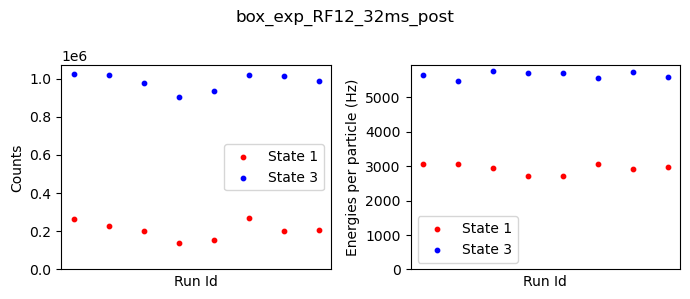

--- Counts and Energies per particle ---
Mean State 1 count:        208310.32
Stdev state 1 count:       43311.00
Mean State 3 count:        984914.80
Stdev state 3 count:       42122.32
Mean State 1 energy (Hz):  2934.74
Stdev state 1 energy (Hz): 134.22
Mean State 3 energy (Hz):  5646.58
Stdev state 3 energy (Hz): 96.17
Mean weighted energy (Hz): 5182.15
Std weighted energy (Hz):  110.11
Average imbalance:         0.65
Stdev imbalance:           0.05


In [71]:
# get counts, energies, etc.
compressibility_result_dict = get_counts_energies_and_vars_from_hybrid_top_PR(df_compressibility, 
                                                                             experiment_parameters_dict_compressibility, 
                                                                             extra_var = '')

df_compressibility                     = compressibility_result_dict['df']
counts_A_compressibility               = compressibility_result_dict['counts_A']
counts_B_compressibility               = compressibility_result_dict['counts_B']
energies_A_compressibility             = compressibility_result_dict['energies_A']
energies_B_compressibility             = compressibility_result_dict['energies_B']
RF12_Times_compressibility             = compressibility_result_dict['RF12_Times']
run_ids_compressibility                = compressibility_result_dict['run_ids']
fig_compressibility                    = compressibility_result_dict['figure']
imbalance_compressibility              = compressibility_result_dict['imbalance']
weighted_avg_energy_compressibility    = compressibility_result_dict['weighted_average_energy']

In [72]:
df_compressibility

,fullpaths,good_shot,run_id,image_type,ImagFreq1,ImagFreq2,LFImgFreq,RF12_Time,fakeOD_roi,column_density,atom_count,justified_column_density,n3D_along_harmonic_ax,hybrid_harmonic_trap_center,E_hz_pp_from_ax_trap,ax_trap_boundary
0,/Users/huanbui/Desktop/sample_data/box_exp_RF1...,True,1272047,TopA,156.24,236.67,185.5,32.0,"[[1.0884832222734382, 1.0857712606685357, 0.92...","[[-9120624541551.441, -8002387366235.479, 7363...",2.669422e+05,"[[-9120624541551.441, -8002387366235.479, 7363...","[-0.006403114684212636, -0.0026863670897681225...",565,3053.042649,"[332, 805]"
1,/Users/huanbui/Desktop/sample_data/box_exp_RF1...,True,1272047,TopB,156.24,236.67,185.5,32.0,"[[1.037306821163576, 0.957705691752798, 1.0159...","[[-2917923179465.0522, 5010829622192.84, -2264...",1.025104e+06,"[[-2917923179465.0522, 5010829622192.84, -2264...","[-0.003806961129061983, -0.00196306684582601, ...",560,5633.985215,"[220, 884]"
2,/Users/huanbui/Desktop/sample_data/box_exp_RF1...,True,1272050,TopA,156.24,236.67,185.5,32.0,"[[1.0261492558572698, 1.0620687884303683, 0.95...","[[-3701499343367.551, -6933455017145.746, 2849...",2.273466e+05,"[[-3701499343367.551, -6933455017145.746, 2849...","[-0.0071261740174178795, -0.004158395421724213...",563,3074.892795,"[334, 790]"
3,/Users/huanbui/Desktop/sample_data/box_exp_RF1...,True,1272050,TopB,156.24,236.67,185.5,32.0,"[[1.1033888419989284, 1.074635105656092, 1.116...","[[-9943440199971.135, -6821552192943.071, -118...",1.018767e+06,"[[-9943440199971.135, -6821552192943.071, -118...","[0.004729448536948013, 0.0033402287612551615, ...",559,5470.001559,"[229, 873]"
4,/Users/huanbui/Desktop/sample_data/box_exp_RF1...,True,1272052,TopA,156.24,236.67,185.5,32.0,"[[1.0546286042348205, 0.9946782704013355, 1.09...","[[-5294493119447.423, 1849623961943.0566, -862...",1.996312e+05,"[[-5294493119447.423, 1849623961943.0566, -862...","[0.0006360360166247955, -0.004540366070308514,...",565,2952.627233,"[331, 797]"
5,/Users/huanbui/Desktop/sample_data/box_exp_RF1...,True,1272052,TopB,156.24,236.67,185.5,32.0,"[[0.9895024559526625, 0.8808462303710686, 0.96...","[[1537029548410.5178, 12052702389123.137, 4647...",9.756013e+05,"[[1537029548410.5178, 12052702389123.137, 4647...","[-0.0025831188978573906, -0.004496951584382392...",559,5774.626044,"[215, 889]"
6,/Users/huanbui/Desktop/sample_data/box_exp_RF1...,True,1272055,TopA,156.24,236.67,185.5,32.0,"[[0.8608907864979247, 0.9882079188963696, 1.03...","[[13912268257931.482, -35557268303.55918, -253...",1.384392e+05,"[[13912268257931.482, -35557268303.55918, -253...","[-0.00920388307533946, -0.0065706344791709535,...",565,2721.235766,"[353, 773]"
7,/Users/huanbui/Desktop/sample_data/box_exp_RF1...,True,1272055,TopB,156.24,236.67,185.5,32.0,"[[1.0239434124945126, 1.113160682794159, 0.945...","[[-3654837944784.9585, -11228413147303.926, 57...",9.027847e+05,"[[-3654837944784.9585, -11228413147303.926, 57...","[0.00790625464405718, -0.002465499760376149, -...",558,5700.419064,"[224, 887]"
8,/Users/huanbui/Desktop/sample_data/box_exp_RF1...,True,1272060,TopA,156.24,236.67,185.5,32.0,"[[1.0414572087410046, 0.9909334958153695, 0.93...","[[-6123410733215.337, 1427357005105.8494, 6500...",1.567092e+05,"[[-6123410733215.337, 1427357005105.8494, 6500...","[0.004934344152884219, -0.0051972245282945655,...",563,2724.347640,"[344, 779]"
9,/Users/huanbui/Desktop/sample_data/box_exp_RF1...,True,1272060,TopB,156.24,236.67,185.5,32.0,"[[1.190748266141122, 0.9522906984702163, 1.007...","[[-18239406173924.285, 4707723443397.027, -136...",9.345776e+05,"[[-18239406173924.285, 4707723443397.027, -136...","[0.0006166140702628736, -0.004974918402021027,...",560,5708.001323,"[224, 889]"


[26668.87450416 26574.55495113 26480.40248323 ... 23644.55020022
 23733.52302925 23822.6629434 ]


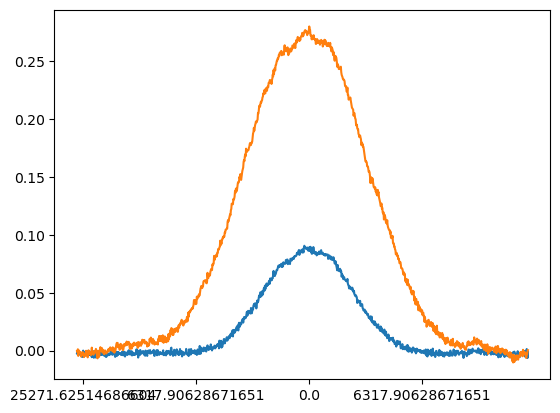

In [85]:
z = np.arange(abs(ROI_compressibility[2] - ROI_compressibility[3]))
z = z - df_compressibility['hybrid_harmonic_trap_center'].iloc[0]
axial_trap_frequency_hz = experiment_parameters_dict_compressibility['Values']['axial_trap_frequency_hz']
top_um_per_pixel =  experiment_parameters_dict_compressibility['Values']['top_um_per_pixel']
Uz_hz = ((mLi6 * (2*np.pi*axial_trap_frequency_hz)**2 * (z*top_um_per_pixel*1e-6)**2)/2 ) / (2*np.pi*hbar)

print(Uz_hz)

plt.plot(z, df_compressibility[df_compressibility['image_type']=='TopA']['n3D_along_harmonic_ax'].mean())
plt.plot(z, df_compressibility[df_compressibility['image_type']=='TopB']['n3D_along_harmonic_ax'].mean())
plt.xticks(z, Uz_hz)
plt.locator_params(axis='x', nbins=4)
plt.show()

# <font size=5, color='black'>Li Hybrid Top: Box Exp - Mixed RF (PR)</font>

## <font size=3, color=#399FD5>Data preview and preparation</font>

In [ ]:
# initializes data frame and load metadata & exp params:
data_frame_Box_Exp_mixedRF, metadata_dict_Box_Exp_mixedRF, experiment_parameters_dict_Box_Exp_mixedRF = init_dataframe_metadata_and_exp_params(['RF12_Time'])

# ROI Box
ROI_Box_Exp_mixedRF = [1150, 1350, 900, 1800] # y max
# Norm box
norm_box_Box_Exp_mixedRF = [1150, 1350, 700, 800] # y max
# display image:
frame_type_Box_Exp_mixedRF = 'FakeOD'
current_file_fullpath_Box_Exp_mixedRF = data_frame_Box_Exp_mixedRF['fullpaths'][1]
fig, ax = display_image(current_file_fullpath_Box_Exp_mixedRF, 
                        ROI_Box_Exp_mixedRF, 
                        norm_box_Box_Exp_mixedRF, 
                        frame_type_Box_Exp_mixedRF)
#################################################
print('Displaying image: ')
print(current_file_fullpath_Box_Exp_mixedRF)
print('')
print('Frame type: ' + frame_type_Box_Exp_mixedRF)

## <font size=3, color=#399FD5>Analyze</font>

In [ ]:
# add od_roi and od_norm_box to dataframe, then get column densities
data_frame_Box_Exp_mixedRF = add_background_subtracted_ROI_to_dataframe_fast(data_frame_Box_Exp_mixedRF, 
                                                                           ROI_Box_Exp_mixedRF, 
                                                                           norm_box_Box_Exp_mixedRF)
# get column densities
data_frame_Box_Exp_mixedRF = add_polrot_column_densities_to_dataframe(data_frame_Box_Exp_mixedRF, 
                                                                     experiment_parameters_dict_Box_Exp_mixedRF, 
                                                                     ROI_Box_Exp_mixedRF)

In [ ]:
# get counts, tilt, and energies, etc.
data_frame_Box_Exp_mixedRF = add_counts_from_PR_column_densities_to_dataframe(data_frame_Box_Exp_mixedRF, 
                                                                             experiment_parameters_dict_Box_Exp_mixedRF)
# tilt, add n3d along harmonic axis, find trap center and add boundary of cloud to get Energy
data_frame_Box_Exp_mixedRF = add_justified_column_density_to_dataframe(data_frame_Box_Exp_mixedRF, 
                                                                         experiment_parameters_dict_Box_Exp_mixedRF)
data_frame_Box_Exp_mixedRF = add_n3d_along_harmonic_axis_to_dataframe(data_frame_Box_Exp_mixedRF, 
                                                                     experiment_parameters_dict_Box_Exp_mixedRF)
data_frame_Box_Exp_mixedRF = add_hybrid_harmonic_trap_centers_to_dataframe(data_frame_Box_Exp_mixedRF)
# add energies (from expansion into harmonic axial trap)
data_frame_Box_Exp_mixedRF = add_energy_from_hybrid_expansion_to_dataframe(data_frame_Box_Exp_mixedRF, 
                                                                          experiment_parameters_dict_Box_Exp_mixedRF)

# FILTER DATA
data_frame_Box_Exp_mixedRF = data_filter(data_frame_Box_Exp_mixedRF, 'atom_count', 1.5, ['image_type','TopA'])
data_frame_Box_Exp_mixedRF = data_filter(data_frame_Box_Exp_mixedRF, 'atom_count', 1.5, ['image_type','TopB'])

In [ ]:
# report results for RF12_1
# now get counts, energies versus run_id for HeatCycles = 0
counts_A_RF12_1 = data_frame_Box_Exp_mixedRF[(data_frame_Box_Exp_mixedRF['image_type'] == 'TopA') & 
                                             (data_frame_Box_Exp_mixedRF['RF12_Time'] == 11) & 
                                             (data_frame_Box_Exp_mixedRF['good_shot'] == True)]['atom_count']
counts_B_RF12_1 = data_frame_Box_Exp_mixedRF[(data_frame_Box_Exp_mixedRF['image_type'] == 'TopB') & 
                                             (data_frame_Box_Exp_mixedRF['RF12_Time'] == 11) & 
                                             (data_frame_Box_Exp_mixedRF['good_shot'] == True)]['atom_count']
energies_A_RF12_1 = data_frame_Box_Exp_mixedRF[(data_frame_Box_Exp_mixedRF['image_type'] == 'TopA') & 
                                               (data_frame_Box_Exp_mixedRF['RF12_Time'] == 11) & 
                                               (data_frame_Box_Exp_mixedRF['good_shot'] == True)]['E_hz_pp_from_ax_trap']
energies_B_RF12_1 = data_frame_Box_Exp_mixedRF[(data_frame_Box_Exp_mixedRF['image_type'] == 'TopB') & 
                                               (data_frame_Box_Exp_mixedRF['RF12_Time'] == 11) & 
                                               (data_frame_Box_Exp_mixedRF['good_shot'] == True)]['E_hz_pp_from_ax_trap']
run_ids_RF12_1 = data_frame_Box_Exp_mixedRF[(data_frame_Box_Exp_mixedRF['image_type'] == 'TopA') & 
                                            (data_frame_Box_Exp_mixedRF['RF12_Time'] == 11) & 
                                            (data_frame_Box_Exp_mixedRF['good_shot'] == True)]['run_id']

fig_Box_Exp_RF12_1 = plt.figure(figsize=(7,3))
ax_Box_Exp_RF12_1_counts = fig_Box_Exp_RF12_1.add_subplot(121)

# plot counts vs Run Id
pr1_Box_Exp_RF12_1 = ax_Box_Exp_RF12_1_counts.scatter(run_ids_RF12_1, counts_A_RF12_1, color = 'red' , s = 10)
pr2_Box_Exp_RF12_1 = ax_Box_Exp_RF12_1_counts.scatter(run_ids_RF12_1, counts_B_RF12_1, color = 'blue', s = 10)

ax_Box_Exp_RF12_1_counts.legend([pr1_Box_Exp_RF12_1, pr2_Box_Exp_RF12_1],['State 1', 'State 3'])
fig_Box_Exp_RF12_1.autofmt_xdate()
ax_Box_Exp_RF12_1_counts.set_xticks([])
ax_Box_Exp_RF12_1_counts.set_ylim(ymin=0)
plt.xlabel('Run Id')
plt.ylabel('Counts')

# plot energies vs run id
ax_Box_Exp_RF12_1_energies = fig_Box_Exp_RF12_1.add_subplot(122)
e1_Box_Exp_RF12_1 = ax_Box_Exp_RF12_1_energies.scatter(run_ids_RF12_1, energies_A_RF12_1, color = 'red', s = 10)
e2_Box_Exp_RF12_1 = ax_Box_Exp_RF12_1_energies.scatter(run_ids_RF12_1, energies_B_RF12_1, color = 'blue', s = 10)
ax_Box_Exp_RF12_1_energies.legend([e1_Box_Exp_RF12_1, e2_Box_Exp_RF12_1],['State 1', 'State 3'])
fig_Box_Exp_RF12_1.autofmt_xdate()
ax_Box_Exp_RF12_1_energies.set_xticks([])
ax_Box_Exp_RF12_1_energies.set_ylim(ymin=0)
plt.xlabel('Run Id')
plt.ylabel('Energies per particle (Hz)')

# add title to figure:
folder_name = os.path.basename(os.path.dirname(data_frame_Box_Exp_mixedRF['fullpaths'][0]))
fig_Box_Exp_RF12_1.suptitle(folder_name)
fig_Box_Exp_RF12_1.tight_layout()
plt.show()

# calculate imbalance vs Run Id
counts_A_RF12_1 = np.array(counts_A_RF12_1)
counts_B_RF12_1 = np.array(counts_B_RF12_1)
energies_A_RF12_1 = np.array(energies_A_RF12_1)
energies_B_RF12_1 = np.array(energies_B_RF12_1)
imbalance_RF12_1 = (counts_B_RF12_1 - counts_A_RF12_1)/(counts_B_RF12_1 + counts_A_RF12_1)
weighted_avg_energy_RF12_1 = (energies_A_RF12_1*counts_A_RF12_1 + energies_B_RF12_1*counts_B_RF12_1)/(counts_A_RF12_1 + counts_B_RF12_1)

#### statistics report ####
print('--- Counts and Energies per particle (RF12_1) ---')
print('Mean State 1 count:        ' + str("{:.2f}".format(np.mean(counts_A_RF12_1))))
print('Stdev state 1 count:       ' + str("{:.2f}".format(np.std(counts_A_RF12_1))))
print('Mean State 3 count:        ' + str("{:.2f}".format(np.mean(counts_B_RF12_1))))
print('Stdev state 3 count:       ' + str("{:.2f}".format(np.std(counts_B_RF12_1))))
print('Mean State 1 energy (Hz):  ' + str("{:.2f}".format(np.mean(energies_A_RF12_1))))
print('Stdev state 1 energy (Hz): ' + str("{:.2f}".format(np.std(energies_A_RF12_1))))
print('Mean State 3 energy (Hz):  ' + str("{:.2f}".format(np.mean(energies_B_RF12_1))))
print('Stdev state 3 energy (Hz): ' + str("{:.2f}".format(np.std(energies_B_RF12_1))))
print('Mean weighted energy (Hz): ' + str("{:.2f}".format(np.mean(weighted_avg_energy_RF12_1))))
print('Std weighted energy (Hz):  ' + str("{:.2f}".format(np.std(weighted_avg_energy_RF12_1))))
# print average imbalance:
print('Average imbalance:         ' + str("{:.2f}".format(np.mean(imbalance_RF12_1))))
print('Std imbalance:             ' + str("{:.2f}".format(np.std(imbalance_RF12_1))))
# print RF12 Time:
RF12_Time_RF12_1 = 11
print('RF12 Time (ms):            ' + str("{:.2f}".format(RF12_Time_RF12_1)))

In [ ]:
# report results for RF12_2
# now get counts, energies versus run_id for HeatCycles = 0
counts_A_RF12_2 = data_frame_Box_Exp_mixedRF[(data_frame_Box_Exp_mixedRF['image_type'] == 'TopA') & 
                                             (data_frame_Box_Exp_mixedRF['RF12_Time'] == 32) & 
                                             (data_frame_Box_Exp_mixedRF['good_shot'] == True)]['atom_count']
counts_B_RF12_2 = data_frame_Box_Exp_mixedRF[(data_frame_Box_Exp_mixedRF['image_type'] == 'TopB') & 
                                             (data_frame_Box_Exp_mixedRF['RF12_Time'] == 32) & 
                                             (data_frame_Box_Exp_mixedRF['good_shot'] == True)]['atom_count']
energies_A_RF12_2 = data_frame_Box_Exp_mixedRF[(data_frame_Box_Exp_mixedRF['image_type'] == 'TopA') & 
                                               (data_frame_Box_Exp_mixedRF['RF12_Time'] == 32) & 
                                               (data_frame_Box_Exp_mixedRF['good_shot'] == True)]['E_hz_pp_from_ax_trap']
energies_B_RF12_2 = data_frame_Box_Exp_mixedRF[(data_frame_Box_Exp_mixedRF['image_type'] == 'TopB') & 
                                               (data_frame_Box_Exp_mixedRF['RF12_Time'] == 32) & 
                                               (data_frame_Box_Exp_mixedRF['good_shot'] == True)]['E_hz_pp_from_ax_trap']
run_ids_RF12_2 = data_frame_Box_Exp_mixedRF[(data_frame_Box_Exp_mixedRF['image_type'] == 'TopA') & 
                                            (data_frame_Box_Exp_mixedRF['RF12_Time'] == 32) & 
                                            (data_frame_Box_Exp_mixedRF['good_shot'] == True)]['run_id']

fig_Box_Exp_RF12_2 = plt.figure(figsize=(7,3))
ax_Box_Exp_RF12_2_counts = fig_Box_Exp_RF12_2.add_subplot(121)

# plot counts vs Run Id
pr1_Box_Exp_RF12_2 = ax_Box_Exp_RF12_2_counts.scatter(run_ids_RF12_2, counts_A_RF12_2, color = 'red' , s = 10)
pr2_Box_Exp_RF12_2 = ax_Box_Exp_RF12_2_counts.scatter(run_ids_RF12_2, counts_B_RF12_2, color = 'blue', s = 10)

ax_Box_Exp_RF12_2_counts.legend([pr1_Box_Exp_RF12_2, pr2_Box_Exp_RF12_2],['State 1', 'State 3'])
fig_Box_Exp_RF12_2.autofmt_xdate()
ax_Box_Exp_RF12_2_counts.set_xticks([])
ax_Box_Exp_RF12_2_counts.set_ylim(ymin=0)
plt.xlabel('Run Id')
plt.ylabel('Counts')

# plot energies vs run id
ax_Box_Exp_RF12_2_energies = fig_Box_Exp_RF12_2.add_subplot(122)
e1_Box_Exp_RF12_2 = ax_Box_Exp_RF12_2_energies.scatter(run_ids_RF12_2, energies_A_RF12_2, color = 'red', s = 10)
e2_Box_Exp_RF12_2 = ax_Box_Exp_RF12_2_energies.scatter(run_ids_RF12_2, energies_B_RF12_2, color = 'blue', s = 10)
ax_Box_Exp_RF12_2_energies.legend([e1_Box_Exp_RF12_2, e2_Box_Exp_RF12_2],['State 1', 'State 3'])
fig_Box_Exp_RF12_2.autofmt_xdate()
ax_Box_Exp_RF12_2_energies.set_xticks([])
ax_Box_Exp_RF12_2_energies.set_ylim(ymin=0)
plt.xlabel('Run Id')
plt.ylabel('Energies per particle (Hz)')

# add title to figure:
folder_name = os.path.basename(os.path.dirname(data_frame_Box_Exp_mixedRF['fullpaths'][0]))
fig_Box_Exp_RF12_2.suptitle(folder_name)
fig_Box_Exp_RF12_2.tight_layout()
plt.show()

# calculate imbalance vs Run Id
counts_A_RF12_2 = np.array(counts_A_RF12_2)
counts_B_RF12_2 = np.array(counts_B_RF12_2)
energies_A_RF12_2 = np.array(energies_A_RF12_2)
energies_B_RF12_2 = np.array(energies_B_RF12_2)
imbalance_RF12_2 = (counts_B_RF12_2 - counts_A_RF12_2)/(counts_B_RF12_2 + counts_A_RF12_2)
weighted_avg_energy_RF12_2 = (energies_A_RF12_2*counts_A_RF12_2 + energies_B_RF12_2*counts_B_RF12_2)/(counts_A_RF12_2 + counts_B_RF12_2)

#### statistics report ####
print('--- Counts and Energies per particle (RF12_2) ---')
print('Mean State 1 count:        ' + str("{:.2f}".format(np.mean(counts_A_RF12_2))))
print('Stdev state 1 count:       ' + str("{:.2f}".format(np.std(counts_A_RF12_2))))
print('Mean State 3 count:        ' + str("{:.2f}".format(np.mean(counts_B_RF12_2))))
print('Stdev state 3 count:       ' + str("{:.2f}".format(np.std(counts_B_RF12_2))))
print('Mean State 1 energy (Hz):  ' + str("{:.2f}".format(np.mean(energies_A_RF12_2))))
print('Stdev state 1 energy (Hz): ' + str("{:.2f}".format(np.std(energies_A_RF12_2))))
print('Mean State 3 energy (Hz):  ' + str("{:.2f}".format(np.mean(energies_B_RF12_2))))
print('Stdev state 3 energy (Hz): ' + str("{:.2f}".format(np.std(energies_B_RF12_2))))
print('Mean weighted energy (Hz): ' + str("{:.2f}".format(np.mean(weighted_avg_energy_RF12_2))))
print('Std weighted energy (Hz):  ' + str("{:.2f}".format(np.std(weighted_avg_energy_RF12_2))))
# print average imbalance:
print('Average imbalance:         ' + str("{:.2f}".format(np.mean(imbalance_RF12_2))))
print('Std imbalance:             ' + str("{:.2f}".format(np.std(imbalance_RF12_2))))
# print RF12 Time:
RF12_Time_RF12_2 = 32
print('RF12 Time (ms):            ' + str("{:.2f}".format(RF12_Time_RF12_2)))

# <font size=5, color='black'>Li Box Top: Sound Scan (PR) </font>

## <font size=3, color=#399FD5>Load existing dataframe</font>

In [ ]:
# load existing df
df_file_name = filedialog.askopenfilename()
data_frame_Sound_Scan_PR = pd.read_pickle(df_file_name)

folder_path = os.path.dirname(df_file_name)
metadata_fullpath = folder_path + "/run_params_dump.json"
experiment_parameters_fullpath = folder_path + "/experiment_parameters.json"

with open(metadata_fullpath, 'r') as json_file:
    metadata_dict_Sound_Scan_PR = json.load(json_file)  
with open(experiment_parameters_fullpath, 'r') as json_file:
    experiment_parameters_dict_Sound_Scan_PR = json.load(json_file) 

## <font size=3, color=#399FD5>Data preview and preparation</font>

In [ ]:
# initializes data frame and load metadata & exp params:
data_frame_Sound_Scan_PR, metadata_dict_Sound_Scan_PR, experiment_parameters_dict_Sound_Scan_PR = init_dataframe_metadata_and_exp_params(['RF12_Time', 
                                                                                                                                          'ShakingCycles', 
                                                                                                                                          'BoxShakeFreq'])
# xmin, xmax, ymin, ymax
ROI_Sound_Scan_PR = [1150, 1350, 1245, 1455] # to get counts right...
norm_box_Sound_Scan_PR = [1150, 1300, 1000, 1100]

# display image:
frame_type_Sound_Scan_PR = 'FakeOD'
current_file_fullpath_Sound_Scan_PR = data_frame_Sound_Scan_PR['fullpaths'][0]
fig, ax = display_image(current_file_fullpath_Sound_Scan_PR, 
                        ROI_Sound_Scan_PR, 
                        norm_box_Sound_Scan_PR, 
                        frame_type_Sound_Scan_PR)

#################################################
print('Displaying image: ')
print(current_file_fullpath_Sound_Scan_PR)
print('')
print('Frame type: ' + frame_type_Sound_Scan_PR)

## <font size=3, color=#399FD5>Get column densities, counts, imbalance, filter data, justify, get n3D(z), get Fermi energies </font>

In [ ]:
# get column densities from PR solver
data_frame_Sound_Scan_PR = add_background_subtracted_ROI_to_dataframe_fast(data_frame_Sound_Scan_PR, 
                                                                           ROI_Sound_Scan_PR, 
                                                                           norm_box_Sound_Scan_PR)
# get column densities
data_frame_Sound_Scan_PR = add_polrot_column_densities_to_dataframe(data_frame_Sound_Scan_PR, 
                                                                     experiment_parameters_dict_Sound_Scan_PR, 
                                                                     ROI_Sound_Scan_PR)

In [ ]:
# get counts, filter data, justify images, get n3D(z), then get box boundary
data_frame_Sound_Scan_PR = add_counts_from_PR_column_densities_to_dataframe(data_frame_Sound_Scan_PR, 
                                                                             experiment_parameters_dict_Sound_Scan_PR)
# FILTER DATA
data_frame_Sound_Scan_PR = data_filter(data_frame_Sound_Scan_PR, 'atom_count', 1.5, ['image_type','TopA'])
data_frame_Sound_Scan_PR = data_filter(data_frame_Sound_Scan_PR, 'atom_count', 1.5, ['image_type','TopB'])
   
# plot unfiltered and filtered data:    
fig_sound_scan_counts_unfiltered = plot_box_counts_and_imbalance(data_frame_Sound_Scan_PR, filter=False)
fig_sound_scan_counts_filtered = plot_box_counts_and_imbalance(data_frame_Sound_Scan_PR, filter=True)

# justify images
data_frame_Sound_Scan_PR = add_justified_column_density_to_dataframe(data_frame_Sound_Scan_PR, experiment_parameters_dict_Sound_Scan_PR)
# plt.imshow(data_frame_Sound_Scan_PR['justified_column_density'][0])
# plt.show()

# add n3d along harmonic axis of hybrid trap to df
data_frame_Sound_Scan_PR = add_n3d_along_harmonic_axis_to_dataframe(data_frame_Sound_Scan_PR, experiment_parameters_dict_Sound_Scan_PR)

# get box boundary along z
data_frame_Sound_Scan_PR = add_box_boundary_with_sigmoid_along_z_to_dataframe(data_frame_Sound_Scan_PR, cut_depth=0.5)

# get Fermi energies:
data_frame_Sound_Scan_PR, avg_EF_sound_scan_A, avg_EF_sound_scan_B = add_box_Fermi_energy_to_dataframe(data_frame_Sound_Scan_PR, print_result = True, filter = True)

## <font size=3, color=#399FD5>Subtract no-shake from shake</font>

In [ ]:
# subtract no-shake from shake
# extract the no shaking justified_column_densities:
if 'justified_column_density' in data_frame_Sound_Scan_PR.columns:
    no_shake_justified_density_A = data_frame_Sound_Scan_PR[(data_frame_Sound_Scan_PR['image_type'] == 'TopA') & 
                                                            (data_frame_Sound_Scan_PR['ShakingCycles'] == 0)]['justified_column_density']
    no_shake_justified_density_B = data_frame_Sound_Scan_PR[(data_frame_Sound_Scan_PR['image_type'] == 'TopB') & 
                                                            (data_frame_Sound_Scan_PR['ShakingCycles'] == 0)]['justified_column_density']    

# now take average of all no shake shots:
avg_no_shake_justified_density_A = sum(no_shake_justified_density_A)/len(no_shake_justified_density_A)
avg_no_shake_justified_density_B = sum(no_shake_justified_density_B)/len(no_shake_justified_density_B)

# now subtract shake from no shake:
no_shake_subtracted = []
for idx, row in data_frame_Sound_Scan_PR.iterrows():
    if row['image_type'] == 'TopA':
        no_shake_subtracted.append(row['justified_column_density'] - avg_no_shake_justified_density_A)
    if row['image_type'] == 'TopB':
        no_shake_subtracted.append(row['justified_column_density'] - avg_no_shake_justified_density_B)
data_frame_Sound_Scan_PR['no_shake_subtracted'] = no_shake_subtracted
        
# show a no_shake_subtracted shot:
plt.imshow(data_frame_Sound_Scan_PR['no_shake_subtracted'][1])
plt.show()

# now get subtracted 3d density along harmonic axis
data_frame_Sound_Scan_PR = add_delta_n3d_with_no_shake_subtracted_to_dataframe(data_frame_Sound_Scan_PR, experiment_parameters_dict_Sound_Scan_PR)

## <font size=3, color=#399FD5>Show sound resonance curve and fit</font>

In [ ]:
# show sound resonance curve and fit
sound_resonance_results = first_sound_resonance_curve_fit(data_frame_Sound_Scan_PR, symmetric_mode = 1, fit = True, real = True, normalize = False, with_offset = False)

fig_sound_resonance = sound_resonance_results['figure']
center_A            = sound_resonance_results['center_A']
gamma_A             = sound_resonance_results['gamma_A'] 
center_B            = sound_resonance_results['center_B']
gamma_B             = sound_resonance_results['gamma_B'] 
center_A_error      = sound_resonance_results['center_A_error']
center_B_error      = sound_resonance_results['center_B_error']
gamma_A_error       = sound_resonance_results['gamma_A_error']
gamma_B_error       = sound_resonance_results['gamma_B_error']

In [ ]:
# do the same, but with delta n/n instead of just delta_n/n
data_frame_Sound_Scan_PR = add_delta_n3d_over_n3d_along_z_to_dataframe(data_frame_Sound_Scan_PR, 
                                                                       experiment_parameters_dict_Sound_Scan_PR,
                                                                       avg_no_shake_justified_density_A, 
                                                                       avg_no_shake_justified_density_B)

# taking the real part helps with distilling the symmetric mode better
sound_resonance_results_normed = first_sound_resonance_curve_fit(data_frame_Sound_Scan_PR, symmetric_mode = 1, fit = True, real = True, normalize = True, with_offset=False)

fig_sound_resonance_normed = sound_resonance_results_normed['figure']
center_A_normed            = sound_resonance_results_normed['center_A']
gamma_A_normed             = sound_resonance_results_normed['gamma_A'] 
center_B_normed            = sound_resonance_results_normed['center_B']
gamma_B_normed             = sound_resonance_results_normed['gamma_B'] 
center_A_error_normed      = sound_resonance_results_normed['center_A_error']
center_B_error_normed      = sound_resonance_results_normed['center_B_error']
gamma_A_error_normed       = sound_resonance_results_normed['gamma_A_error']
gamma_B_error_normed       = sound_resonance_results_normed['gamma_B_error']

## <font size=3, color=#399FD5>Save dataframe and results associated with data folder</font>

In [ ]:
# save df and results 
folder_name = os.path.basename(os.path.dirname(data_frame_Sound_Scan_PR['fullpaths'][0]))
today = str(datetime.date.today())
path = "/Users/huanbui/Desktop/BEC1_dataframes/"
# make directory if it's not there yet
path_name = path+today+'/'+folder_name+'/'
if os.path.isdir(path+today) == False:
    os.mkdir(path+today)
if os.path.isdir(path_name) == False:
    os.mkdir(path_name)
file_name = path_name + folder_name + ".pkl"
metadata_name = path_name + 'run_params_dump.json'
run_params_name = path_name + 'experiment_parameters.json'
 
# save dataframe as file_name:
data_frame_Sound_Scan_PR.to_pickle(file_name)

# also save metadata and exp params:
with open(metadata_name, 'w') as fp:
    json.dump(metadata_dict_Sound_Scan_PR, fp)
with open(run_params_name, 'w') as fp:
    json.dump(experiment_parameters_dict_Sound_Scan_PR, fp)
    
# save images:
fig_sound_scan_counts_unfiltered.savefig(path_name+'counts_and_imbalances_unfiltered.png')
fig_sound_scan_counts_filtered.savefig(path_name+'counts_and_imbalances_filtered.png')
fig_sound_resonance.savefig(path_name+'sound_resonance_fit.png')
fig_sound_resonance_normed.savefig(path_name+'sound_resonance_normed_fit.png')

# save numerical results as txt file:
counts_A_Sound_Scan_PR = data_frame_Sound_Scan_PR[data_frame_Sound_Scan_PR['image_type']=='TopA']['atom_count']
counts_B_Sound_Scan_PR = data_frame_Sound_Scan_PR[data_frame_Sound_Scan_PR['image_type']=='TopB']['atom_count']
counts_A_Sound_Scan_PR = np.array(counts_A_Sound_Scan_PR)
counts_B_Sound_Scan_PR = np.array(counts_B_Sound_Scan_PR)

imbalance_Sound_Scan_PR = (counts_B_Sound_Scan_PR-counts_A_Sound_Scan_PR)/(counts_A_Sound_Scan_PR+counts_B_Sound_Scan_PR)

with open(path_name+folder_name+ '_results.txt', 'w') as f:
    f.write('--- Counts, Energies per particle, and Fermi Energies ---' + "\n")
    f.write('Mean State 1 count:        ' + str("{:.2f}".format(np.mean(counts_A_Sound_Scan_PR))) + "\n")
    f.write('Stdev state 1 count:       ' + str("{:.2f}".format(np.std(counts_A_Sound_Scan_PR))) + "\n")
    f.write('Mean State 1 Fermi energy: ' + str("{:.2f}".format(avg_EF_sound_scan_A)) + "\n")
    f.write('Mean State 3 count:        ' + str("{:.2f}".format(np.mean(counts_B_Sound_Scan_PR))) + "\n")
    f.write('Stdev state 3 count:       ' + str("{:.2f}".format(np.std(counts_B_Sound_Scan_PR))) + "\n")
    f.write('Mean State 3 Fermi energy: ' + str("{:.2f}".format(avg_EF_sound_scan_B)) + "\n")
    f.write("\n")
    f.write('Mean imbalance:            ' + str("{:.2f}".format(np.mean(imbalance_Sound_Scan_PR))) + "\n")
    f.write('Std imbalance:             ' + str("{:.2f}".format(np.std(imbalance_Sound_Scan_PR))) + "\n")
    f.write("\n")
    f.write('--- Sound resonance fit ---' + "\n")
    f.write('Center A (Hz):       ' + str("{:.2f}".format(center_A)) + "\n")
    f.write('Center A error (Hz): ' + str("{:.2f}".format(center_A_error)) + "\n")
    f.write('Gamma A (Hz):        ' + str("{:.2f}".format(gamma_A)) + "\n")
    f.write('Gamma A error (Hz):  ' + str("{:.2f}".format(gamma_A_error)) + "\n")
    f.write('Center B (Hz):       ' + str("{:.2f}".format(center_B)) + "\n")
    f.write('Center B error (Hz): ' + str("{:.2f}".format(center_B_error)) + "\n")
    f.write('Gamma B (Hz):        ' + str("{:.2f}".format(gamma_B)) + "\n")
    f.write('Gamma B error (Hz):  ' + str("{:.2f}".format(gamma_B_error)) + "\n")
    
print('Results and images saved!')

# <font size = 5, color='black'> Li Box Top: Sound Scan with Mixed Heating (PR) </font>

## <font size=4, color=#399FD5>Load existing dataframe</font>

In [ ]:
# load existing dataframe
df_file_name = filedialog.askopenfilename()
df_sound_mixedheat = pd.read_pickle(df_file_name)

folder_path = os.path.dirname(df_file_name)
metadata_fullpath = folder_path + "/run_params_dump.json"
experiment_parameters_fullpath = folder_path + "/experiment_parameters.json"

with open(metadata_fullpath, 'r') as json_file:
    metadata_dict_sound_mixedheat = json.load(json_file)  
with open(experiment_parameters_fullpath, 'r') as json_file:
    experiment_parameters_dict_sound_mixedheat = json.load(json_file) 

## <font size=3, color=#399FD5>Data preview and preparation</font>

In [ ]:
# initializes data frame and load metadata & exp params:
df_sound_mixedheat, metadata_dict_sound_mixedheat, experiment_parameters_dict_sound_mixedheat = init_dataframe_metadata_and_exp_params(['RF12_Time', 
                                                                                                                                        'ShakingCycles',
                                                                                                                                        'BoxShakeFreq',
                                                                                                                                        'HeatCycles'])
# xmin, xmax, ymin, ymax
ROI_sound_mixedheat = [1150, 1350, 1280, 1440] # to get counts right...
norm_box_sound_mixedheat = [1150, 1300, 1000, 1100]

# display image:
frame_type_sound_mixedheat = 'FakeOD'
current_file_fullpath_sound_mixedheat = df_sound_mixedheat['fullpaths'][0]
fig, ax = display_image(current_file_fullpath_sound_mixedheat, 
                        ROI_sound_mixedheat, 
                        norm_box_sound_mixedheat, 
                        frame_type_sound_mixedheat)

#################################################
print('Displaying image: ')
print(current_file_fullpath_sound_mixedheat)
print('')
print('Frame type: ' + frame_type_sound_mixedheat)

## <font size=3, color=#399FD5>Get column densities, counts, imbalance, filter data, justify, get n3D(z), get Fermi energies</font>

In [ ]:
# get column densities from PR solver
df_sound_mixedheat = add_background_subtracted_ROI_to_dataframe_fast(df_sound_mixedheat, 
                                                                     ROI_sound_mixedheat, 
                                                                     norm_box_sound_mixedheat)
# get column densities
df_sound_mixedheat = add_polrot_column_densities_to_dataframe(df_sound_mixedheat, 
                                                              experiment_parameters_dict_sound_mixedheat, 
                                                              ROI_sound_mixedheat)

In [ ]:
# get counts, then filter and plot counts, imbalance, etc.
df_sound_mixedheat = add_counts_from_PR_column_densities_to_dataframe(df_sound_mixedheat, 
                                                                      experiment_parameters_dict_sound_mixedheat)
# Filter WITHOUT HEAT data
df_sound_mixedheat[df_sound_mixedheat['HeatCycles']==0] = data_filter(df_sound_mixedheat[df_sound_mixedheat['HeatCycles']==0], 'atom_count', 2.0, ['image_type','TopA'])
df_sound_mixedheat[df_sound_mixedheat['HeatCycles']==0] = data_filter(df_sound_mixedheat[df_sound_mixedheat['HeatCycles']==0], 'atom_count', 2.0, ['image_type','TopB'])
# filter WITH HEAT data
df_sound_mixedheat[df_sound_mixedheat['HeatCycles']!=0] = data_filter(df_sound_mixedheat[df_sound_mixedheat['HeatCycles']!=0], 'atom_count', 2.0, ['image_type','TopA'])
df_sound_mixedheat[df_sound_mixedheat['HeatCycles']!=0] = data_filter(df_sound_mixedheat[df_sound_mixedheat['HeatCycles']!=0], 'atom_count', 2.0, ['image_type','TopB'])

# plot unfiltered data for WITHOUT HEAT  
fig_counts_unfiltered_noheat = plot_box_counts_and_imbalance(df_sound_mixedheat[df_sound_mixedheat['HeatCycles']==0], filter=False, title_extra='no heat')
# plot unfiltered data for WITH HEAT  
fig_counts_unfiltered_heat = plot_box_counts_and_imbalance(df_sound_mixedheat[df_sound_mixedheat['HeatCycles']!=0], filter=False, title_extra='heated')

# plot filtered data for WITHOUT HEAT  
fig_counts_filtered_noheat = plot_box_counts_and_imbalance(df_sound_mixedheat[df_sound_mixedheat['HeatCycles']==0], filter=True, title_extra='no heat')
# plot filtered data for WITH HEAT  
fig_counts_filtered_heat = plot_box_counts_and_imbalance(df_sound_mixedheat[df_sound_mixedheat['HeatCycles']!=0], filter=True, title_extra ='heated')

# Justify images, get n3D(z), and subtract no-shake from shake
df_sound_mixedheat = add_justified_column_density_to_dataframe(df_sound_mixedheat, experiment_parameters_dict_sound_mixedheat)
#plt.imshow(df_sound_mixedheat['justified_column_density'][0])
#plt.show()

# add n3d along harmonic axis of hybrid trap to df
df_sound_mixedheat = add_n3d_along_harmonic_axis_to_dataframe(df_sound_mixedheat, experiment_parameters_dict_sound_mixedheat)

# get box boundary along z
df_sound_mixedheat = add_box_boundary_with_sigmoid_along_z_to_dataframe(df_sound_mixedheat, cut_depth=0.5)

# get Fermi energies:
df_sound_mixedheat, avg_EF_mixedheat_A, avg_EF_mixedheat_B = add_box_Fermi_energy_to_dataframe(df_sound_mixedheat, print_result = False, filter = True)

# now extract EF_A and EF_B for heat and noheat:
avg_EF_A_noheat = np.mean(np.array( df_sound_mixedheat[(df_sound_mixedheat['image_type'] == 'TopA') & 
                                                       (df_sound_mixedheat['good_shot']  == True)   & 
                                                       (df_sound_mixedheat['HeatCycles'] == 0)        ]['Fermi_energy']))
avg_EF_B_noheat = np.mean(np.array( df_sound_mixedheat[(df_sound_mixedheat['image_type'] == 'TopB') & 
                                                       (df_sound_mixedheat['good_shot']  == True)   & 
                                                       (df_sound_mixedheat['HeatCycles'] == 0)        ]['Fermi_energy']))
avg_EF_A_heat   = np.mean(np.array( df_sound_mixedheat[(df_sound_mixedheat['image_type'] == 'TopA') & 
                                                       (df_sound_mixedheat['good_shot']  == True)   & 
                                                       (df_sound_mixedheat['HeatCycles'] != 0)        ]['Fermi_energy']))
avg_EF_B_heat   = np.mean(np.array( df_sound_mixedheat[(df_sound_mixedheat['image_type'] == 'TopB') & 
                                                       (df_sound_mixedheat['good_shot']  == True)   & 
                                                       (df_sound_mixedheat['HeatCycles'] != 0)        ]['Fermi_energy']))

# print results
print('-- No heat --')
print('Average Fermi energy (A) in Hz: ' + str("{:.2f}".format(avg_EF_A_noheat)))
print('Average Fermi energy (B) in Hz: ' + str("{:.2f}".format(avg_EF_B_noheat)))
print('-- Heated --')
print('Average Fermi energy (A) in Hz: ' + str("{:.2f}".format(avg_EF_A_heat)))
print('Average Fermi energy (B) in Hz: ' + str("{:.2f}".format(avg_EF_B_heat)))


## <font size=3, color=#399FD5>Subtract no-shake from shake, for each value of HeatCycles</font>

In [ ]:
# Subtract no-shake from shake
# extract the no shaking justified_column_densities with WITH heat and WITHOUT heat:
if 'justified_column_density' in df_sound_mixedheat.columns:
    no_shake_A_noheat = df_sound_mixedheat[(df_sound_mixedheat['image_type'] == 'TopA') & 
                                           (df_sound_mixedheat['ShakingCycles'] == 0) & 
                                           (df_sound_mixedheat['HeatCycles'] == 0)]['justified_column_density']
    no_shake_B_noheat = df_sound_mixedheat[(df_sound_mixedheat['image_type'] == 'TopB') & 
                                           (df_sound_mixedheat['ShakingCycles'] == 0) & 
                                           (df_sound_mixedheat['HeatCycles'] == 0)]['justified_column_density']
    no_shake_A_heat = df_sound_mixedheat[(df_sound_mixedheat['image_type'] == 'TopA') & 
                                           (df_sound_mixedheat['ShakingCycles'] == 0) & 
                                           (df_sound_mixedheat['HeatCycles'] != 0)]['justified_column_density']
    no_shake_B_heat = df_sound_mixedheat[(df_sound_mixedheat['image_type'] == 'TopB') & 
                                           (df_sound_mixedheat['ShakingCycles'] == 0) & 
                                           (df_sound_mixedheat['HeatCycles'] != 0)]['justified_column_density']
    
# now take average of all no shake shots WITHOUT HEAT:
avg_no_shake_A_noheat = sum(no_shake_A_noheat)/len(no_shake_A_noheat)
avg_no_shake_B_noheat = sum(no_shake_B_noheat)/len(no_shake_B_noheat)
# now take average of all no shake shots WITHOUT HEAT:
avg_no_shake_A_heat = sum(no_shake_A_heat)/len(no_shake_A_heat)
avg_no_shake_B_heat = sum(no_shake_B_heat)/len(no_shake_B_heat)

no_shake_subtracted = []
# have to treat WITH HEAT vs WITHOUT HEAT separately:
for idx, row in df_sound_mixedheat.iterrows():
    if row['image_type'] == 'TopA':
        if row['HeatCycles'] == 0:
            no_shake_subtracted.append(row['justified_column_density'] - avg_no_shake_A_noheat)
        else:
            no_shake_subtracted.append(row['justified_column_density'] - avg_no_shake_A_heat)
    if row['image_type'] == 'TopB':
        if row['HeatCycles'] == 0:
            no_shake_subtracted.append(row['justified_column_density'] - avg_no_shake_B_noheat)
        else:
            no_shake_subtracted.append(row['justified_column_density'] - avg_no_shake_B_heat)
df_sound_mixedheat['no_shake_subtracted'] = no_shake_subtracted
        
# show a no_shake_subtracted shot:
# plt.imshow(df_sound_mixedheat['no_shake_subtracted'][1])
# plt.show()

# now get subtracted 3d density along harmonic axis
df_sound_mixedheat = add_delta_n3d_with_no_shake_subtracted_to_dataframe(df_sound_mixedheat, experiment_parameters_dict_sound_mixedheat)

## <font size=3, color=#399FD5>Show sound resonance curve and fit</font>

In [ ]:
# Show sound resonance curve(s) and fit
# WITHOUT HEAT
res_results_noheat = first_sound_resonance_curve_fit(df_sound_mixedheat[df_sound_mixedheat['HeatCycles']==0], 
                                                     symmetric_mode = 1, fit = True, real = False, normalize = False, with_offset = False)

fig_res_noheat        = res_results_noheat['figure']
center_A_noheat       = res_results_noheat['center_A']
gamma_A_noheat        = res_results_noheat['gamma_A']
center_B_noheat       = res_results_noheat['center_B']
gamma_B_noheat        = res_results_noheat['gamma_B']
center_A_error_noheat = res_results_noheat['center_A_error']
center_B_error_noheat = res_results_noheat['center_B_error']
gamma_A_error_noheat  = res_results_noheat['gamma_A_error']
gamma_B_error_noheat  = res_results_noheat['gamma_B_error']

# WITH HEAT
res_results_heat = first_sound_resonance_curve_fit(df_sound_mixedheat[df_sound_mixedheat['HeatCycles']!=0], 
                                                   symmetric_mode = 1, fit = True, real = False, normalize = False, with_offset = False)

fig_res_heat        = res_results_heat['figure']
center_A_heat       = res_results_heat['center_A']
gamma_A_heat        = res_results_heat['gamma_A']
center_B_heat       = res_results_heat['center_B']
gamma_B_heat        = res_results_heat['gamma_B']
center_A_error_heat = res_results_heat['center_A_error']
center_B_error_heat = res_results_heat['center_B_error']
gamma_A_error_heat  = res_results_heat['gamma_A_error']
gamma_B_error_heat  = res_results_heat['gamma_B_error']

## <font size=3, color=#399FD5>Save dataframe and results associated with data folder</font>

In [ ]:
# save df and results in associated with data folder
folder_name = os.path.basename(os.path.dirname(df_sound_mixedheat['fullpaths'].iloc[0]))
today = str(datetime.date.today())
path = "/Users/huanbui/Desktop/BEC1_dataframes/"
# make directory if it's not there yet
path_name = path+today+'/'+folder_name+'/'
if os.path.isdir(path+today) == False:
    os.mkdir(path+today)
if os.path.isdir(path_name) == False:
    os.mkdir(path_name)
file_name = path_name + folder_name + ".pkl"
metadata_name = path_name + 'run_params_dump.json'
run_params_name = path_name + 'experiment_parameters.json'
 
# save dataframe as file_name:
df_sound_mixedheat.to_pickle(file_name)

# also save metadata and exp params:
with open(metadata_name, 'w') as fp:
    json.dump(metadata_dict_sound_mixedheat, fp)
with open(run_params_name, 'w') as fp:
    json.dump(experiment_parameters_dict_sound_mixedheat, fp)
    
# save images:
fig_counts_unfiltered_noheat.savefig(path_name+'counts_unfiltered_noheat.png')
fig_counts_unfiltered_heat.savefig(path_name+'counts_unfiltered_heat.png')
fig_counts_filtered_noheat.savefig(path_name+'counts_filtered_noheat.png')
fig_counts_filtered_heat.savefig(path_name+'counts_filtered_heat.png')
fig_res_noheat.savefig(path_name+'sound_resonance_fit_noheat.png')
fig_res_heat.savefig(path_name+'sound_resonance_fit_heat.png')

# save numerical results as txt file:
counts_A_sound_noheat = df_sound_mixedheat[(df_sound_mixedheat['image_type']=='TopA') & 
                                           (df_sound_mixedheat['HeatCycles']==0)]['atom_count']
counts_B_sound_noheat = df_sound_mixedheat[(df_sound_mixedheat['image_type']=='TopB') & 
                                           (df_sound_mixedheat['HeatCycles']==0)]['atom_count']
counts_A_sound_heat = df_sound_mixedheat[(df_sound_mixedheat['image_type']=='TopA') & 
                                           (df_sound_mixedheat['HeatCycles']!=0)]['atom_count']
counts_B_sound_heat = df_sound_mixedheat[(df_sound_mixedheat['image_type']=='TopB') & 
                                           (df_sound_mixedheat['HeatCycles']!=0)]['atom_count']

counts_A_sound_noheat = np.array(counts_A_sound_noheat)
counts_B_sound_noheat = np.array(counts_B_sound_noheat)
counts_A_sound_heat = np.array(counts_A_sound_heat)
counts_B_sound_heat = np.array(counts_B_sound_heat)

imbalance_sound_noheat = (counts_B_sound_noheat-counts_A_sound_noheat)/(counts_A_sound_noheat+counts_B_sound_noheat)
imbalance_sound_heat = (counts_B_sound_heat-counts_A_sound_heat)/(counts_A_sound_heat+counts_B_sound_heat)

with open(path_name+folder_name+ '_results.txt', 'w') as f:
    f.write('--- Counts and Energies per particle (WITHOUT HEAT) ---' + "\n")
    f.write('Mean State 1 count:        ' + str("{:.2f}".format(np.mean(counts_A_sound_noheat))) + "\n")
    f.write('Stdev state 1 count:       ' + str("{:.2f}".format(np.std(counts_A_sound_noheat))) + "\n")
    f.write('Mean State 1 Fermi energy: ' + str("{:.2f}".format(avg_EF_A_noheat)) + "\n")
    f.write('Mean State 3 count:        ' + str("{:.2f}".format(np.mean(counts_B_sound_noheat))) + "\n")
    f.write('Stdev state 3 count:       ' + str("{:.2f}".format(np.std(counts_B_sound_noheat))) + "\n")
    f.write('Mean State 3 Fermi energy: ' + str("{:.2f}".format(avg_EF_B_noheat)) + "\n")
    f.write('Mean imbalance:            ' + str("{:.2f}".format(np.mean(imbalance_sound_noheat))) + "\n")
    f.write('Std imbalance:             ' + str("{:.2f}".format(np.std(imbalance_sound_noheat))) + "\n")
    f.write("\n")
    f.write('--- Sound resonance fit ---' + "\n")
    f.write('Center A (Hz):             ' + str("{:.2f}".format(center_A_noheat)) + "\n")
    f.write('Center A error (Hz):       ' + str("{:.2f}".format(center_A_error_noheat)) + "\n")
    f.write('Gamma A (Hz):              ' + str("{:.2f}".format(gamma_A_noheat)) + "\n")
    f.write('Gamma A error (Hz):        ' + str("{:.2f}".format(gamma_A_error_noheat)) + "\n")
    f.write('Center B (Hz):             ' + str("{:.2f}".format(center_B_noheat)) + "\n")
    f.write('Center B error (Hz):       ' + str("{:.2f}".format(center_B_error_noheat)) + "\n")
    f.write('Gamma B (Hz):              ' + str("{:.2f}".format(gamma_B_noheat)) + "\n")
    f.write('Gamma B error (Hz):        ' + str("{:.2f}".format(gamma_B_error_noheat)) + "\n")
    f.write("\n")
    f.write('--- Counts and Energies per particle (WITH HEAT) ---' + "\n")
    f.write('Mean State 1 count:        ' + str("{:.2f}".format(np.mean(counts_A_sound_heat))) + "\n")
    f.write('Stdev state 1 count:       ' + str("{:.2f}".format(np.std(counts_A_sound_heat))) + "\n")
    f.write('Mean State 1 Fermi energy: ' + str("{:.2f}".format(avg_EF_B_heat)) + "\n")
    f.write('Mean State 3 count:        ' + str("{:.2f}".format(np.mean(counts_B_sound_heat))) + "\n")
    f.write('Stdev state 3 count:       ' + str("{:.2f}".format(np.std(counts_B_sound_heat))) + "\n")
    f.write('Mean State 3 Fermi energy: ' + str("{:.2f}".format(avg_EF_B_heat)) + "\n")
    f.write('Mean imbalance:            ' + str("{:.2f}".format(np.mean(imbalance_sound_heat))) + "\n")
    f.write('Std imbalance:             ' + str("{:.2f}".format(np.std(imbalance_sound_heat))) + "\n")
    f.write("\n")
    f.write('--- Sound resonance fit ---' + "\n")
    f.write('Center A (Hz):             ' + str("{:.2f}".format(center_A_heat)) + "\n")
    f.write('Center A error (Hz):       ' + str("{:.2f}".format(center_A_error_heat)) + "\n")
    f.write('Gamma A (Hz):              ' + str("{:.2f}".format(gamma_A_heat)) + "\n")
    f.write('Gamma A error (Hz):        ' + str("{:.2f}".format(gamma_A_error_heat)) + "\n")
    f.write('Center B (Hz):             ' + str("{:.2f}".format(center_B_heat)) + "\n")
    f.write('Center B error (Hz):       ' + str("{:.2f}".format(center_B_error_heat)) + "\n")
    f.write('Gamma B (Hz):              ' + str("{:.2f}".format(gamma_B_heat)) + "\n")
    f.write('Gamma B error (Hz):        ' + str("{:.2f}".format(gamma_B_error_heat)) + "\n")
    
print('Results and images saved!')

# <font size=5, color='black'>Li Box Top: Traveling Waves versus Wait Time mixed Heating/RF12 Time (PR)</font>

## <font size=3, color=#399FD5>Data preview and preparation</font>

In [ ]:
# initializes data frame and load metadata & exp params:
df_tr_wave_movie, metadata_dict_tr_wave_movie, experiment_parameters_dict_tr_wave_movie = init_dataframe_metadata_and_exp_params(['RF12_Time', 
                                                                                                                'ShakingCycles', 
                                                                                                                'EShakeWait', 
                                                                                                                'HeatCycles'])
# xmin, xmax, ymin, ymax
ROI_tr_wave_movie = [1150, 1350, 1245, 1455] # to get counts right...
norm_box_tr_wave_movie = [1150, 1300, 1000, 1100]

# display image:
frame_type_tr_wave_movie = 'FakeOD'
current_file_fullpath_tr_wave_movie = df_tr_wave_movie['fullpaths'][0]
fig, ax = display_image(current_file_fullpath_tr_wave_movie, 
                        ROI_tr_wave_movie, 
                        norm_box_tr_wave_movie, 
                        frame_type_tr_wave_movie)

#################################################
print('Displaying image: ')
print(current_file_fullpath_tr_wave_movie)
print('')
print('Frame type: ' + frame_type_tr_wave_movie)

## <font size=3, color=#399FD5>Get column densities, counts, imbalance, filter data, justify, get n3D(z), get Fermi energies </font>

In [ ]:
# get column densities from PR solver
df_tr_wave_movie = add_background_subtracted_ROI_to_dataframe_fast(df_tr_wave_movie, ROI_tr_wave_movie, norm_box_tr_wave_movie)
# get column densities
df_tr_wave_movie = add_polrot_column_densities_to_dataframe(df_tr_wave_movie, experiment_parameters_dict_tr_wave_movie, ROI_tr_wave_movie)

In [ ]:
# get counts, filter data, justify images, get n3D(z), then get box boundary
df_tr_wav_movie = add_counts_from_PR_column_densities_to_dataframe(df_tr_wave_movie, experiment_parameters_dict_tr_wave_movie)

# # FILTER DATA
# df_tr_wave_movie = data_filter(df_tr_wave_movie, 'atom_count', 3.0, ['image_type','TopA'])
# df_tr_wave_movie = data_filter(df_tr_wave_movie, 'atom_count', 3.0, ['image_type','TopB'])
   
# # plot unfiltered and filtered data:    
fig_tr_wave_movie_counts_unfiltered = plot_box_counts_and_imbalance(df_tr_wave_movie, filter=False)
# fig_tr_wave_movie_counts_filtered = plot_box_counts_and_imbalance(df_tr_wave_movie, filter=True)

# justify images
df_tr_wave_movie = add_justified_column_density_to_dataframe(df_tr_wave_movie, experiment_parameters_dict_tr_wave_movie)

# add n3d along harmonic axis of hybrid trap to df
df_tr_wave_movie = add_n3d_along_harmonic_axis_to_dataframe(df_tr_wave_movie, experiment_parameters_dict_tr_wave_movie)

# get box boundary along z
df_tr_wave_movie = add_box_boundary_with_sigmoid_along_z_to_dataframe(df_tr_wave_movie, cut_depth=0.5)

# get Fermi energies:
df_tr_wave_movie, avg_EF_tr_wave_A, avg_EF_tr_wave_B = add_box_Fermi_energy_to_dataframe(df_tr_wave_movie, print_result = True, filter = True)

## <font size=3, color=#399FD5>Subtract no-shake from shake, for each value of wait times, then integrate to get delta n3D(z)</font>

In [ ]:
# RF12 = 11 ms data
wait_times = sorted(set(df_tr_wave_movie['EShakeWait'].tolist()))
no_shake_waited_averaged = dict()
for t in wait_times:
    no_shake_A = df_tr_wave_movie[(df_tr_wave_movie['image_type']=='TopA') & 
                                  (df_tr_wave_movie['ShakingCycles']==0) & 
                                  (df_tr_wave_movie['EShakeWait']==t) & 
                                  (df_tr_wave_movie['RF12_Time']==11)]['n3D_along_harmonic_ax']
    no_shake_B = df_tr_wave_movie[(df_tr_wave_movie['image_type']=='TopB') & 
                                  (df_tr_wave_movie['ShakingCycles']==0) & 
                                  (df_tr_wave_movie['EShakeWait']==t) & 
                                  (df_tr_wave_movie['RF12_Time']==11)]['n3D_along_harmonic_ax']
    avg_no_shake_A = sum(no_shake_A)/len(no_shake_A)
    avg_no_shake_B = sum(no_shake_B)/len(no_shake_B)
    no_shake_waited_averaged[str(t)] = [avg_no_shake_A, avg_no_shake_B]

# now for each value of heat cycle, get average n3d(z) profile...
shake_waited_averaged = dict()
for t in wait_times:
    shake_A = df_tr_wave_movie[(df_tr_wave_movie['image_type']=='TopA') & 
                               (df_tr_wave_movie['ShakingCycles']!=0) & 
                               (df_tr_wave_movie['EShakeWait']==t) & 
                               (df_tr_wave_movie['RF12_Time'] == 11)]['n3D_along_harmonic_ax']
    shake_B = df_tr_wave_movie[(df_tr_wave_movie['image_type']=='TopB') & 
                               (df_tr_wave_movie['ShakingCycles']!=0) & 
                               (df_tr_wave_movie['EShakeWait']==t) & 
                               (df_tr_wave_movie['RF12_Time'] == 11)]['n3D_along_harmonic_ax']
    avg_shake_A = sum(shake_A)/len(shake_A)
    avg_shake_B = sum(shake_B)/len(shake_B)
    shake_waited_averaged[str(t)] = [avg_shake_A, avg_shake_B]

lower_z = df_tr_wave_movie['box_boundary_along_z'].iloc[0][0]
upper_z = df_tr_wave_movie['box_boundary_along_z'].iloc[0][1]

plt.figure(figsize=(3,4))
for i in range(len(wait_times)):
    plt.plot(shake_waited_averaged[str(wait_times[i])][1][lower_z:upper_z] 
             - no_shake_waited_averaged[str(wait_times[i])][1][lower_z:upper_z] + 0.2*wait_times[i])
ax = plt.gca()
plt.show()

In [ ]:
# RF12 = 32 ms data
wait_times = sorted(set(df_tr_wave_movie['EShakeWait'].tolist()))
no_shake_waited_averaged = dict()
for t in wait_times:
    no_shake_A = df_tr_wave_movie[(df_tr_wave_movie['image_type']=='TopA') & 
                                  (df_tr_wave_movie['ShakingCycles']==0) & 
                                  (df_tr_wave_movie['EShakeWait']==t) & 
                                  (df_tr_wave_movie['RF12_Time']==32)]['n3D_along_harmonic_ax']
    no_shake_B = df_tr_wave_movie[(df_tr_wave_movie['image_type']=='TopB') & 
                                  (df_tr_wave_movie['ShakingCycles']==0) & 
                                  (df_tr_wave_movie['EShakeWait']==t) & 
                                  (df_tr_wave_movie['RF12_Time']==32)]['n3D_along_harmonic_ax']
    avg_no_shake_A = sum(no_shake_A)/len(no_shake_A)
    avg_no_shake_B = sum(no_shake_B)/len(no_shake_B)
    no_shake_waited_averaged[str(t)] = [avg_no_shake_A, avg_no_shake_B]

# now for each value of heat cycle, get average n3d(z) profile...
shake_waited_averaged = dict()
for t in wait_times:
    shake_A = df_tr_wave_movie[(df_tr_wave_movie['image_type']=='TopA') & 
                               (df_tr_wave_movie['ShakingCycles']!=0) & 
                               (df_tr_wave_movie['EShakeWait']==t) & 
                               (df_tr_wave_movie['RF12_Time'] == 32)]['n3D_along_harmonic_ax']
    shake_B = df_tr_wave_movie[(df_tr_wave_movie['image_type']=='TopB') & 
                               (df_tr_wave_movie['ShakingCycles']!=0) & 
                               (df_tr_wave_movie['EShakeWait']==t) & 
                               (df_tr_wave_movie['RF12_Time'] == 32)]['n3D_along_harmonic_ax']
    avg_shake_A = sum(shake_A)/len(shake_A)
    avg_shake_B = sum(shake_B)/len(shake_B)
    shake_waited_averaged[str(t)] = [avg_shake_A, avg_shake_B]

lower_z = df_tr_wave_movie['box_boundary_along_z'].iloc[0][0]
upper_z = df_tr_wave_movie['box_boundary_along_z'].iloc[0][1]

plt.figure(figsize=(3,4))
for i in range(len(wait_times)):
    plt.plot(shake_waited_averaged[str(wait_times[i])][1][lower_z:upper_z] 
             - no_shake_waited_averaged[str(wait_times[i])][1][lower_z:upper_z] + 0.2*wait_times[i])
ax = plt.gca()
plt.show()

# <font size=5, color='black'>Li Box Top: Traveling Waves versus Axicon Heating (PR)</font>

In [ ]:
# initializes data frame and load metadata & exp params:
df_tr_wave, metadata_dict_tr_wave, experiment_parameters_dict_tr_wave = init_dataframe_metadata_and_exp_params(['RF12_Time', 
                                                                                                                'ShakingCycles', 
                                                                                                                'BoxShakeFreq', 
                                                                                                                'HeatCycles'])
# xmin, xmax, ymin, ymax
ROI_tr_wave = [1150, 1350, 1245, 1455] # to get counts right...
norm_box_tr_wave = [1150, 1300, 1000, 1100]

# display image:
frame_type_tr_wave = 'FakeOD'
current_file_fullpath_tr_wave = df_tr_wave['fullpaths'][0]
fig, ax = display_image(current_file_fullpath_tr_wave, 
                        ROI_tr_wave, 
                        norm_box_tr_wave, 
                        frame_type_tr_wave)

#################################################
print('Displaying image: ')
print(current_file_fullpath_tr_wave)
print('')
print('Frame type: ' + frame_type_tr_wave)

In [ ]:
# get column densities from PR solver
df_tr_wave = add_background_subtracted_ROI_to_dataframe_fast(df_tr_wave, ROI_tr_wave, norm_box_tr_wave)
# get column densities
df_tr_wave = add_polrot_column_densities_to_dataframe(df_tr_wave, experiment_parameters_dict_tr_wave, ROI_tr_wave)

In [ ]:
# get counts, filter data, justify images, get n3D(z), then get box boundary
df_tr_wave = add_counts_from_PR_column_densities_to_dataframe(df_tr_wave, experiment_parameters_dict_tr_wave)

# FILTER DATA
df_tr_wave = data_filter(df_tr_wave, 'atom_count', 3.0, ['image_type','TopA'])
df_tr_wave = data_filter(df_tr_wave, 'atom_count', 3.0, ['image_type','TopB'])
   
# plot unfiltered and filtered data:    
fig_tr_wave_counts_unfiltered = plot_box_counts_and_imbalance(df_tr_wave, filter=False)
fig_tr_wave_counts_filtered = plot_box_counts_and_imbalance(df_tr_wave, filter=True)

# justify images
df_tr_wave = add_justified_column_density_to_dataframe(df_tr_wave, experiment_parameters_dict_tr_wave)

# add n3d along harmonic axis of hybrid trap to df
df_tr_wave = add_n3d_along_harmonic_axis_to_dataframe(df_tr_wave, experiment_parameters_dict_tr_wave)

# get box boundary along z
df_tr_wave = add_box_boundary_with_sigmoid_along_z_to_dataframe(df_tr_wave, cut_depth=0.5)

# get Fermi energies:
df_tr_wave, avg_EF_tr_wave_A, avg_EF_tr_wave_B = add_box_Fermi_energy_to_dataframe(df_tr_wave, print_result = True, filter = True)

In [ ]:
# subtract no-shake from shake for each value of HeatCycles
# get number of distinct HeatCycles values, to see how many of them there are:
heat_cycles_list = sorted(set(df_tr_wave['HeatCycles'].tolist()))

# for every value of heat cycles, we have a no-shake shot and a bunch of shake shots
# so we should make a list of no-shake shots:

no_shake_heated_averaged = dict()
for cycles in heat_cycles_list:
    no_shake_A = df_tr_wave[(df_tr_wave['image_type']=='TopA') & (df_tr_wave['ShakingCycles']==0) & (df_tr_wave['HeatCycles']==cycles)]['n3D_along_harmonic_ax']
    no_shake_B = df_tr_wave[(df_tr_wave['image_type']=='TopB') & (df_tr_wave['ShakingCycles']==0) & (df_tr_wave['HeatCycles']==cycles)]['n3D_along_harmonic_ax']
    avg_no_shake_A = sum(no_shake_A)/len(no_shake_A)
    avg_no_shake_B = sum(no_shake_B)/len(no_shake_B)
    no_shake_heated_averaged[str(cycles)] = [avg_no_shake_A, avg_no_shake_B]

df_tr_wave['no_shake_subtracted'] = ['']*len(df_tr_wave)
for idx, row in df_tr_wave.iterrows():
    cycles = row['HeatCycles']
    if cycles in heat_cycles_list:
        if row['image_type'] == 'TopA':
            df_tr_wave['no_shake_subtracted'].iloc[idx] = row['n3D_along_harmonic_ax'] - no_shake_heated_averaged[str(cycles)][0]
        if row['image_type'] == 'TopB':
            df_tr_wave['no_shake_subtracted'].iloc[idx] = row['n3D_along_harmonic_ax'] - no_shake_heated_averaged[str(cycles)][1]

# now for each value of heat cycle, get average n3d(z) profile...
shake_heated_averaged = dict()
for cycles in heat_cycles_list:
    shake_A = df_tr_wave[(df_tr_wave['image_type']=='TopA') & (df_tr_wave['ShakingCycles']!=0) & (df_tr_wave['HeatCycles']==cycles)]['n3D_along_harmonic_ax']
    shake_B = df_tr_wave[(df_tr_wave['image_type']=='TopB') & (df_tr_wave['ShakingCycles']!=0) & (df_tr_wave['HeatCycles']==cycles)]['n3D_along_harmonic_ax']
    avg_shake_A = sum(shake_A)/len(shake_A)
    avg_shake_B = sum(shake_B)/len(shake_B)
    shake_heated_averaged[str(cycles)] = [avg_shake_A, avg_shake_B]

lower_z = df_tr_wave['box_boundary_along_z'].iloc[0][0]
upper_z = df_tr_wave['box_boundary_along_z'].iloc[0][1]

plt.figure(figsize=(4,3))
for i in range(len(heat_cycles_list)):
    plt.plot(shake_heated_averaged[str(heat_cycles_list[i])][0][lower_z:upper_z] 
             - no_shake_heated_averaged[str(heat_cycles_list[i])][0][lower_z:upper_z] + 0.00000*heat_cycles_list[i])
ax = plt.gca()
plt.show()

# <font size=5, color='black'>Li Box Top: Traveling Waves versus RF12 Time (PR)</font>

In [ ]:
# initializes data frame and load metadata & exp params:
df_tr_wave, metadata_dict_tr_wave, experiment_parameters_dict_tr_wave = init_dataframe_metadata_and_exp_params(['RF12_Time', 
                                                                                                                'ShakingCycles', 
                                                                                                                'BoxShakeFreq', 
                                                                                                                'HeatCycles'])
# xmin, xmax, ymin, ymax
ROI_tr_wave = [1150, 1350, 1245, 1455] # to get counts right...
norm_box_tr_wave = [1150, 1300, 1000, 1100]

# display image:
frame_type_tr_wave = 'FakeOD'
current_file_fullpath_tr_wave = df_tr_wave['fullpaths'][0]
fig, ax = display_image(current_file_fullpath_tr_wave, 
                        ROI_tr_wave, 
                        norm_box_tr_wave, 
                        frame_type_tr_wave)

#################################################
print('Displaying image: ')
print(current_file_fullpath_tr_wave)
print('')
print('Frame type: ' + frame_type_tr_wave)

In [ ]:
# get column densities from PR solver
df_tr_wave = add_background_subtracted_ROI_to_dataframe_fast(df_tr_wave, ROI_tr_wave, norm_box_tr_wave)
# get column densities
df_tr_wave = add_polrot_column_densities_to_dataframe(df_tr_wave, experiment_parameters_dict_tr_wave, ROI_tr_wave)

In [ ]:
# get counts, filter data, justify images, get n3D(z), then get box boundary
df_tr_wave = add_counts_from_PR_column_densities_to_dataframe(df_tr_wave, experiment_parameters_dict_tr_wave)
   
# plot unfiltered and filtered data:    
fig_tr_wave_counts_unfiltered = plot_box_counts_and_imbalance(df_tr_wave, filter=False)

# justify images
df_tr_wave = add_justified_column_density_to_dataframe(df_tr_wave, experiment_parameters_dict_tr_wave)

# add n3d along harmonic axis of hybrid trap to df
df_tr_wave = add_n3d_along_harmonic_axis_to_dataframe(df_tr_wave, experiment_parameters_dict_tr_wave)

# get box boundary along z
df_tr_wave = add_box_boundary_with_sigmoid_along_z_to_dataframe(df_tr_wave, cut_depth=0.5)

# get Fermi energies:
df_tr_wave, avg_EF_tr_wave_A, avg_EF_tr_wave_B = add_box_Fermi_energy_to_dataframe(df_tr_wave, print_result = True, filter = True)

In [ ]:
# subtract no-shake from shake for each value of HeatCycles
# get number of distinct HeatCycles values, to see how many of them there are:
RF12_Time_list = sorted(set(df_tr_wave['RF12_Time'].tolist()))

no_shake_RF12_averaged = dict()
shake_RF12_averaged = dict()

for t in RF12_Time_list:
    no_shake_A = df_tr_wave[(df_tr_wave['image_type']=='TopA') & (df_tr_wave['ShakingCycles']==0) & (df_tr_wave['RF12_Time']==t)]['n3D_along_harmonic_ax']
    no_shake_B = df_tr_wave[(df_tr_wave['image_type']=='TopB') & (df_tr_wave['ShakingCycles']==0) & (df_tr_wave['RF12_Time']==t)]['n3D_along_harmonic_ax']

    avg_no_shake_A = sum(no_shake_A)/len(no_shake_A)
    avg_no_shake_B = sum(no_shake_B)/len(no_shake_B)
    no_shake_RF12_averaged[str(t)] = [avg_no_shake_A, avg_no_shake_B]

    shake_A = df_tr_wave[(df_tr_wave['image_type']=='TopA') & (df_tr_wave['ShakingCycles']!=0) & (df_tr_wave['RF12_Time']==t)]['n3D_along_harmonic_ax']
    shake_B = df_tr_wave[(df_tr_wave['image_type']=='TopB') & (df_tr_wave['ShakingCycles']!=0) & (df_tr_wave['RF12_Time']==t)]['n3D_along_harmonic_ax']

    avg_shake_A = sum(shake_A)/len(shake_A)
    avg_shake_B = sum(shake_B)/len(shake_B)
    shake_RF12_averaged[str(t)] = [avg_shake_A, avg_shake_B]

lower_z = df_tr_wave['box_boundary_along_z'].iloc[0][0]
upper_z = df_tr_wave['box_boundary_along_z'].iloc[0][1]

lower_z = 0
upper_z = -1

plt.figure(figsize=(4,3))
for i in range(len(RF12_Time_list)):
    plt.plot(shake_RF12_averaged[str(RF12_Time_list[i])][1][lower_z:upper_z] 
             - no_shake_RF12_averaged[str(RF12_Time_list[i])][1][lower_z:upper_z] + 0.00000*RF12_Time_list[i])
ax = plt.gca()
plt.show()

# <font size=5, color='black'>RF Spectroscopy (Abs)</font>

## <font size=3, color=#399FD5>Data preview and preparation</font>

In [ ]:
# initializes data frame and load metadata & exp params:
data_frame_RF_spec, metadata_dict_RF_spec, experiment_parameters_dict_RF_spec = init_dataframe_metadata_and_exp_params(['RF23_Box_Center', 'SpectPulseTime'])

# ROI Box and norm_box for RF spec
ROI_Li_RF_spec = [850,  # x min
                  1150, # x max 
                  900,  # y min 
                  1800] # y max

norm_box_Li_RF_spec = [1200, # x min
                       1300, # x max
                       1000, # y min
                       1500] # y max

# display some Li RF spec image:
frame_type_Li_RF_spec = 'FakeOD'
current_file_fullpath_Li_RF_spec = data_frame_RF_spec['fullpaths'][0]
fig_RF_spec, ax_RF_spec = display_image(current_file_fullpath_Li_RF_spec, ROI_Li_RF_spec, norm_box_Li_RF_spec, frame_type_Li_RF_spec)

#################################################
print('Displaying image: ')
print(current_file_fullpath_Li_RF_spec)
print('')
print('Frame type: ' + frame_type_Li_RF_spec)

## <font size=3, color=#399FD5>Li RF transfer from pixel sum</font>

In [ ]:
# add background-subtracted FakeOD ROI to dataframe:
data_frame_RF_spec = add_background_subtracted_ROI_to_dataframe_fast(data_frame_RF_spec, 
                                                                    ROI_Li_RF_spec, norm_box_Li_RF_spec)
# compute, for each shot, a pixel sum
data_frame_RF_spec = add_pixel_sums_to_data_frame_from_FakeOD_ROI(data_frame_RF_spec)

# get pixel sums and RF freqs from dataframe:
pixel_sums_A_RF = np.array(data_frame_RF_spec[data_frame_RF_spec['image_type']=='TopA']['pixel_sum'])
pixel_sums_B_RF = np.array(data_frame_RF_spec[data_frame_RF_spec['image_type']=='TopB']['pixel_sum'])
RF_freqs = np.array(data_frame_RF_spec[data_frame_RF_spec['image_type']=='TopA']['RF23_Box_Center'])
        
# compute RF_transfer:
RF_transfer_pixel_sum = pixel_sums_B_RF/(pixel_sums_A_RF + pixel_sums_B_RF)

# plot pixel sums versus FreqsA
plt.scatter(RF_freqs, pixel_sums_A_RF, color='black', s=10)
plt.xlabel('RF23_Box_Center')
plt.ylabel('Pixel sum Top A')
plt.title('Top A vs RF12_Box_Center')
plt.show()

# plot pixel sums versus FreqsA
plt.scatter(RF_freqs, pixel_sums_B_RF, color='black', s=10)
plt.xlabel('RF23_Box_Center')
plt.ylabel('Pixel sum Top B')
plt.title('Top B vs RF12_Box_Center')
plt.show()

# plot transfer, using pixel sums:
plt.scatter(RF_freqs, RF_transfer_pixel_sum, color='black',s=10)
plt.xlabel('RF23_Box_Center')
plt.ylabel('Transfer B/(A+B)')
plt.title('RF Transfer vs RF23_Box_Center')
plt.show()


## <font size=3, color=#399FD5>Li RF transfer from atom count</font>

### <font size=2, color=#6C828D>Get densities and atom counts</font>

In [ ]:
# get imaging parameters here:
AOM_factor_RF_spec = experiment_parameters_dict_RF_spec["Values"]['li_hf_freq_multiplier']
omega0_RF_spec_A = experiment_parameters_dict_RF_spec["Values"]['state_2_unitarity_res_freq_MHz']
omega0_RF_spec_B = experiment_parameters_dict_RF_spec["Values"]['state_3_unitarity_res_freq_MHz']
saturation_parameter_RF_spec_A = 0 # unknown, so assume 0
saturation_parameter_RF_spec_B = 0 # unknown, so assume 0
um_per_pixel_RF_spec = experiment_parameters_dict_RF_spec['Values']['top_um_per_pixel'] # in um

# get densities:
data_frame_RF_spec = add_atom_densities_abs_to_data_frame_TopAB_fast(data_frame_RF_spec, 
                                                                     sigma0 = Li6D2sigma0,
                                                                     Gamma = Li6D2Gamma, 
                                                                     s_A = saturation_parameter_RF_spec_A, 
                                                                     s_B = saturation_parameter_RF_spec_B,
                                                                     omega0_A = omega0_RF_spec_A,
                                                                     omega0_B = omega0_RF_spec_B,
                                                                     AOM_factor = AOM_factor_RF_spec)
# now get counts from densities:
data_frame_RF_spec = add_atom_counts_from_densities_to_data_frame(data_frame_RF_spec, 
                                                                  um_per_pixel_RF_spec)

### <font size=2, color=#6C828D>Calculate RF transfers and filter data</font>

In [ ]:
# get RF_transfers from counts:
atom_counts_RF_spec_A = np.array(data_frame_RF_spec[data_frame_RF_spec['image_type']=='TopA']['atom_count'])
atom_counts_RF_spec_B = np.array(data_frame_RF_spec[data_frame_RF_spec['image_type']=='TopB']['atom_count'])

# compute RF_transfer:
RF_transfer_counts_B = atom_counts_RF_spec_B/(atom_counts_RF_spec_A + atom_counts_RF_spec_B)

# interweave the two lists like BB,BB,BB
RF_transfer_counts_BB = [None]*(RF_transfer_counts_B.size + RF_transfer_counts_B.size)
RF_transfer_counts_BB[::2] = RF_transfer_counts_B
RF_transfer_counts_BB[1::2] = RF_transfer_counts_B

# add RF transfers to data frame:
data_frame_RF_spec['RF_transfers_counts'] = RF_transfer_counts_BB

# call data filter here:
data_frame_RF_spec = data_filter(data_frame_RF_spec, 'RF_transfers_counts', 2)

# get good shot data:
RF_transfers_counts_good_shots = np.array(data_frame_RF_spec[(data_frame_RF_spec['image_type'] == 'TopB') & 
                                                             (data_frame_RF_spec['good_shot'] == True)]['RF_transfers_counts'])
RF_freqs_good_shots = np.array(data_frame_RF_spec[(data_frame_RF_spec['image_type'] == 'TopB') & 
                                                             (data_frame_RF_spec['good_shot'] == True)]['RF23_Box_Center'])
SpectPulseTimes_good_shot = np.array(data_frame_RF_spec[(data_frame_RF_spec['image_type'] == 'TopB') & 
                                                             (data_frame_RF_spec['good_shot'] == True)]['SpectPulseTime'])

# plot RF transfer from atom counts:
plt.scatter(RF_freqs_good_shots, RF_transfers_counts_good_shots, color = 'black', s=10)
#plt.ylim([0, 1.1 * max(RF_transfer_counts)])
plt.title('RF transfer vs RF frequency')
plt.xlabel('RF frequency (MHz)')
plt.ylabel('Transfer B/(B+A)')
plt.show()

## <font size=3, color=#399FD5>Li RF resonance curve fitting</font>

Some theory for this: The exact solution to the Rabi problem (without assuming spontaneous decay) is given by 

$P_2(\tau) = \frac{\omega_R^2}{\omega_R^2 + \delta^2} \sin^2\left( \tau  \frac{\sqrt{\delta^2 + \omega_R^2} }{2} \right), $ 


where we have assumed that initially $P_1 = 1$. Here $\tau$ is the width of the RF pulse, $\Omega_R$ is the bare Rabi frequency, and $\delta$ is the detuning. The setting in our case is that we know $\tau$ and $\delta$. So, the fit will tell us $\Omega_R$. 

For now, we will attempt to fit using the RF transfer computed using pixel summing. The method should work for atom counts once it is better-calibrated (i.e. once background "normalization" has been taken into account).


In [ ]:
# now fit
fit_result_RF_spec = Li_P2_Rabi_RF_curve_fit((RF_freqs_good_shots, SpectPulseTimes_good_shot), 
                                             RF_transfers_counts_good_shots, 
                                             #omega0_guess =  np.average(RF_freqs_good_shots), # temp solution
                                             #omegaR_guess = 0.0005, # MHz 
                                             smart_guesses = True,
                                             peaks_ratio_threshold = 0.8,
                                             plot_xlabel = 'RF frequency (MHz)',
                                             plot_title = 'RF Resonance Curve')

# <font size=5, color='black'>Residual Harmonic Trap Frequency with Axial Pluck (Abs)</font>

## <font size=3, color=#399FD5>Data preview and preparation</font>

In [ ]:
# initializes data frame and load metadata & exp params:
data_frame_AxPluck, metadata_dict_AxPluck, experiment_parameters_dict_AxPluck = init_dataframe_metadata_and_exp_params(['PluckWait'])

ROI_AxPluck = [750,  # x min
                  1150, # x max 
                  900,  # y min 
                  1900] # y max

norm_box_AxPluck = [1200, # x min
                       1300, # x max
                       1000, # y min
                       1500] # y max

frame_type_AxPluck = 'FakeOD'
current_file_fullpath_AxPluck = data_frame_AxPluck['fullpaths'][0]
fig_AxPluck, ax_AxPluck= display_image(current_file_fullpath_AxPluck, ROI_AxPluck, norm_box_AxPluck, frame_type_AxPluck)

# add background-subtracted FakeOD ROI to dataframe:
data_frame_AxPluck = add_background_subtracted_ROI_to_dataframe_fast(data_frame_AxPluck, 
                                                                    ROI_AxPluck, norm_box_AxPluck)

#################################################
print('Displaying image: ')
print(current_file_fullpath_AxPluck)
print('')
print('Frame type: ' + frame_type_AxPluck)

## <font size=3, color=#399FD5>Get densities and counts</font>

In [ ]:
# get imaging parameters here:
AOM_factor_AxPluck = experiment_parameters_dict_AxPluck["Values"]['li_hf_freq_multiplier']
omega0_AxPluck_A = experiment_parameters_dict_AxPluck["Values"]['state_1_unitarity_res_freq_MHz']
omega0_AxPluck_B = experiment_parameters_dict_AxPluck["Values"]['state_2_unitarity_res_freq_MHz']
saturation_parameter_AxPluck_A = 0 # unknown, so assume 0
saturation_parameter_AxPluck_B = 0 # unknown, so assume 0
um_per_pixel_AxPluck = experiment_parameters_dict_AxPluck['Values']['top_um_per_pixel'] # in um

# get densities from Top absorption imaging
data_frame_AxPluck = add_atom_densities_abs_to_data_frame_TopAB_fast(data_frame_AxPluck, 
                                                                     sigma0 = Li6D2sigma0,
                                                                     Gamma = Li6D2Gamma, 
                                                                     s_A = saturation_parameter_AxPluck_A, 
                                                                     s_B = saturation_parameter_AxPluck_B,
                                                                     omega0_A = omega0_AxPluck_A,
                                                                     omega0_B = omega0_AxPluck_B,
                                                                     AOM_factor = AOM_factor_AxPluck)
# now get counts from densities:
data_frame_AxPluck = add_atom_counts_from_densities_to_data_frame(data_frame_AxPluck, 
                                                                  um_per_pixel_AxPluck)

## <font size = 3, color=#399FD5>Justify images and get 3d densities along harmonic axis</font>

In [ ]:
# justify image
data_frame_AxPluck = add_justified_column_density_to_dataframe(data_frame_AxPluck, experiment_parameters_dict_AxPluck)

# look at a rotated image:
plt.imshow(data_frame_AxPluck['justified_column_density'][5])
plt.show()

# add n3d along harmonic axis of hybrid trap and harmonic trap center to df
data_frame_AxPluck = add_n3d_along_harmonic_axis_to_dataframe(data_frame_AxPluck,
                                                                    experiment_parameters_dict_AxPluck)

## <font size=3, color=#399FD5>Get harmonic trap centers and find trapping frequency</font>

In [ ]:
# add harmonic trap centers to df
data_frame_AxPluck = add_hybrid_harmonic_trap_centers_to_dataframe(data_frame_AxPluck)

# fit sloshing to get harmonic trap frequency from Top A shots:
pluck_wait_times = []
harmonic_trap_center_TopA = []
for idx, row in data_frame_AxPluck.iterrows():
    if row['image_type'] == 'TopA':
        pluck_wait_times.append(row['PluckWait'])
        harmonic_trap_center_TopA.append(row['hybrid_harmonic_trap_center'])

hyb_sloshing_fit_results = hybrid_sloshing_fit(pluck_wait_times, 
                                               harmonic_trap_center_TopA,
                                               plot_xlabel = 'PluckWait time (s)', 
                                               plot_ylabel = 'Harmonic trap center (TopA)',
                                               plot_title = 'Fit to cos')